In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
from sklearn.metrics import auc
import os
import numpy as np
import pandas as pd
from plotting import * 

import mplhep as hep
plt.style.use(hep.style.CMS)

2022-05-17 08:52:40.519040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

In [3]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/ACAT2021_plots"

In [2]:
!pip install --user --upgrade mplhep

In [4]:
outdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03/validation_plots"
os.makedirs(outdir, exist_ok = True)

In [2]:
df_ele = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03/validation_data/validation_dataset_v11_ele.csv", sep=";")
df_gamma = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03/validation_data/validation_dataset_v11_gamma.csv", sep=";")
# df_nomatch = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v11/run_01/en_regr/run_01/validation_data/validation_dataset_v10_nomatch.csv", sep=";")

In [3]:
# df_tot = pd.concat([df_nomatch, df_ele, df_gamma], sort=False)
df_tot = pd.concat([df_ele, df_gamma], sort=False)

In [4]:
# Add variables
for df in [df_ele, df_gamma]:
    df['iz'] = df['seed_iz']
    df['ieta'] = df['seed_ieta']
    df['iphi'] = df['seed_iphi']
    df['eta'] = df['seed_eta'].abs()
    df['phi'] = df['seed_phi']
    df['en'] = df['en_seed']
    df['et'] = df['et_seed']

In [5]:
def get_CI(histo, CL):
    Y, X = histo
    maxBin = np.argmax(Y)
    Xmax = (X[maxBin] + X[maxBin+1])/2
    # now we have to compute the simmetric interval
    Xr, Xl = 0, 0
    tot = np.sum(Y)
    thr = tot* CL/2
#     print(tot, thr)
    xi = maxBin+1
    Nu = Y[maxBin]/2
    Nd = Nu
    while(xi < len(X)):
        Nu += Y[xi]
        if Nu > thr:
            Xr = (X[xi] + X[xi+1])/2
            break
        else:
            xi+=1
            
    xi = maxBin-1
    while(xi > 0):
        Nd += Y[xi]
        if Nd > thr:
            Xl = (X[xi] + X[xi+1])/2
            break
        else:
            xi-=1
    
    return Xmax, Xr, Xl
    
def get_sigma_eff(df):
    A = (df.quantile(0.84) - df.quantile(0.16)) /2
    B = (df.quantile(0.025) - df.quantile(0.975)) /2
    return A,B

    
def get_quantiles(df):
    return df.quantile(0.025), df.quantile(0.16), df.quantile(0.5), df.quantile(0.84), df.quantile(0.975)




In [62]:
def bin_analysis(col):
    def f(df):
        m = df[col].mean()
        A = (df[col].quantile(0.84) - df[col].quantile(0.16))/2
        B = (df[col].quantile(0.975) - df[col].quantile(0.025))/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "N": df[col].count()
        })
    return f

def bin_analysis_details(col):
    def f(df):
        m = df[col].mean()
        qu = df[col].quantile(0.84)
        qd = df[col].quantile(0.16)
        A = (qu - qd)/2
        quu = df[col].quantile(0.975)
        qdd = df[col].quantile(0.025)
        B = (quu- qdd )/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "w68_u": qu,
            "w68_d": qd,
            "w95_u" : quu,
            "w95_d" : qdd,
            "N": df[col].count()
        })
    return f

In [7]:
def bin_analysis_central(col):
    def f(df):
        m = df[col].mean()
        qM = np.sum(df[col]< m) / df[col].count()
        print(qM)
        if (qM> 0.66):
            A = (df[col].quantile(1) - df[col].quantile(qM-0.34))/2
        elif (qM < 0.34):
            A = (df[col].quantile(qM +0.34) - df[col].quantile(0))/2
        else:
            A = (df[col].quantile(qM +0.34) - df[col].quantile(qM-0.34))/2
        return pd.Series({
            "m": m,
            "qM": qM,
            "w68": A,
            "N": df[col].count()
        })
    return f


In [65]:
from numba import jit

@jit(nopython=True)
def get_central_smallest_interval(df, xrange, nbins, Ntrial=10000):
    H = np.histogram(df, bins=nbins, range=xrange)
    xmax = H[1][np.argmax(H[0])]
    deltax = (xrange[1]-xrange[0])/(2*Ntrial)
    
    N = df.size
    xd = xmax-deltax
    xu = xmax+deltax
    for i in range(Ntrial):
        q = np.sum((df>xd) &(df<xu))/ N
        if q>=0.68: 
            break
        xd = xd-deltax
        xu = xu+deltax
    return xmax, xd, xu

def bin_analysis_central_smallest(col, xrange=(0.6, 1.2), nbins=200, Ntrial =10000):
    def f(df):
        data = df[col]
        xmax, qd, qu = get_central_smallest_interval(data.values, xrange=xrange, nbins=nbins, Ntrial =Ntrial )
        return pd.Series({
            "m": xmax,
            "w68": (qu-qd)/2,
            "w68_u": qu,
            "w68_d": qd,
            "N": df[col].count()
        })
    return f

In [8]:
for c in df_ele.columns:
    print(c)

ncls
ncls_true
ncls_sel
ncls_sel_true
En_cl_first_fn
En_cl_first_fp
En_cl_second_fn
En_cl_second_fp
En_cl_true_2
En_cl_true_3
En_cl_true_4
ncls_sel_must
ncls_sel_must_true
Et_tot
En_tot
Et_true
Et_sel
Et_sel_true
En_true
En_true_sim
En_true_sim_good
En_true_gen
En_sel
En_sel_true
En_sel_corr
Et_ovEtrue
En_ovEtrue
En_ovEtrue_sim
En_ovEtrue_sim_good
EnTrue_ovEtrue_sim
EnTrue_ovEtrue_sim_good
Et_sel_must
En_sel_must
Et_sel_must_true
En_sel_must_true
En_sel_must_calib
Et_ovEtrue_mustache
En_ovEtrue_mustache
En_ovEtrue_sim_mustache
En_ovEtrue_sim_good_mustache
en_regr_factor
En_ovEtrue_gen
En_ovEtrue_gen_calib
En_ovEtrue_gen_mustache
En_ovEtrue_gen_calib_mustache
flavour
seed_eta
seed_phi
seed_ieta
seed_iphi
seed_iz
en_seed
et_seed
en_seed_calib
et_seed_calib
seed_r9
seed_swissCross
seed_nxtals
max_en_cluster
max_et_cluster
max_deta_cluster
max_dphi_cluster
max_den_cluster
max_det_cluster
min_en_cluster
min_et_cluster
min_deta_cluster
min_dphi_cluster
min_den_cluster
min_det_cluster
mean_en

# Checks

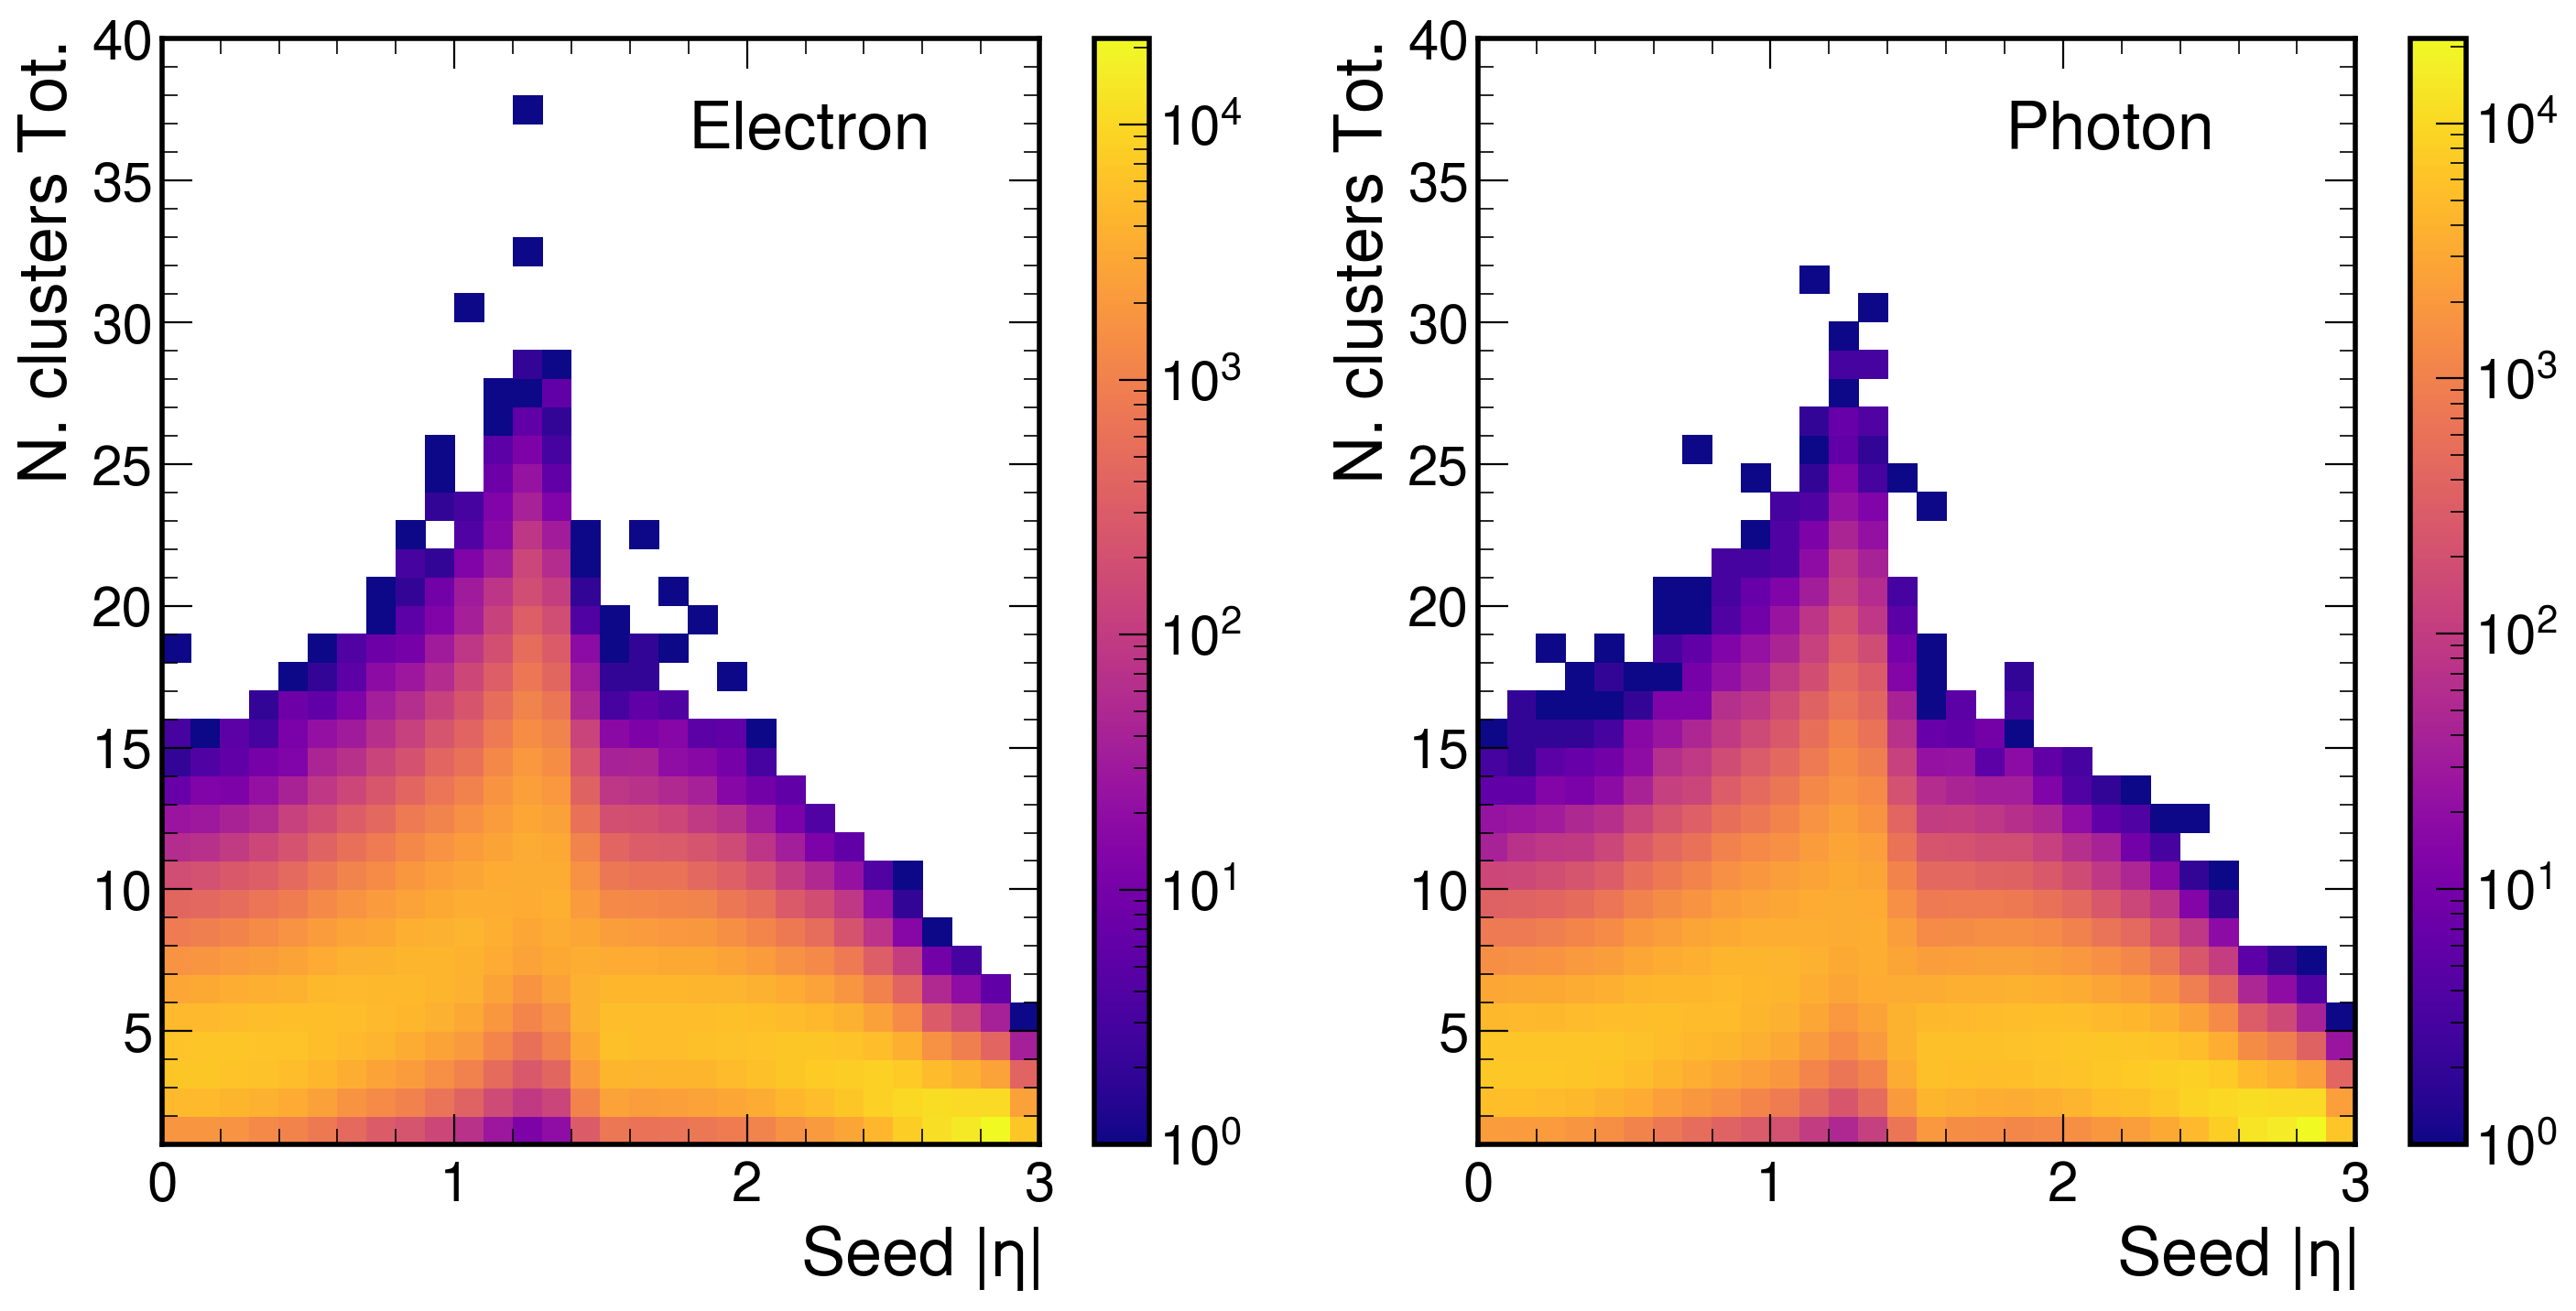

In [155]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=200)

A =ax.hist2d(df_ele.eta,df_ele.ncls,  bins=(30,39), range=[(0,3),(1, 40)],   cmap="plasma" , norm=colors.LogNorm())
B = ay.hist2d(df_gamma.eta,df_gamma.ncls,  bins=(30,39), range=[(0,3),(1, 40)], cmap="plasma", norm=colors.LogNorm())
ax.text(0.6, 0.9, "Electron", transform=ax.transAxes)
ay.text(0.6, 0.9, "Photon", transform=ay.transAxes)


ax.set_xlabel("Seed $|\eta|$")
ay.set_xlabel("Seed $|\eta|$")
ax.set_ylabel("N. clusters Tot.")
ay.set_ylabel("N. clusters Tot.")
plt.colorbar(A[3],ax=ax, )
plt.colorbar(B[3],ax=ay, )

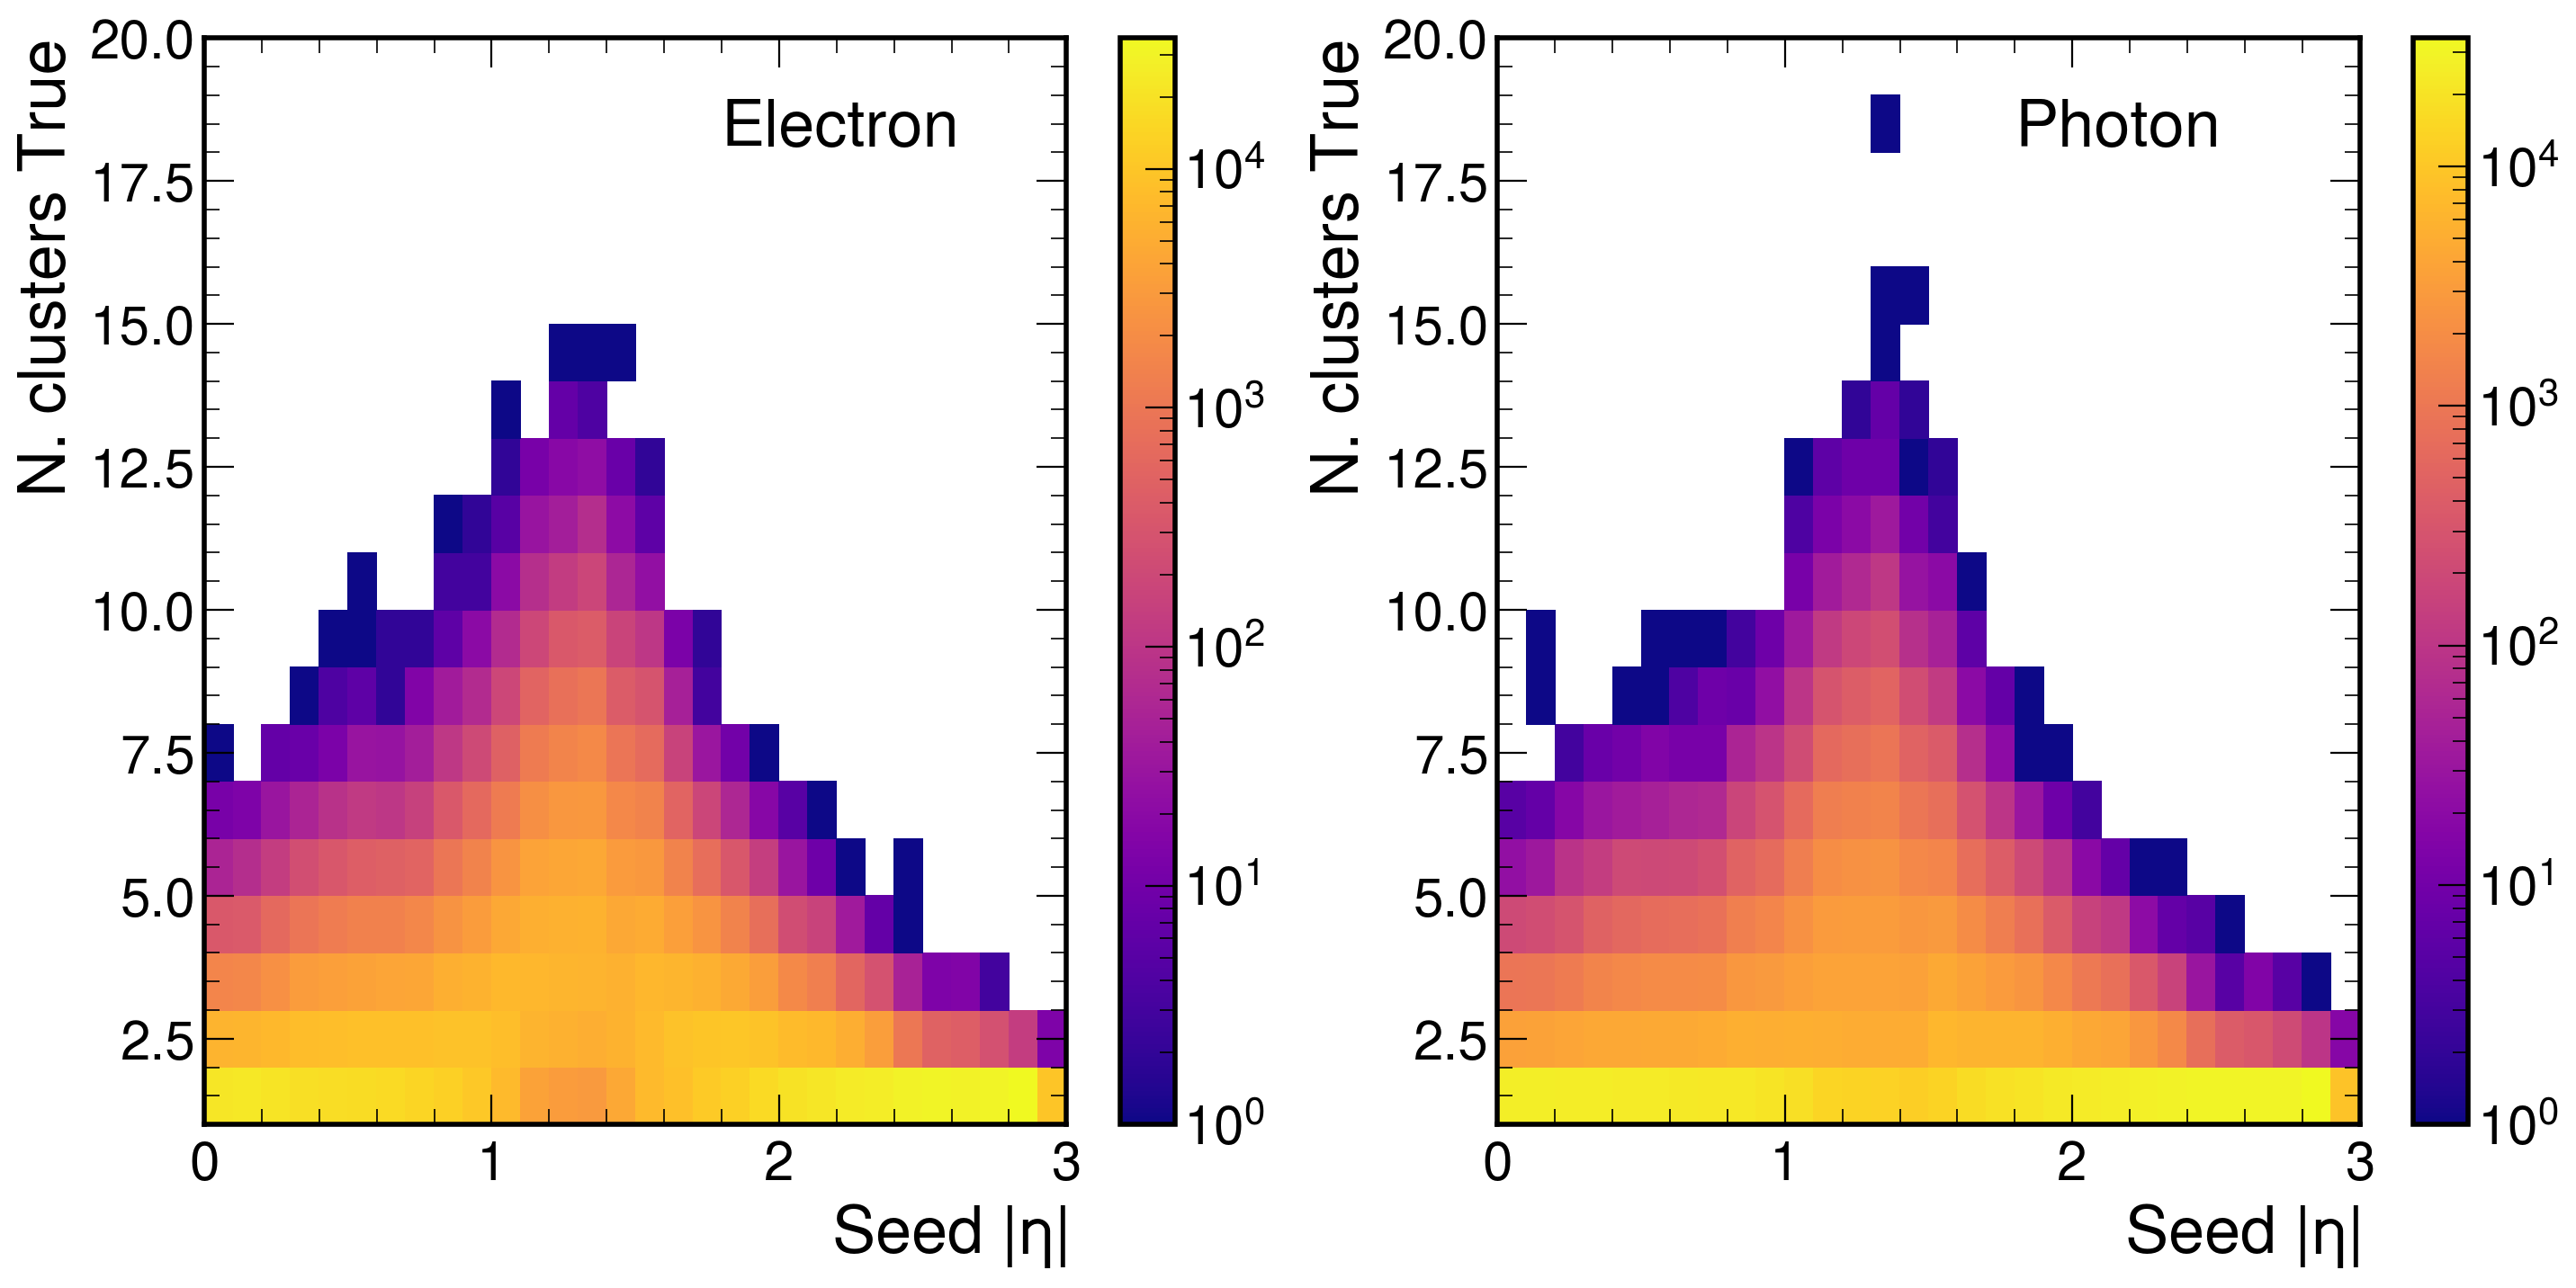

In [156]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=200)

A =ax.hist2d(df_ele.eta,df_ele.ncls_true,  bins=(30,19), range=[(0,3),(1, 20)],   cmap="plasma" , norm=colors.LogNorm())
B = ay.hist2d(df_gamma.eta,df_gamma.ncls_true,  bins=(30,19), range=[(0,3),(1, 20)], cmap="plasma",  norm=colors.LogNorm() )
ax.text(0.6, 0.9, "Electron", transform=ax.transAxes)
ay.text(0.6, 0.9, "Photon", transform=ay.transAxes)

ax.set_xlabel("Seed $|\eta|$")
ay.set_xlabel("Seed $|\eta|$")
ax.set_ylabel("N. clusters True")
ay.set_ylabel("N. clusters True")
plt.colorbar(A[3],ax=ax, )
plt.colorbar(B[3],ax=ay, )

In [ ]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=200)

    ax.hist(df_ele.ncls, bins=40,
            range=(0, 40), histtype="step", label="N. clusters {}".format(ncl), linewidth=2, density=True)
    ay.hist(df_gamma[df_gamma.ncls_true ==ncl].en_seed / df_gamma[df_gamma.ncls_true ==ncl].En_true, bins=40, 
            range=(0.4,1), histtype="step", label="N. clusters {}".format(ncl), linewidth=2, density=True)
ax.legend(loc="upper left")
ay.legend(loc="upper left")
ax.set_ylim(1,20)
ay.set_ylim(1,20)
# ax.set_yscale("log")
ax.text(0.7,0.85,"Electron", transform = ax.transAxes)  
ay.text(0.7,0.85,"Photon", transform = ay.transAxes)  
ax.set_xlabel("Seed Energy / total correct Energy")
ay.set_xlabel("Seed Energy / total correct Energy")
hep.cms.text("Preliminary ",loc=0, ax=ax)
hep.cms.text("Preliminary ",loc=0, ax=ay)
# ay.text(0.1,0.1, "Ncl true{}".format(ncl), transform=ax.transAxes)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

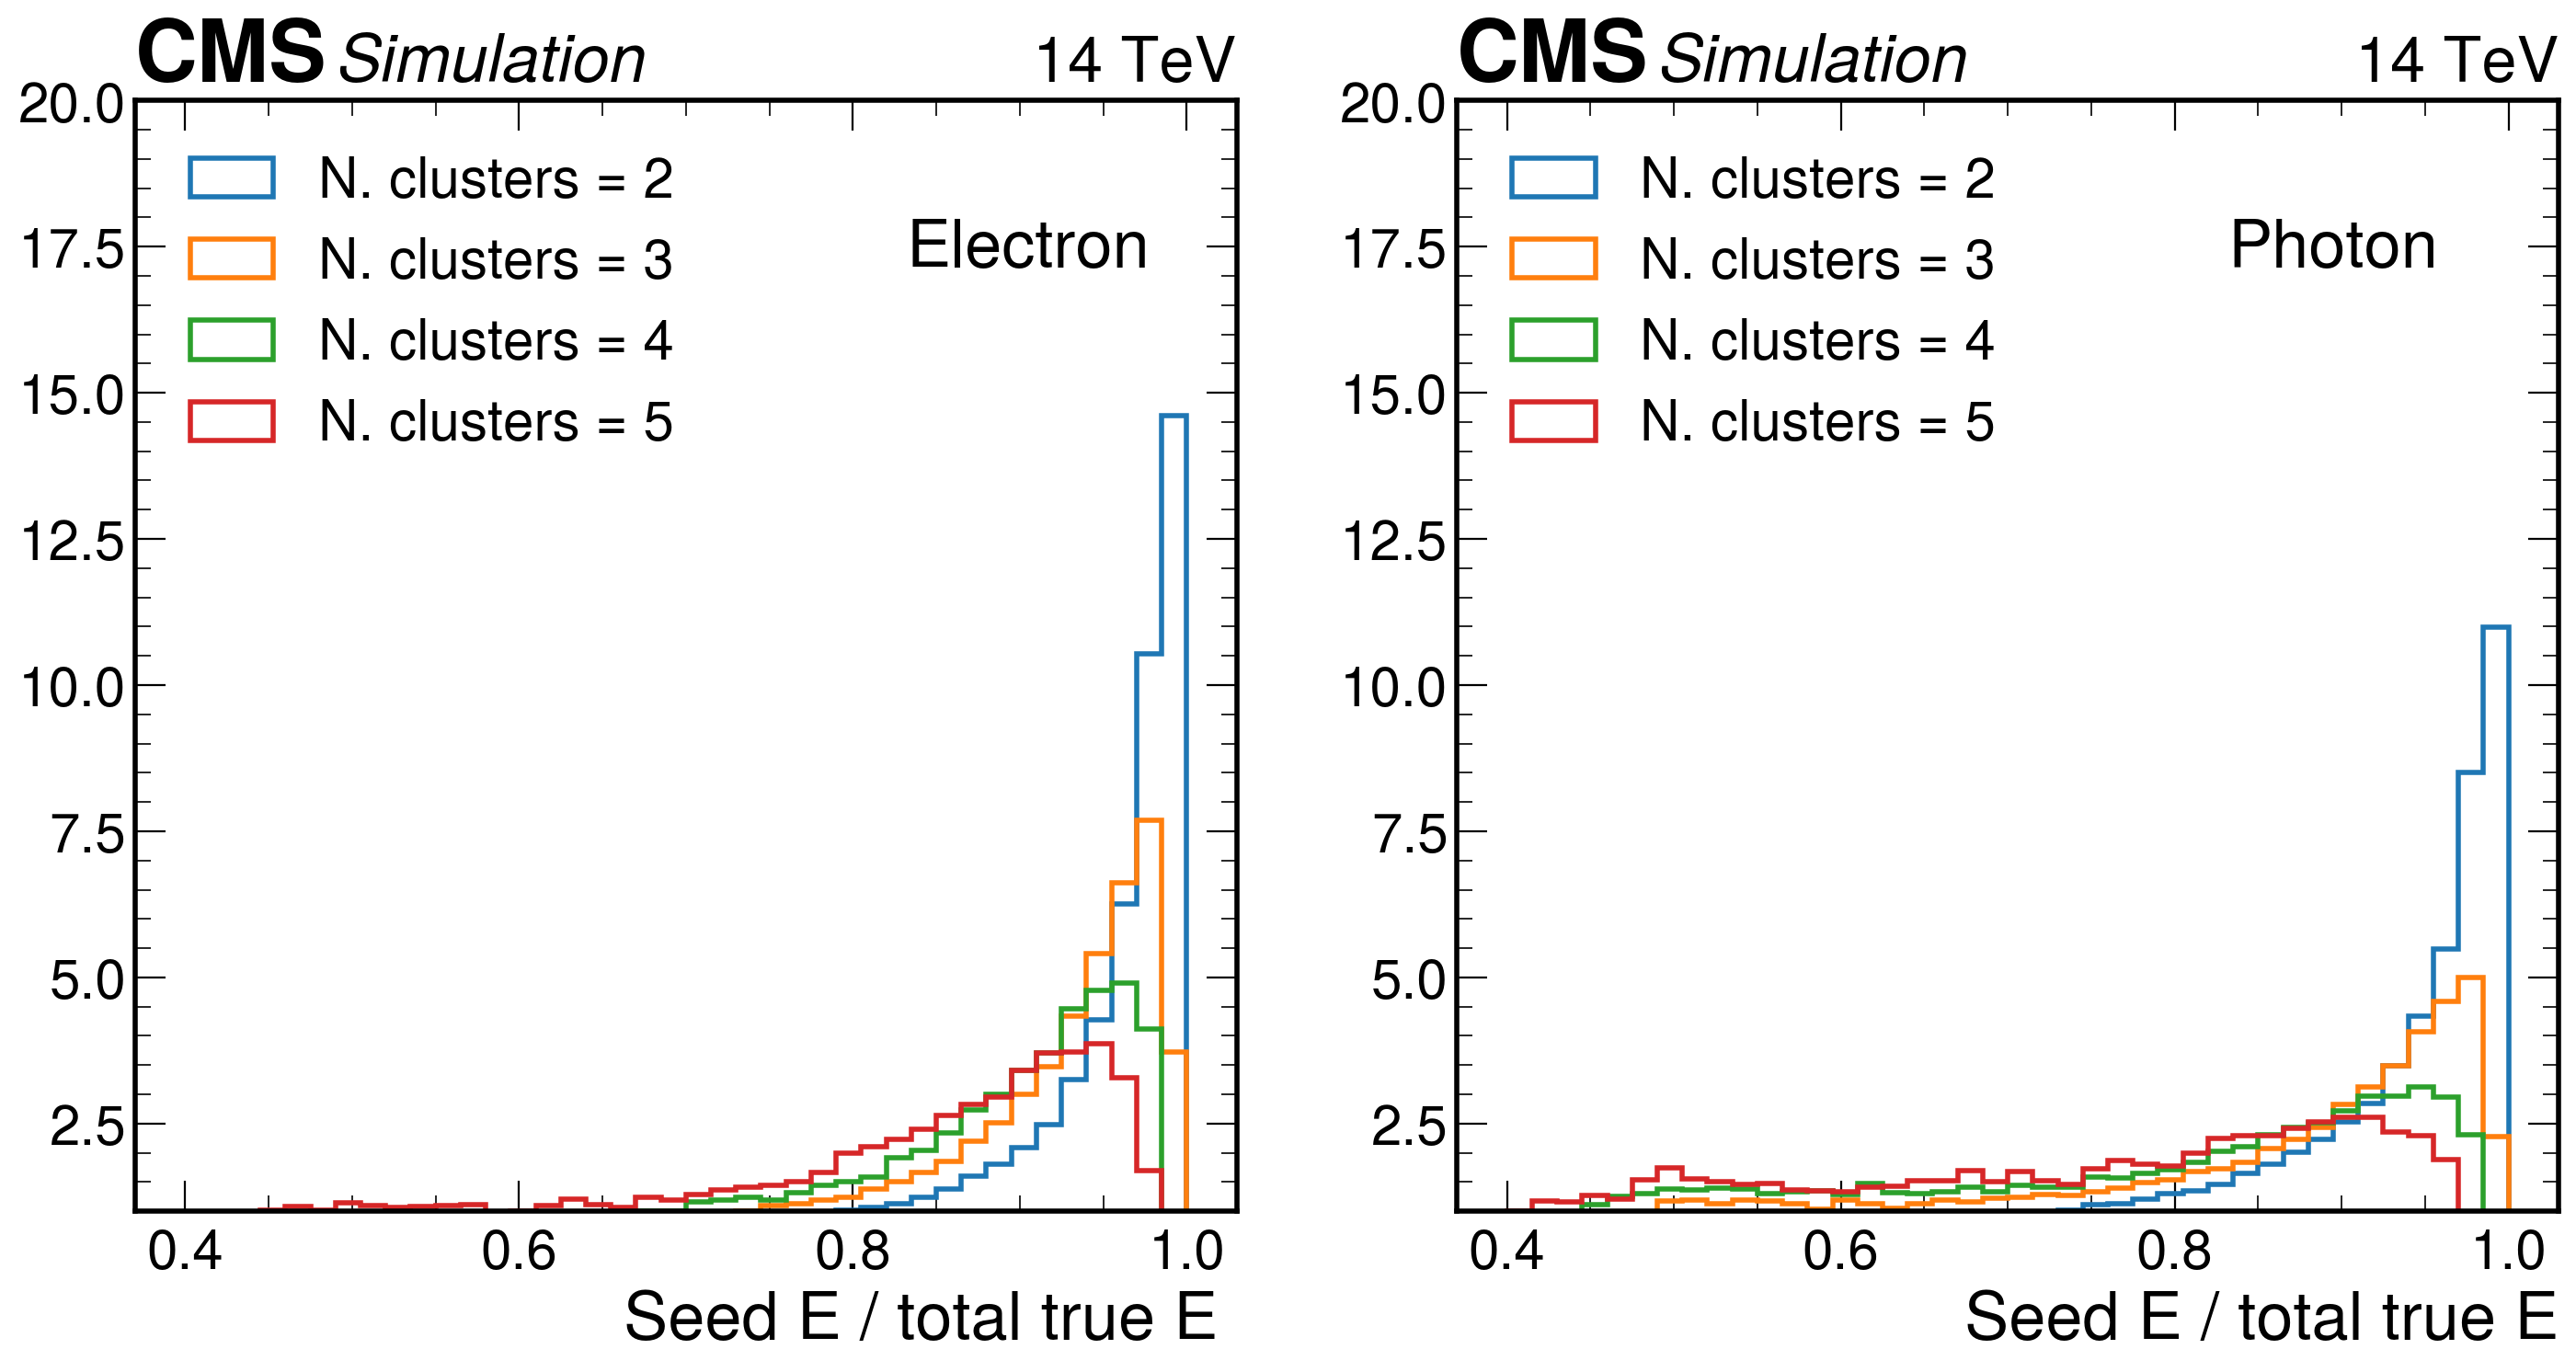

In [53]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=200)
ncls = [2,3,4,5]
for ncl in ncls:
    ax.hist(df_ele[df_ele.ncls_true ==ncl].en_seed / df_ele[df_ele.ncls_true ==ncl].En_true, bins=40,
            range=(0.4,1), histtype="step", label="N. clusters = {}".format(ncl), linewidth=2, density=True)
    ay.hist(df_gamma[df_gamma.ncls_true ==ncl].en_seed / df_gamma[df_gamma.ncls_true ==ncl].En_true, bins=40, 
            range=(0.4,1), histtype="step", label="N. clusters = {}".format(ncl), linewidth=2, density=True)
ax.legend(loc="upper left")
ay.legend(loc="upper left")
ax.set_ylim(1,20)
ay.set_ylim(1,20)
# ax.set_yscale("log")
ax.text(0.7,0.85,"Electron", transform = ax.transAxes)  
ay.text(0.7,0.85,"Photon", transform = ay.transAxes)  
ax.set_xlabel("Seed E / total true E ")
ay.set_xlabel("Seed E / total true E")
hep.cms.label(rlabel="14 TeV",loc=0, ax=ax)
hep.cms.label(rlabel="14 TeV",loc=0, ax=ay)
# ay.text(0.1,0.1, "Ncl true{}".format(ncl), transform=ax.transAxes)

<ipython-input-145-2fbd24b9c91b>:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(ele_frac[1][:-1], ele_frac[0]/gamma_frac[0], label="# cluster = {}".format(ncl), linewidth=2)
<ipython-input-145-2fbd24b9c91b>:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(ele_frac[1][:-1], ele_frac[0]/gamma_frac[0], label="# cluster = {}".format(ncl), linewidth=2)


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

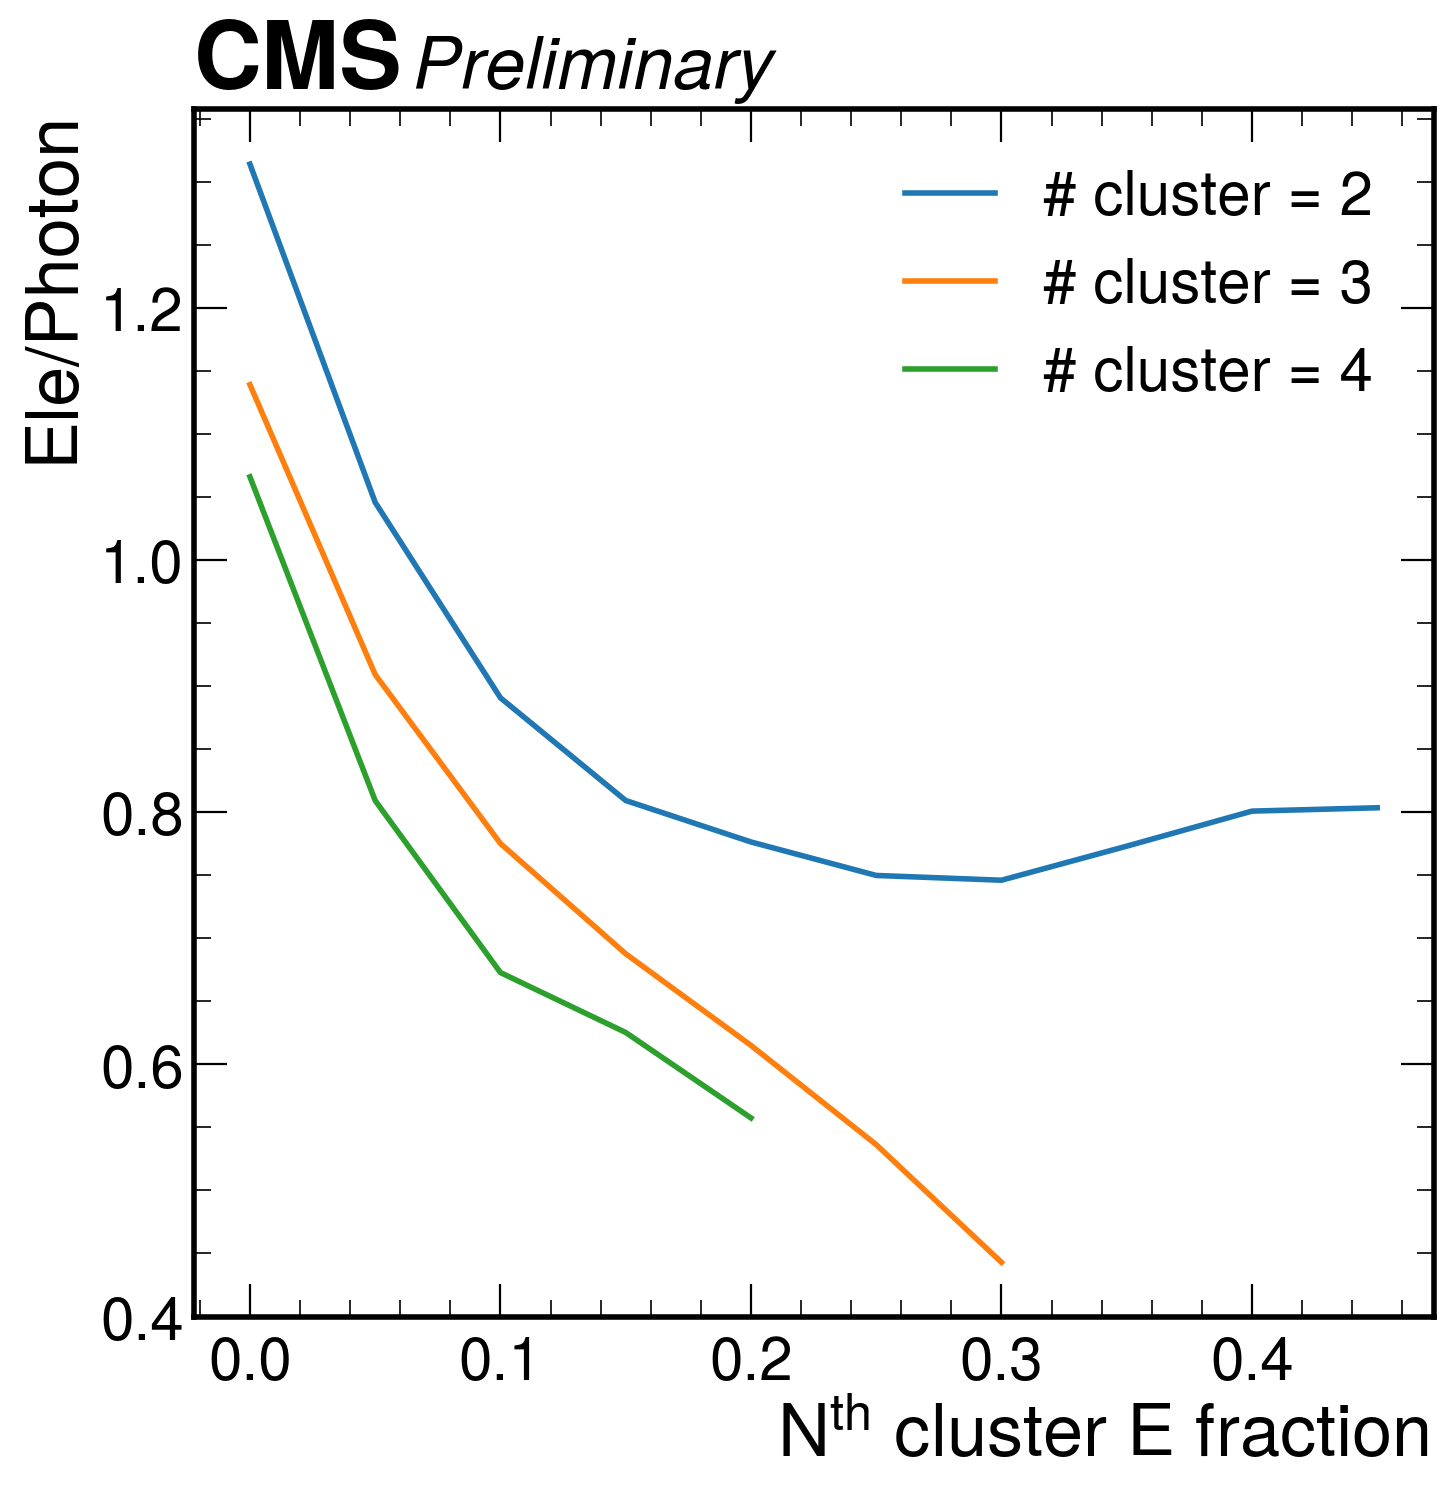

In [145]:
fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
ncls = [2,3,4]
for ncl in ncls:
    ele_frac = np.histogram(df_ele[df_ele.ncls_true >=ncl]["En_cl_true_"+str(ncl)] / df_ele[df_ele.ncls_true >=ncl].En_true, bins=10, range=(0.,0.5),density=True)
    gamma_frac = np.histogram(df_gamma[df_gamma.ncls_true >=ncl]["En_cl_true_"+str(ncl)] / df_gamma[df_gamma.ncls_true >=ncl].En_true, bins=10, range=(0.,0.5),density=True)
    ax.plot(ele_frac[1][:-1], ele_frac[0]/gamma_frac[0], label="# cluster = {}".format(ncl), linewidth=2)
#     ay.plot(ele_frac[1][:-1], ele_frac[0], label="ele"+str(ncl))
#     ay.plot(ele_frac[1][:-1], gamma_frac[0], label="gamma"+str(ncl))

ax.legend(loc="upper right")
# ax.set_ylim(1e-2,1e3)
# ay.set_ylim(1e-2,1e3)
# ax.set_yscale("log")
# ay.set_yscale("log")
ax.set_xlabel("$N^{th}$ cluster E fraction ")
ax.set_ylabel("Ele/Photon")
hep.cms.text("Preliminary ",loc=0, ax=ax)
hep.cms.text("Preliminary ",loc=0, ax=ay)
# ay.text(0.1,0.1, "Ncl true{}".format(ncl), transform=ax.transAxes)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

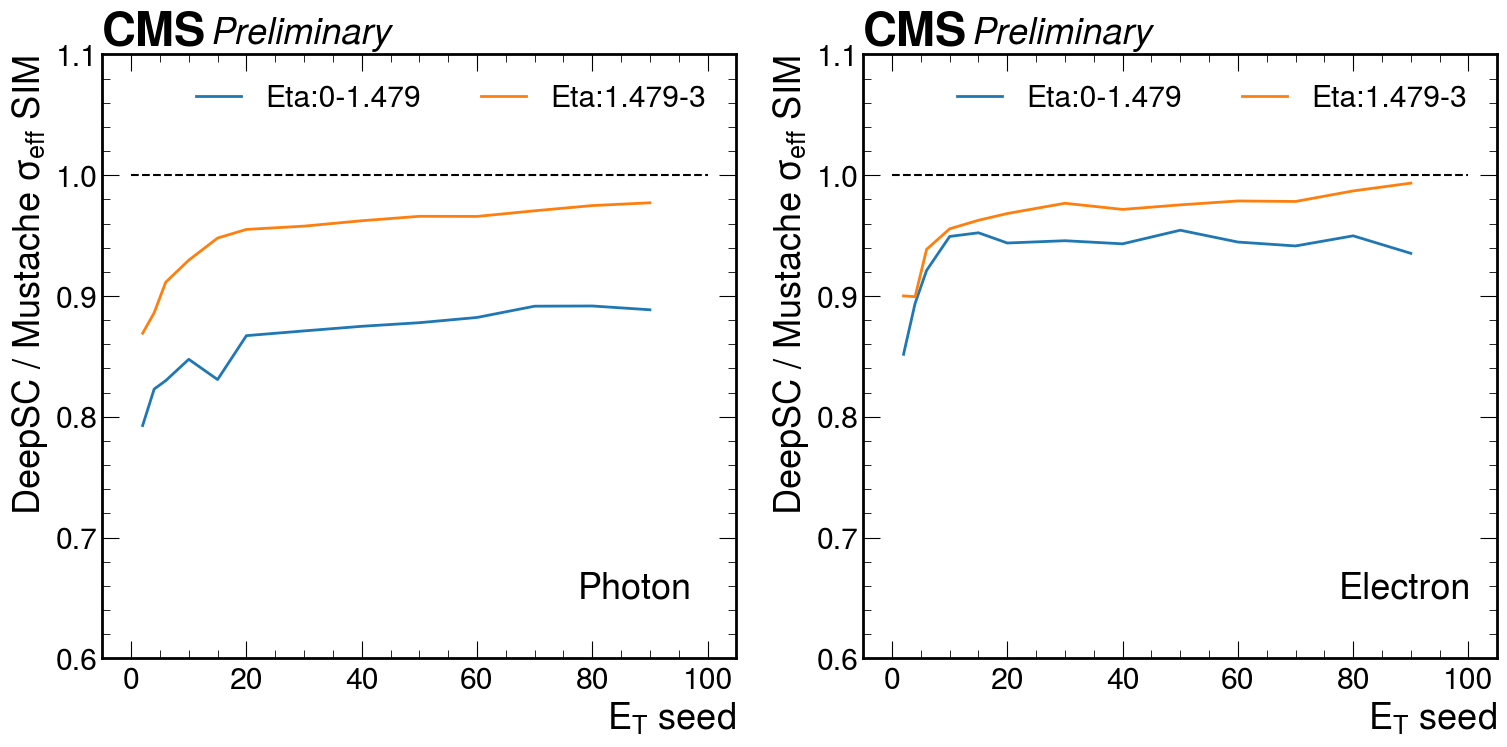

In [24]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(18,8),dpi=100, )

df = df_gamma
flavour = "Photon"
ets = [2, 4,6, 10,15,20,30,40,50,60,70,80,90,100]
etas = [0, 1.479, 3]
df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)


# gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[0.8,0.2])
# axs = gs.subplots(sharex=True)

for ieta, eta in enumerate(etas[:-1]):
    ax.plot(ets[:-1], res[res.eta_bin == ieta].w68/res_must[res_must.eta_bin == ieta].w68, label="Eta:{}-{}".format(etas[ieta], etas[ieta+1]), linewidth=2)
ax.set_ylim(0.6, 1.1)
ax.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ax.legend(ncol=2)
ax.set_xlabel("$E_T$ seed")
ax.plot([0,100],[1,1], linestyle="dashed", color="black")

ax.text(0.75, 0.1, flavour, transform=ax.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ax)



df = df_ele
flavour = "Electron"

ets = [2, 4,6,10,15,20,30,40,50,60,70,80,90,100]
etas = [0, 1.479, 3]
df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

for ieta, eta in enumerate(etas[:-1]):
    ay.plot(ets[:-1], res[res.eta_bin == ieta].w68/res_must[res_must.eta_bin == ieta].w68, label="Eta:{}-{}".format(etas[ieta], etas[ieta+1]), linewidth=2)
ay.set_ylim(0.6, 1.1)
ay.set_ylabel("DeepSC / Mustache $\sigma_{eff}$ SIM")
ay.legend(ncol=2)
ay.set_xlabel("$E_T$ seed")
ay.plot([0,100],[1,1], linestyle="dashed", color="black")

ay.text(0.75, 0.1, flavour, transform=ay.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ay)

Confronto tra seed ET e energia totale true SIM associata alla caloparticle cleaned dai canali morti


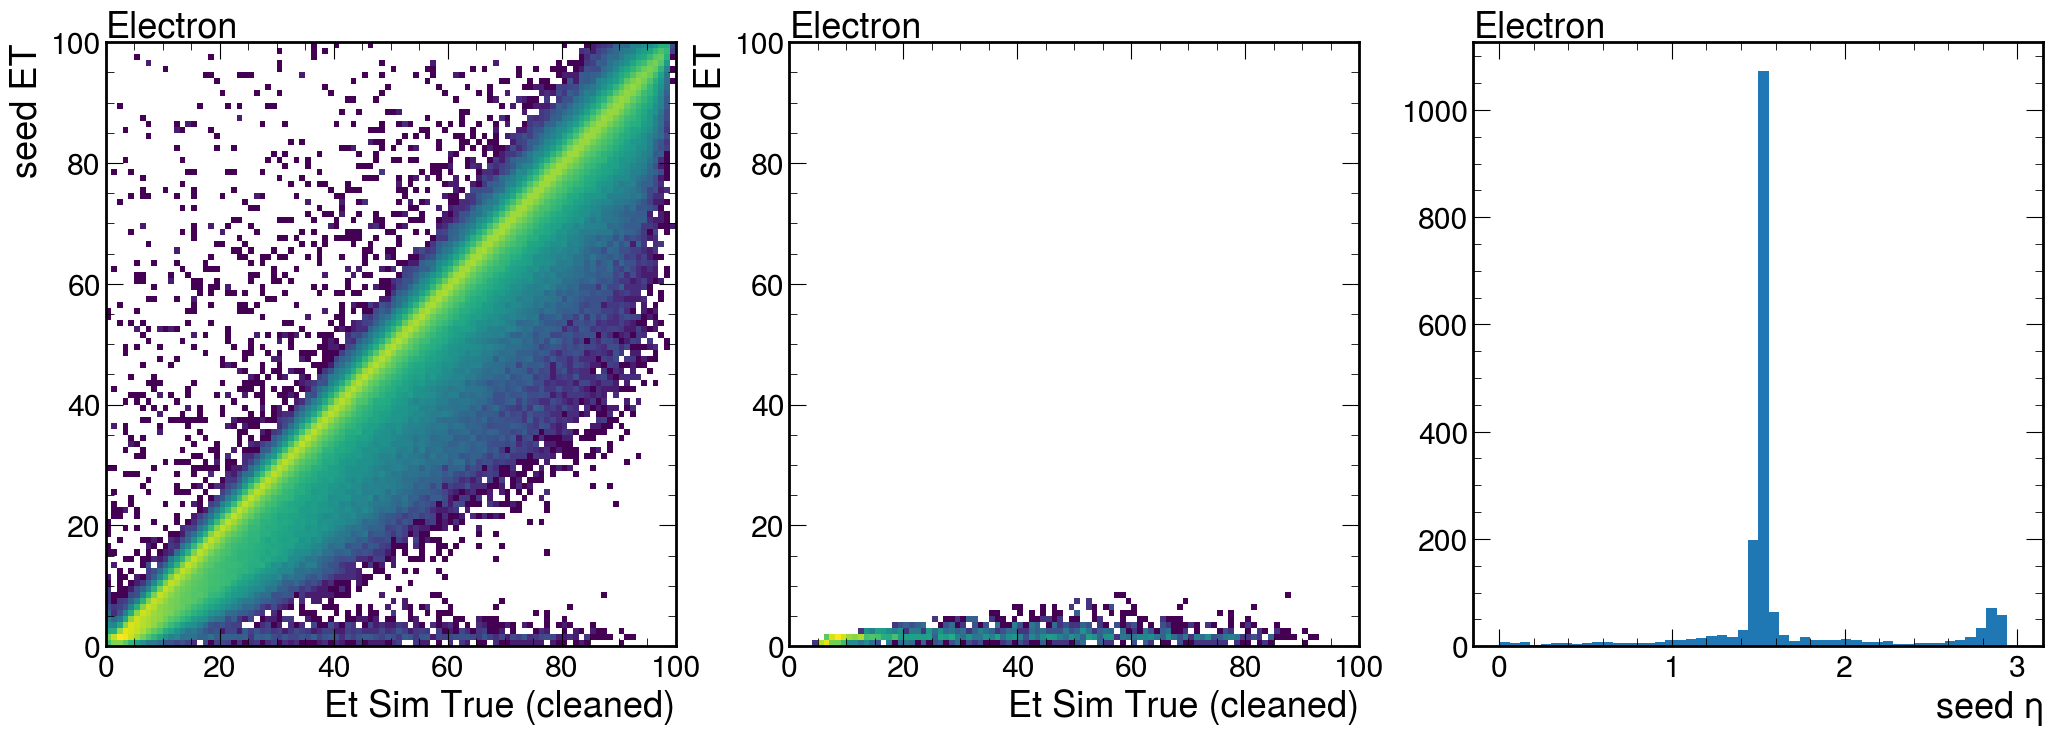

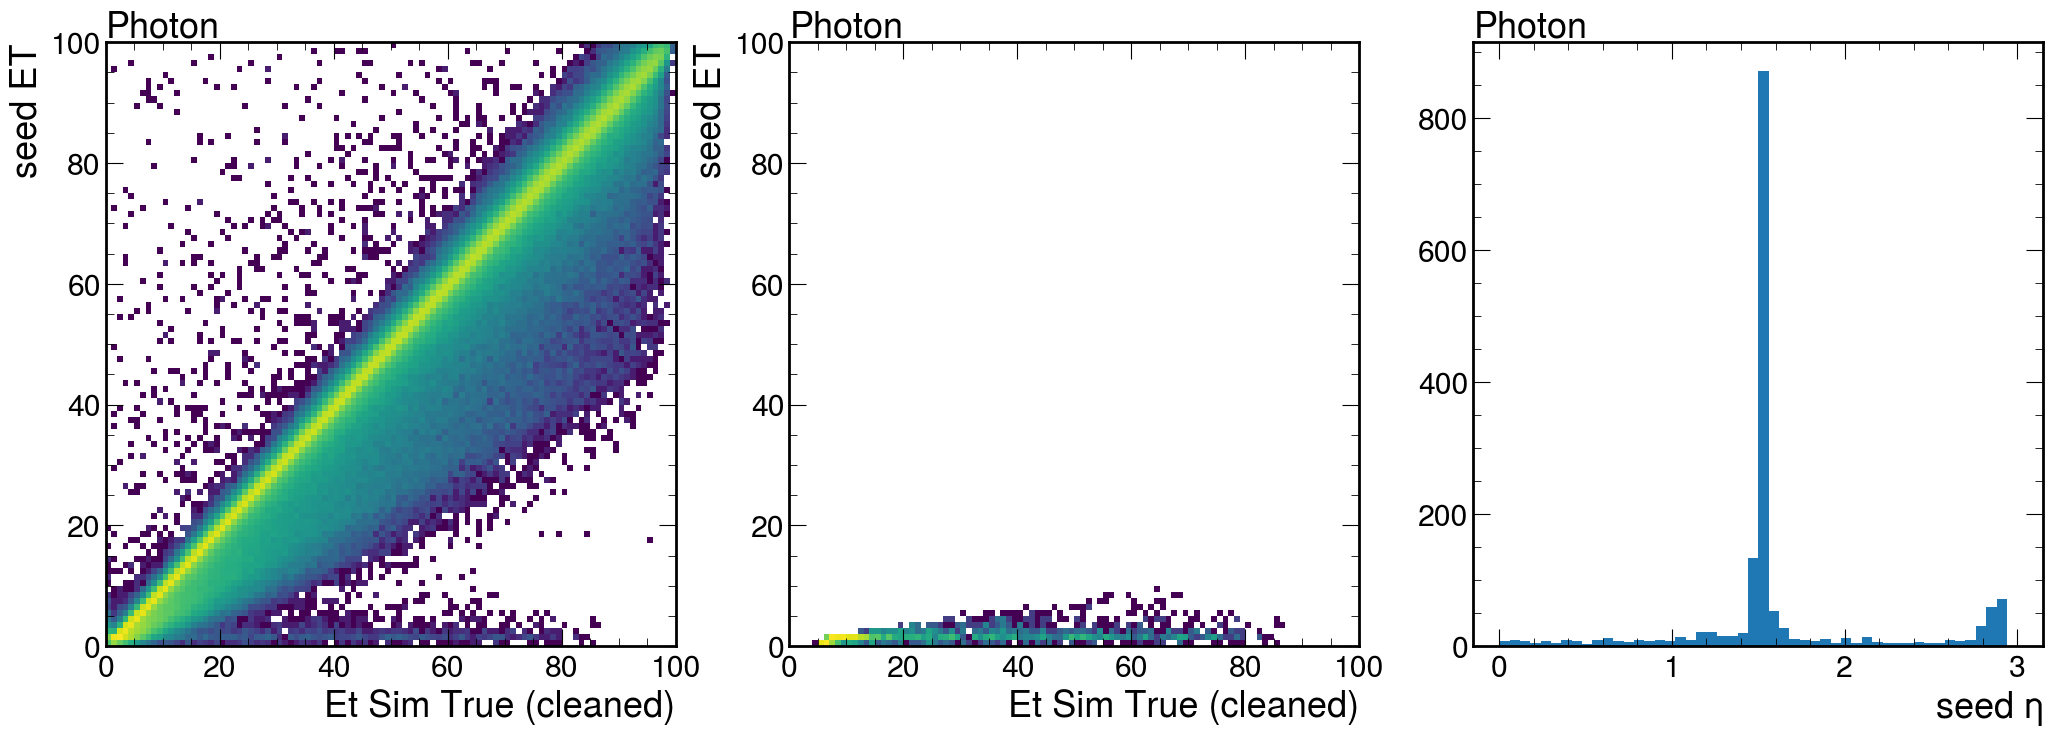

In [42]:

for df, flavour in zip ([df_ele, df_gamma], ["Electron", "Photon"]):
    fig, (ax,ay,az) = plt.subplots(1,3, figsize=(25,8), dpi=100)

    ax.hist2d(df.et_true_sim_good,df.et, bins=(100,100), range=((0,100),(0,100)), cmin=1, norm=colors.LogNorm())
    ax.set_xlabel("Et Sim True (cleaned)")
    ax.set_ylabel("seed ET")
    ax.text(0., 1.01, flavour, transform=ax.transAxes)

    mask = df.et_true_sim_good > 6 * df.et

    ay.hist2d(df[mask].et_true_sim_good,df[mask].et, bins=(100,100), range=((0,100),(0,100)), cmin=1,norm=colors.LogNorm())
    ay.set_xlabel("Et Sim True (cleaned)")
    ay.set_ylabel("seed ET")
    ay.text(0., 1.01, flavour, transform=ay.transAxes)
    
    az.hist(df[mask].eta, bins=50, range=(0,3))
    az.set_xlabel("seed $\eta$")
    az.text(0., 1.01, flavour, transform=az.transAxes)

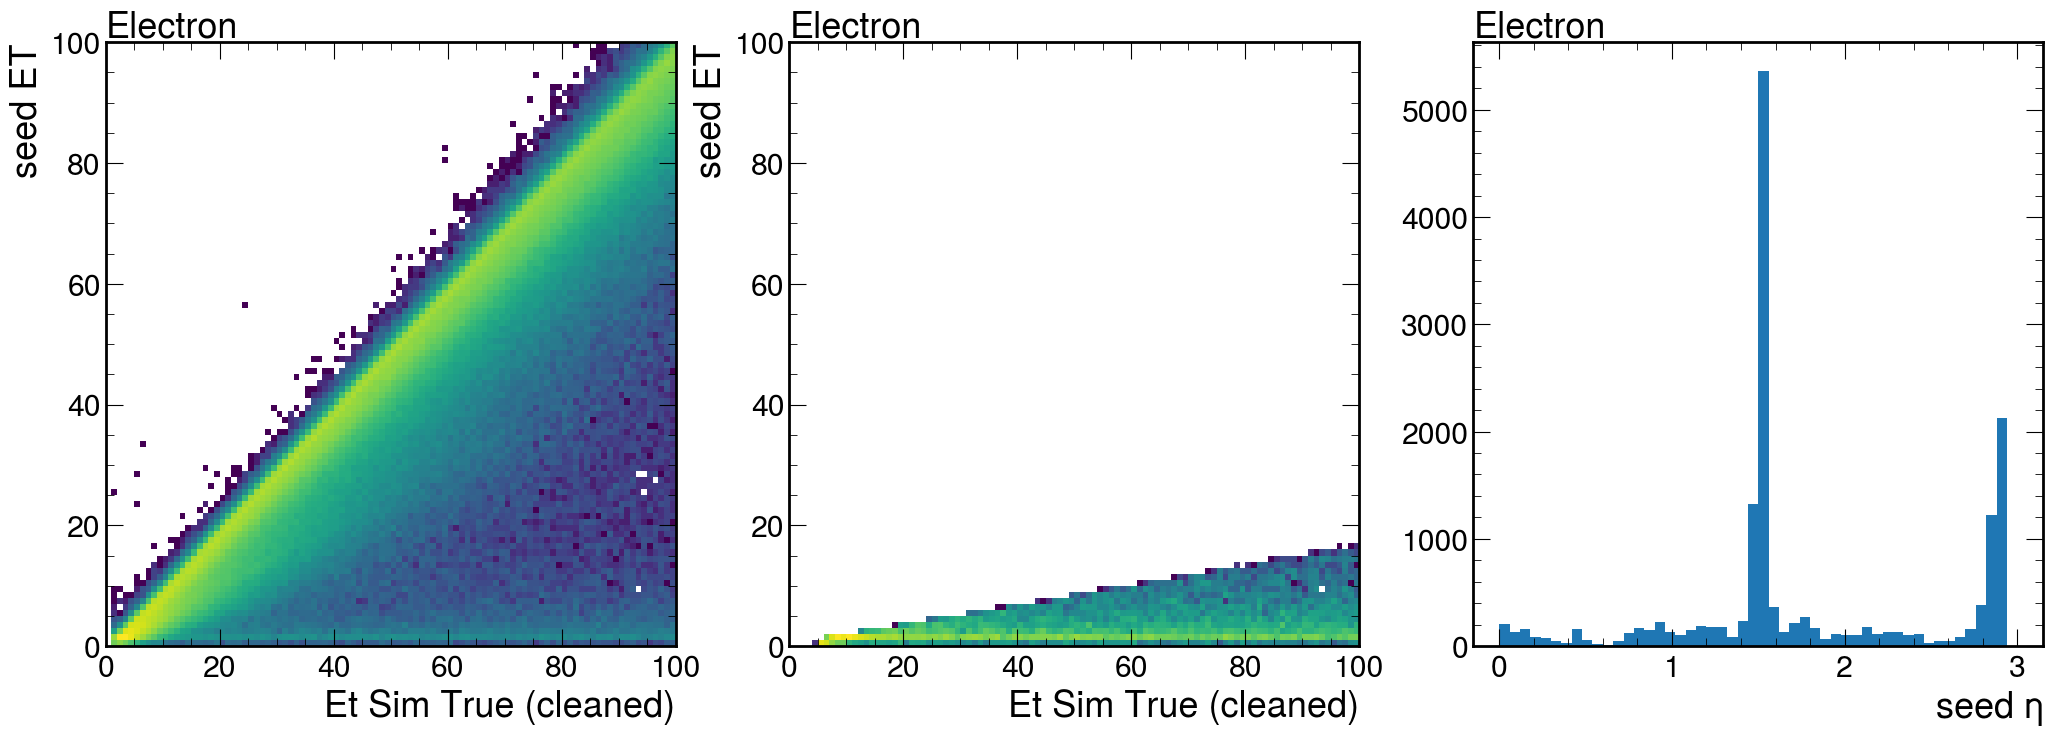

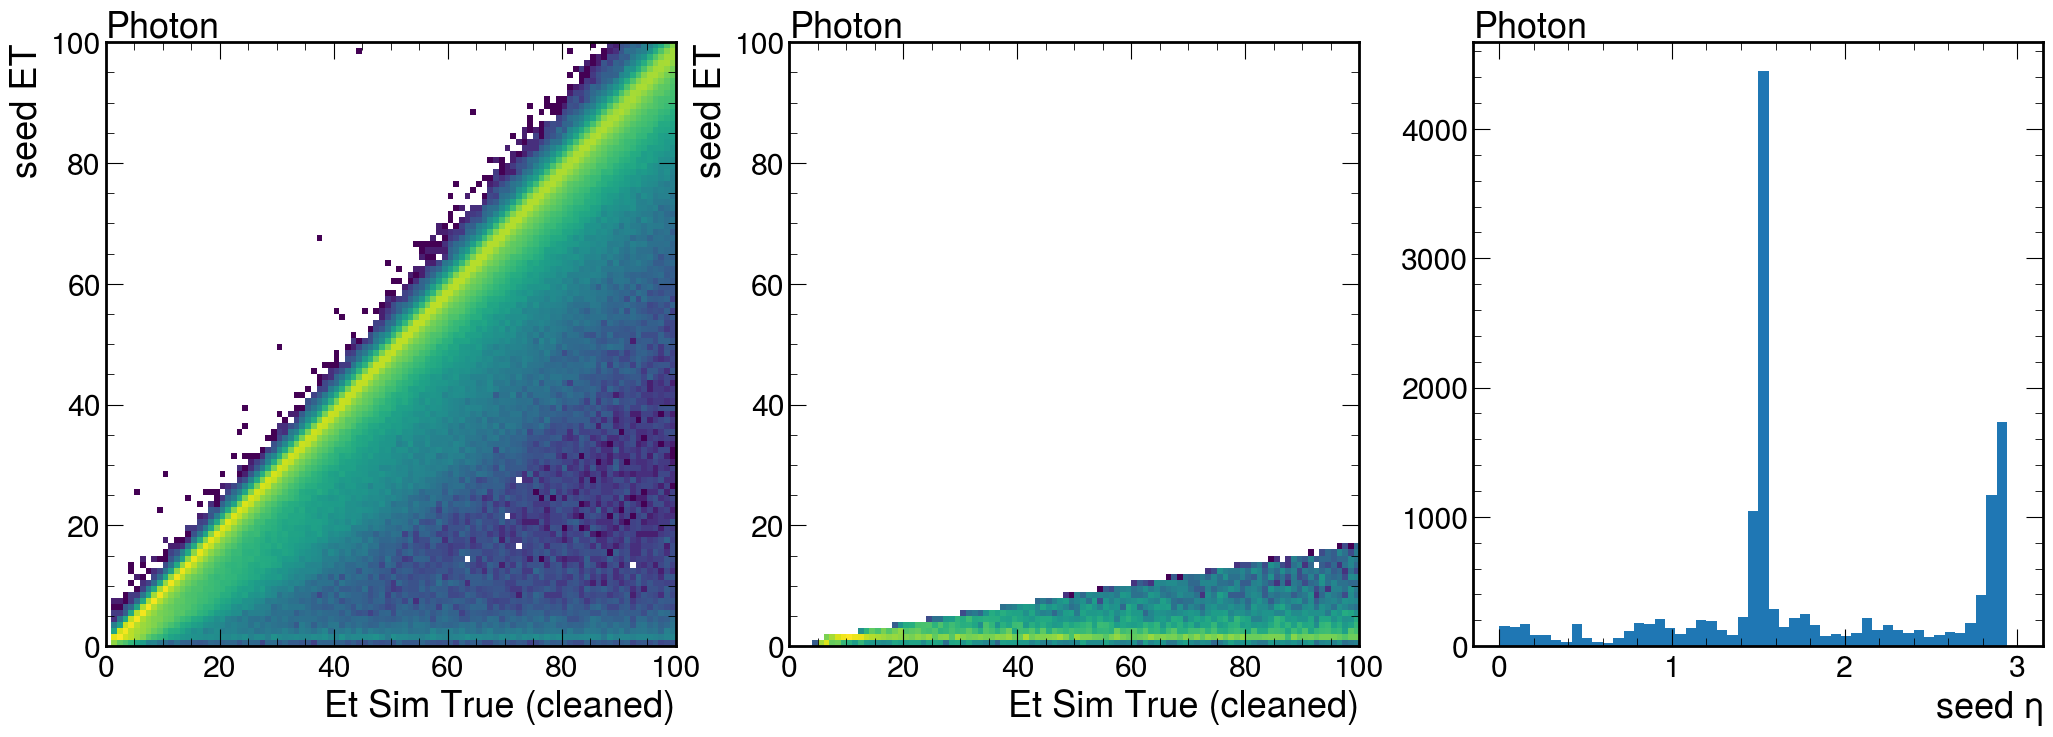

In [43]:
for df, flavour in zip ([df_ele, df_gamma], ["Electron", "Photon"]):
    fig, (ax,ay,az) = plt.subplots(1,3, figsize=(25,8), dpi=100)

    ax.hist2d(df.et_true_gen,df.et, bins=(100,100), range=((0,100),(0,100)), cmin=1, norm=colors.LogNorm())
    ax.set_xlabel("Et Sim True (cleaned)")
    ax.set_ylabel("seed ET")
    ax.text(0., 1.01, flavour, transform=ax.transAxes)

    mask = df.et_true_gen > 6 * df.et

    ay.hist2d(df[mask].et_true_gen,df[mask].et, bins=(100,100), range=((0,100),(0,100)), cmin=1,norm=colors.LogNorm())
    ay.set_xlabel("Et Sim True (cleaned)")
    ay.set_ylabel("seed ET")
    ay.text(0., 1.01, flavour, transform=ay.transAxes)
    
    az.hist(df[mask].eta, bins=50, range=(0,3))
    az.set_xlabel("seed $\eta$")
    az.text(0., 1.01, flavour, transform=az.transAxes)

Text(0.0, 1.01, 'Electron')

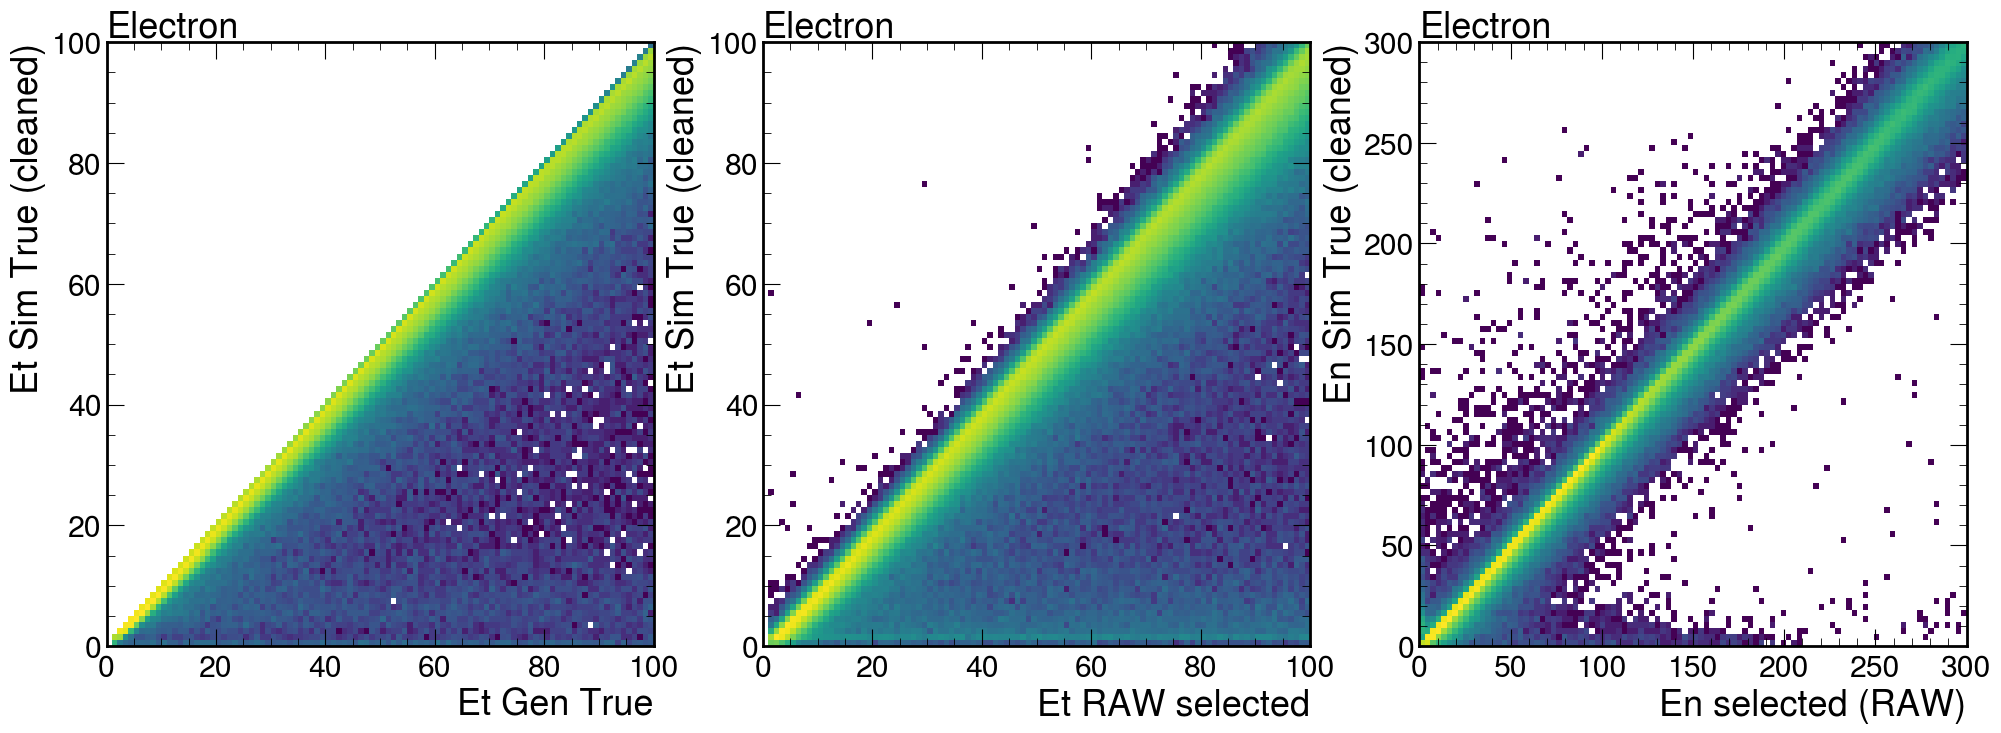

In [10]:
df =df_ele
flavour = "Electron"

fig, (ax,ay,az) = plt.subplots(1,3, figsize=(24,8), dpi=100)
ax.hist2d(df.et_true_gen,df.et_true_sim, bins=(100,100), range=((0,100),(0,100)), norm=colors.LogNorm())
ax.set_ylabel("Et Sim True (cleaned)")
ax.set_xlabel("Et Gen True")
ax.text(0., 1.01, flavour, transform=ax.transAxes)

ay.hist2d(df.et_true_gen,df.Et_sel, bins=(100,100), range=((0,100),(0,100)), norm=colors.LogNorm())
ay.set_ylabel("Et Sim True (cleaned)")
ay.set_xlabel("Et RAW selected")
ay.text(0., 1.01, flavour, transform=ay.transAxes)

az.hist2d(df.en_true_sim_good,df.En_sel, bins=(100,100), range=((0,300),(0,300)), norm=colors.LogNorm())
az.set_ylabel("En Sim True (cleaned)")
az.set_xlabel("En selected (RAW)")
az.text(0., 1.01, flavour, transform=az.transAxes)

In [98]:
N= 20
ets_quantiles= [1. ]
for i in range(1, N):
    ets_quantiles.append(df_tot.et_true_gen.quantile((i)*(1/N)))
ets_quantiles.append(100.)
    
print(", ".join(["{:.2f}".format(e)  for e in ets_quantiles]))

1.00, 7.42, 12.37, 17.28, 22.17, 27.06, 31.94, 36.84, 41.70, 46.56, 51.43, 56.29, 61.13, 65.99, 70.87, 75.73, 80.57, 85.42, 90.29, 95.15, 100.00


Text(1, 0, 'Et GEN')

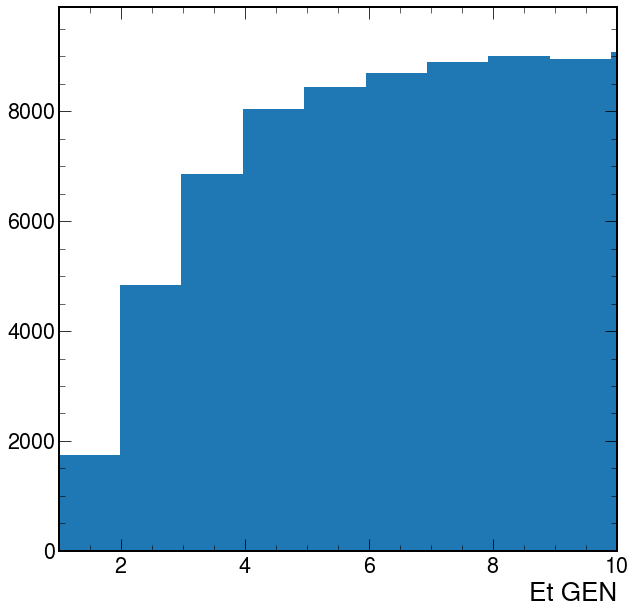

In [101]:
plt.hist(df_ele.et_true_gen, range=(1,100), bins=100)
plt.xlim(1,10)
plt.xlabel("Et GEN")

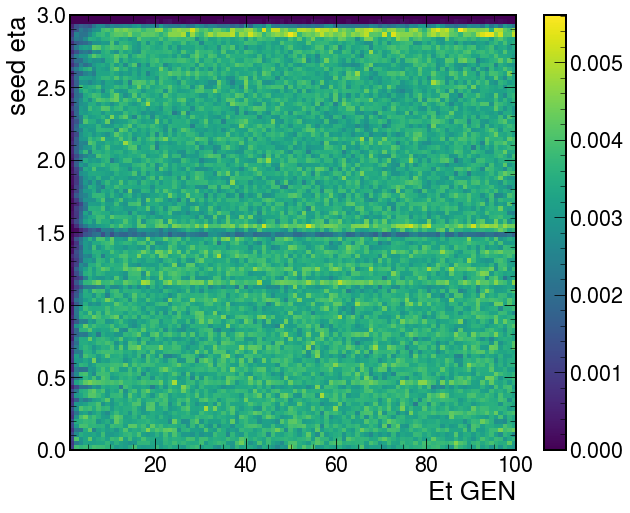

In [11]:
f = plt.figure(figsize=(10,8))
plt.hist2d(df_ele.et_true_gen,df_ele.eta, range=((1,100),(0,3)), bins=(100,100), density=True)
plt.xlabel("Et GEN")
plt.ylabel("seed eta")
plt.colorbar()

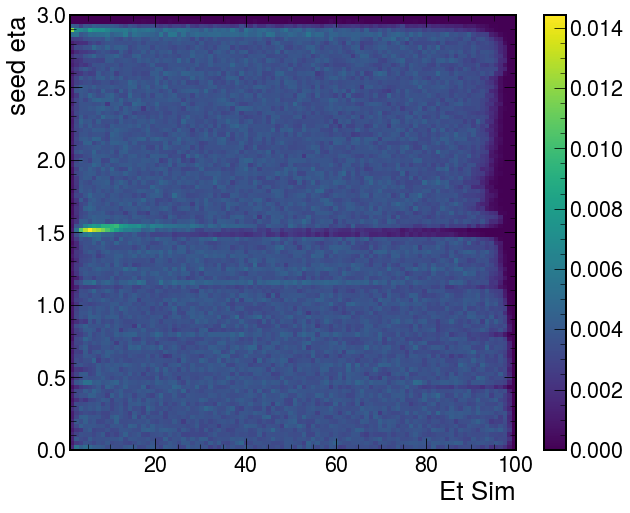

In [13]:
f = plt.figure(figsize=(10,8))
plt.hist2d(df_ele.et_true_sim,df_ele.eta, range=((1,100),(0,3)), bins=(100,100), density=True)
plt.xlabel("Et Sim")
plt.ylabel("seed eta")
plt.colorbar()

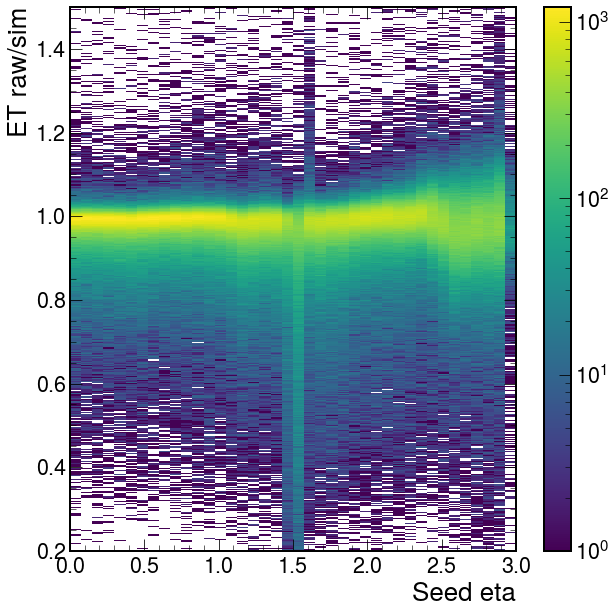

In [35]:
hM = plt.hist2d(df_ele.eta, df_ele.En_ovEtrue_sim_good_mustache, bins=(40,500), range=((0,3),(0.2,1.5)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed eta")
plt.colorbar()

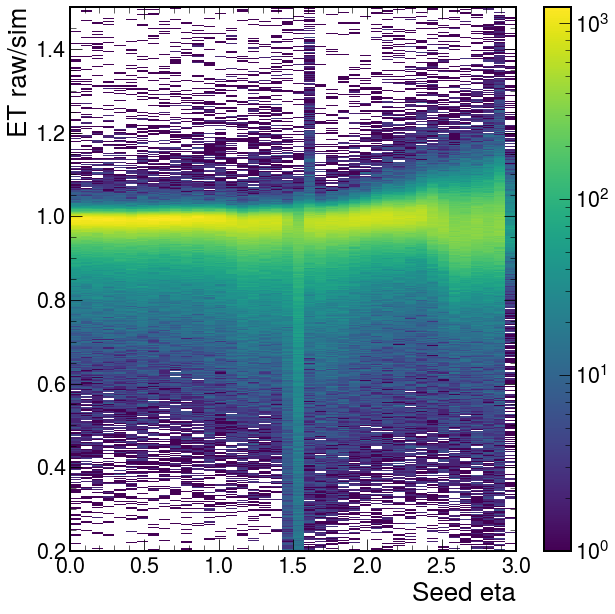

In [36]:
hD = plt.hist2d(df_ele.eta, df_ele.En_ovEtrue_sim_good, bins=(40,500), range=((0,3),(0.2,1.5)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed eta")
plt.colorbar()

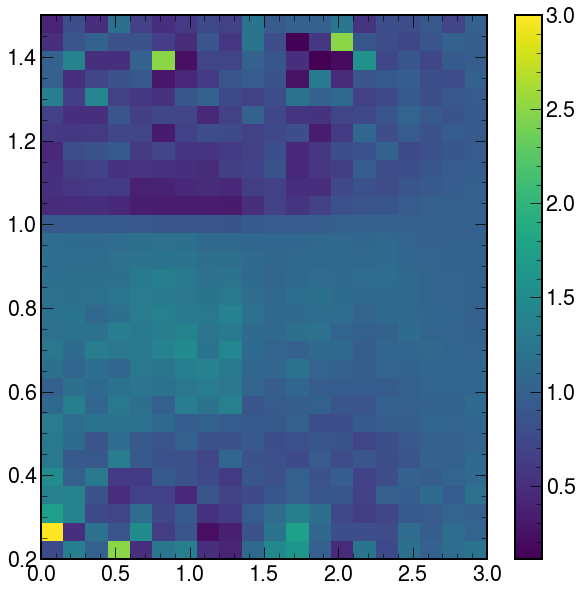

In [54]:
hM = np.histogram2d(df_ele.eta, df_ele.En_ovEtrue_sim_good_mustache, bins=(20,30), range=((0,3),(0.2,1.5)))
hD = np.histogram2d(df_ele.eta, df_ele.En_ovEtrue_sim_good, bins=(20,30), range=((0,3),(0.2,1.5)))
plt.pcolormesh(hM[1],hM[2],(hD[0]/hM[0]).T)
plt.colorbar()

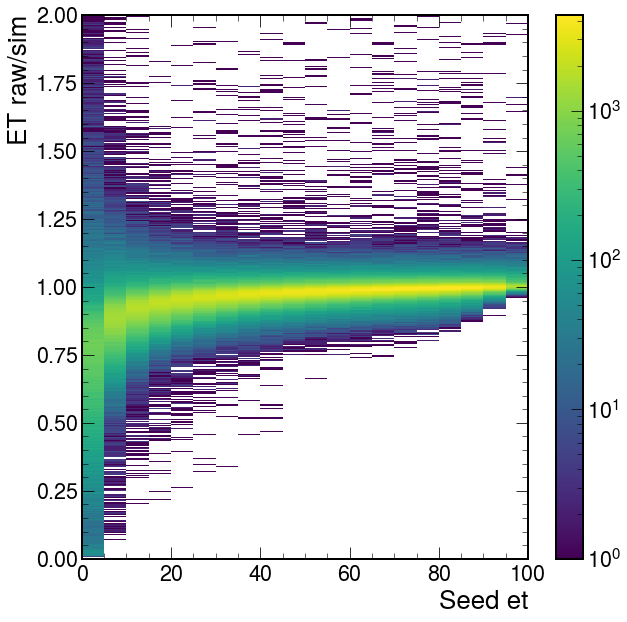

In [56]:
mask = df_ele.seed_eta.abs() < 1.45
plt.hist2d(df_ele.et_seed, df_ele.En_ovEtrue_sim_good, bins=(20,500), range=((0,100),(0,2)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("Seed et")
plt.colorbar()

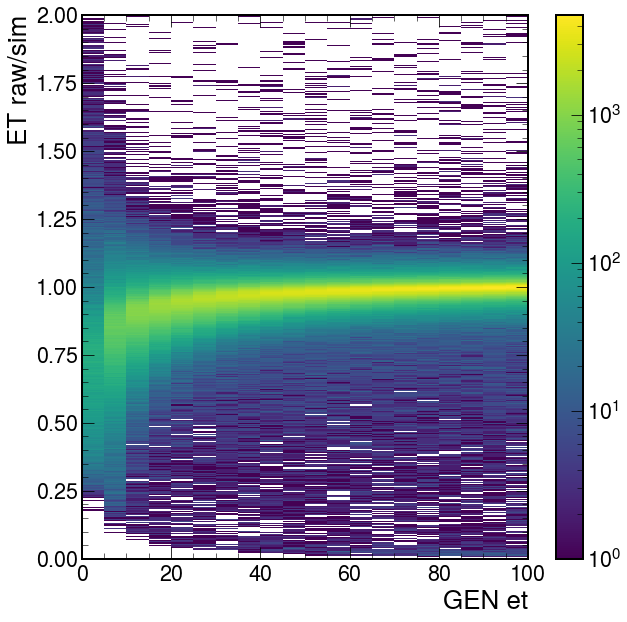

In [57]:
mask = df_ele.seed_eta.abs() < 1.45
plt.hist2d(df_ele.et_true_gen, df_ele.En_ovEtrue_sim_good, bins=(20,500), range=((0,100),(0,2)), norm=colors.LogNorm())
plt.ylabel("ET raw/sim")
plt.xlabel("GEN et")
plt.colorbar()

Text(0.0, 1.01, 'Electrons - DeepSC')

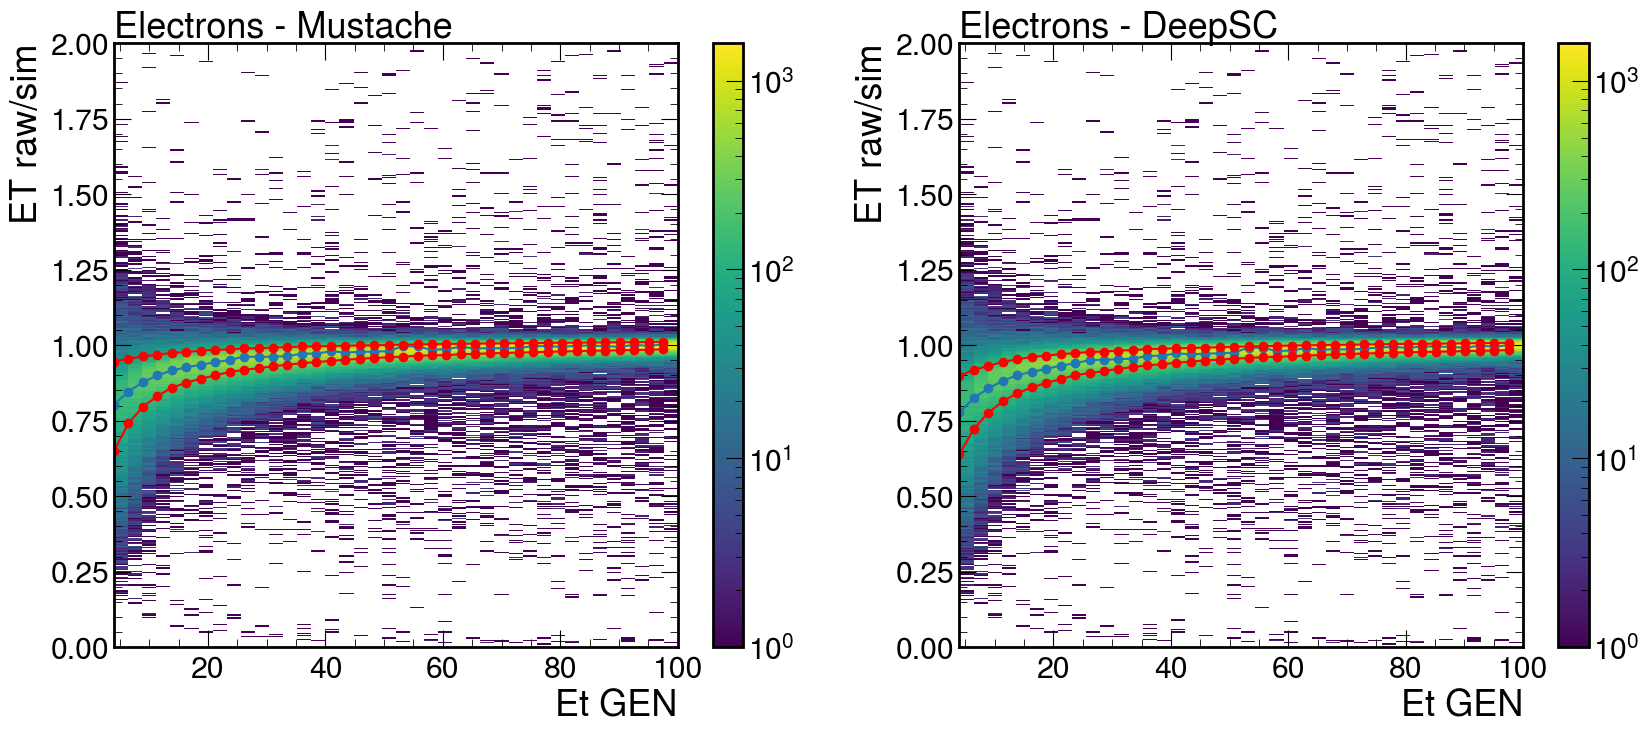

In [63]:
bins = np.linspace(4, 100, 40)

for df in [df_ele]:
    df["et_bin"] = pd.cut(df.et_true_gen, bins, labels=list(range(len(bins)-1)))
    
mask_d_eta = df_ele.seed_eta.abs()<1.45
mask_m_eta = mask_d_eta
res_d = df_ele[mask_d_eta].groupby(["et_bin"]).apply(bin_analysis_details("En_ovEtrue_sim_good"))
res_m = df_ele[mask_m_eta].groupby(["et_bin"]).apply(bin_analysis_details("En_ovEtrue_sim_good_mustache"))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_ele[mask_m_eta].et_true_gen, df_ele[mask_m_eta].En_ovEtrue_sim_good,  bins=(40,500), range=((4,100),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Et GEN")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.et_bin], res_m.m, marker="o")
ax.plot(bins[res_m.et_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.et_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_ele[mask_d_eta].et_true_gen, df_ele[mask_d_eta].En_ovEtrue_sim_good,  bins=(40,500), range=((4,100),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Et GEN")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.et_bin], res_d.m, marker="o")
ay.plot(bins[res_d.et_bin], res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.et_bin], res_d.w68_d, marker="o", color="r")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)



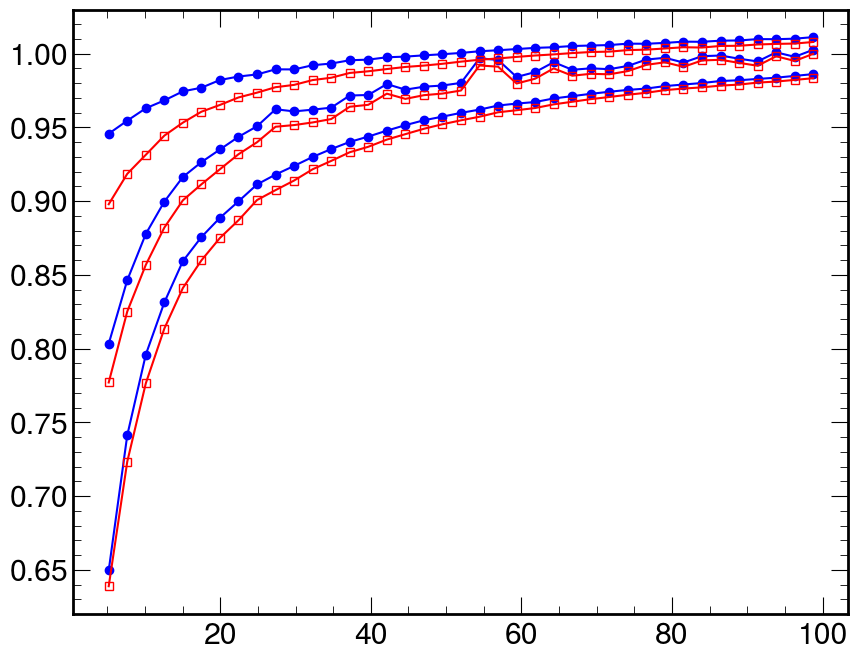

In [64]:
fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
offset = +1.2
ax.plot(bins[res_m.et_bin]+offset, res_m.m, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_u, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_d, marker="o", color="b")

ax.plot(bins[res_d.et_bin]+offset, res_d.m, marker="s", markerfacecolor='none', c="r", )
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_u, marker="s", markerfacecolor='none', c="r",)
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_d, marker="s", markerfacecolor='none', c="r")

Text(0.0, 1.01, 'Electrons - DeepSC')

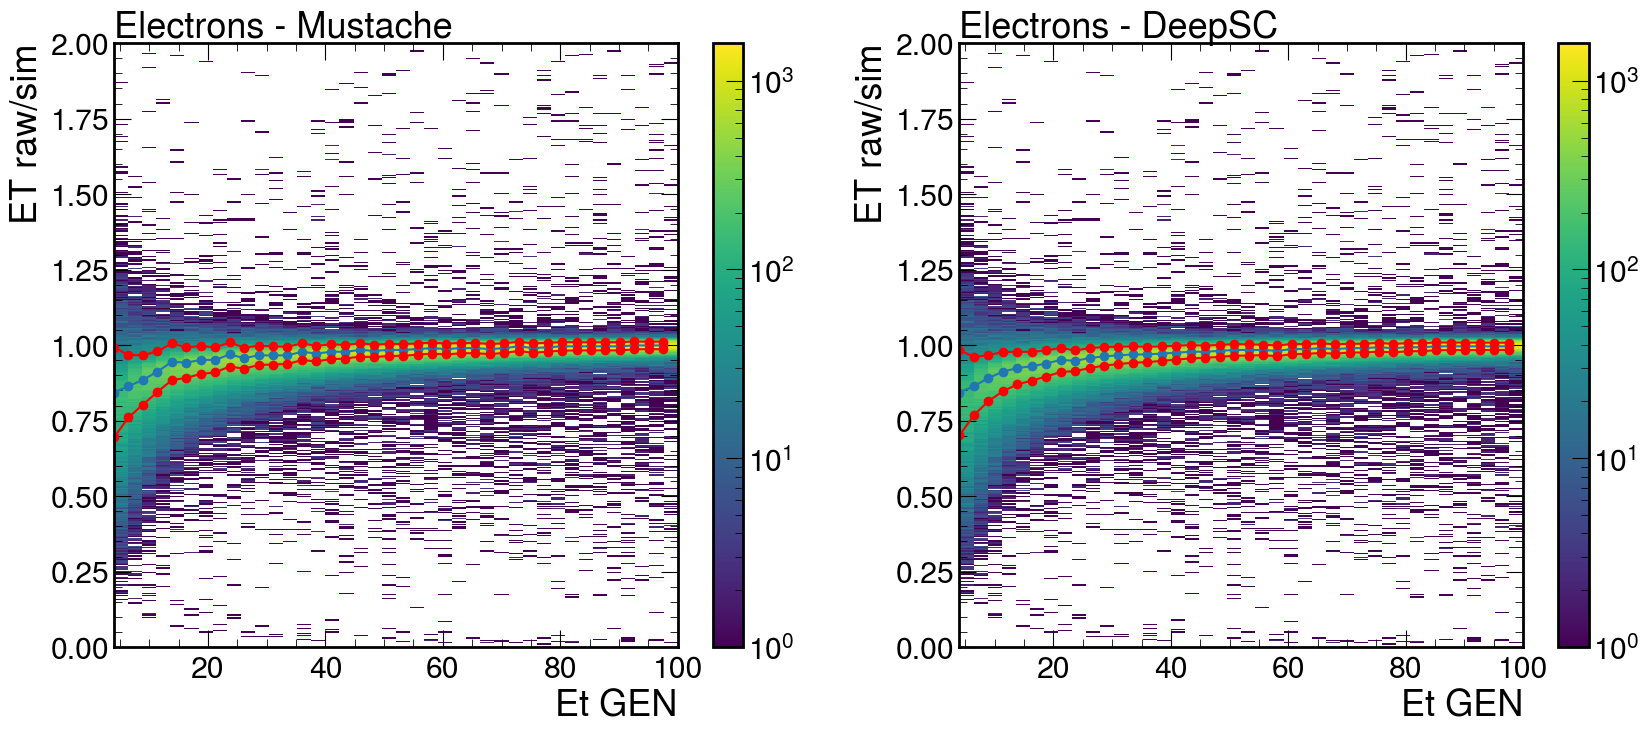

In [66]:
bins = np.linspace(4, 100, 40)

for df in [df_ele]:
    df["et_bin"] = pd.cut(df.et_true_gen, bins, labels=list(range(len(bins)-1)))
    
mask_d_eta = df_ele.seed_eta.abs()<1.45
mask_m_eta = mask_d_eta
res_d = df_ele[mask_d_eta].groupby(["et_bin"]).apply(bin_analysis_central_smallest("En_ovEtrue_sim_good"))
res_m = df_ele[mask_m_eta].groupby(["et_bin"]).apply(bin_analysis_central_smallest("En_ovEtrue_sim_good_mustache"))

res_m.reset_index(level=0, inplace=True)
res_m.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)
res_d.reset_index(level=0, inplace=True)

fig, (ax,ay) = plt.subplots(1,2, figsize=(20,8), dpi=100)

A = ax.hist2d(df_ele[mask_m_eta].et_true_gen, df_ele[mask_m_eta].En_ovEtrue_sim_good,  bins=(40,500), range=((4,100),(0,2)), norm=colors.LogNorm())
ax.set_ylabel("ET raw/sim")
ax.set_xlabel("Et GEN")
plt.colorbar(A[3], ax=ax)

ax.plot(bins[res_m.et_bin], res_m.m, marker="o")
ax.plot(bins[res_m.et_bin], res_m.w68_u, marker="o", color="r")
ax.plot(bins[res_m.et_bin], res_m.w68_d, marker="o", color="r")
ax.text(0., 1.01, "Electrons - Mustache", transform=ax.transAxes)


B = ay.hist2d(df_ele[mask_d_eta].et_true_gen, df_ele[mask_d_eta].En_ovEtrue_sim_good,  bins=(40,500), range=((4,100),(0,2)), norm=colors.LogNorm())
ay.set_ylabel("ET raw/sim")
ay.set_xlabel("Et GEN")
plt.colorbar(B[3], ax=ay)

ay.plot(bins[res_d.et_bin], res_d.m, marker="o")
ay.plot(bins[res_d.et_bin], res_d.w68_u, marker="o", color="r")
ay.plot(bins[res_d.et_bin], res_d.w68_d, marker="o", color="r")

ay.text(0., 1.01, "Electrons - DeepSC", transform=ay.transAxes)



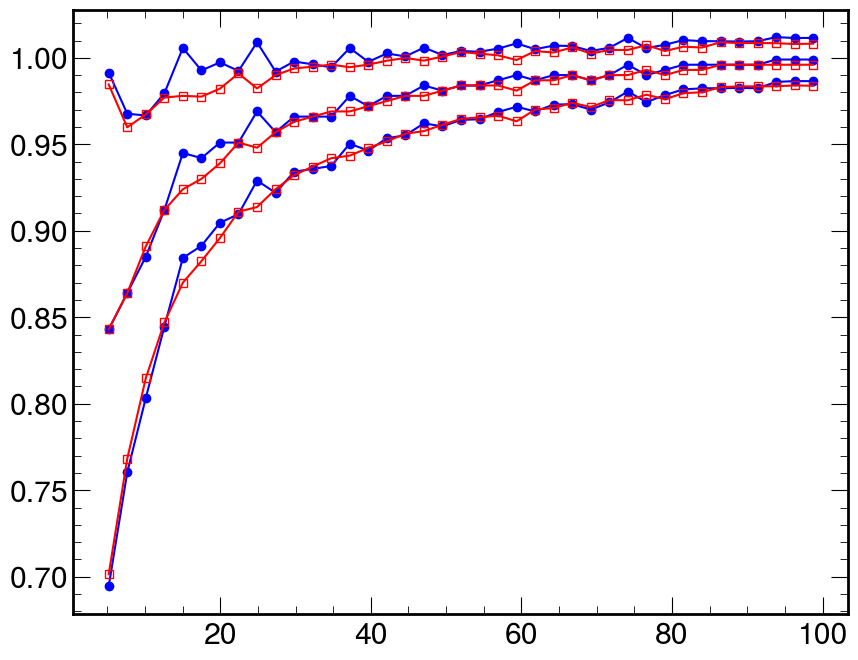

In [67]:
fig, ax = plt.subplots(1,1, figsize=(10,8), dpi=100)
offset = +1.2
ax.plot(bins[res_m.et_bin]+offset, res_m.m, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_u, marker="o", color="b")
ax.plot(bins[res_m.et_bin]+offset, res_m.w68_d, marker="o", color="b")

ax.plot(bins[res_d.et_bin]+offset, res_d.m, marker="s", markerfacecolor='none', c="r", )
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_u, marker="s", markerfacecolor='none', c="r",)
ax.plot(bins[res_d.et_bin]+offset, res_d.w68_d, marker="s", markerfacecolor='none', c="r")

# Resolution

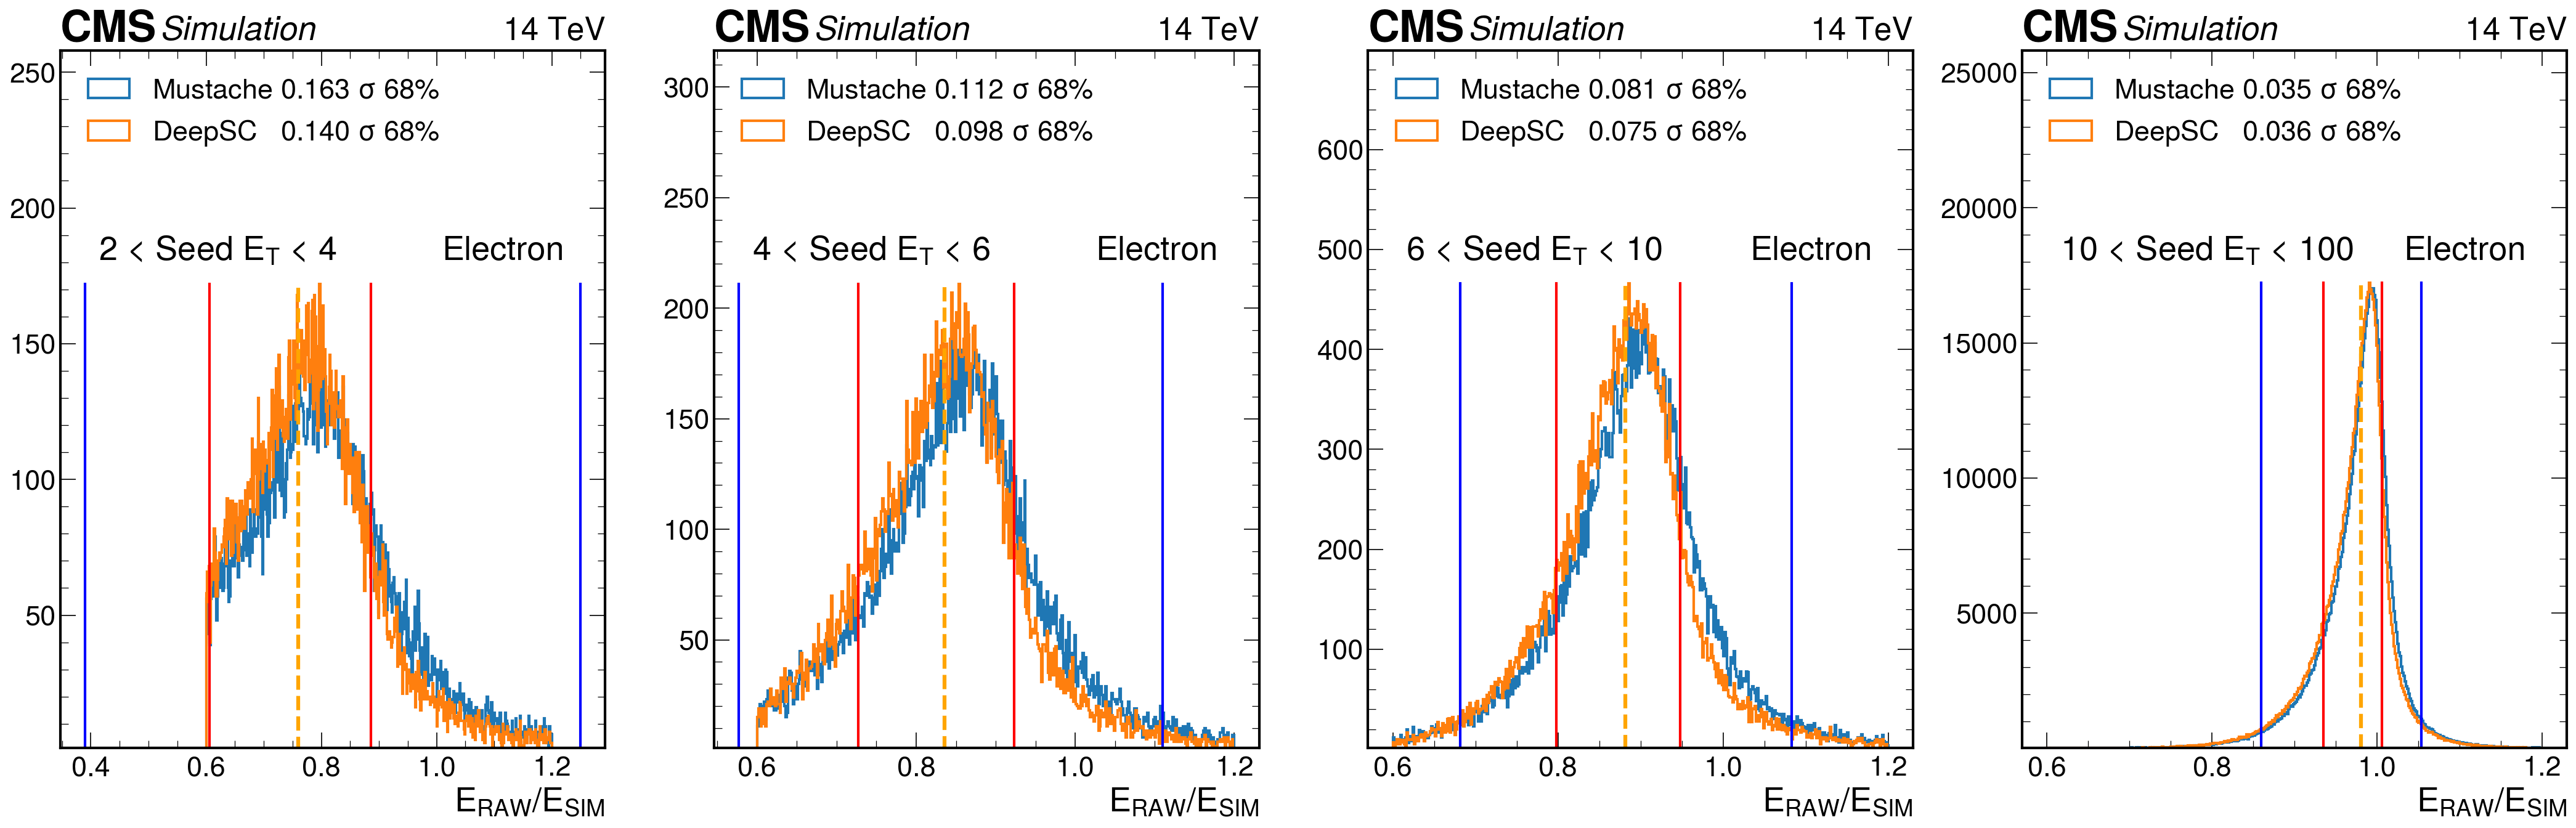

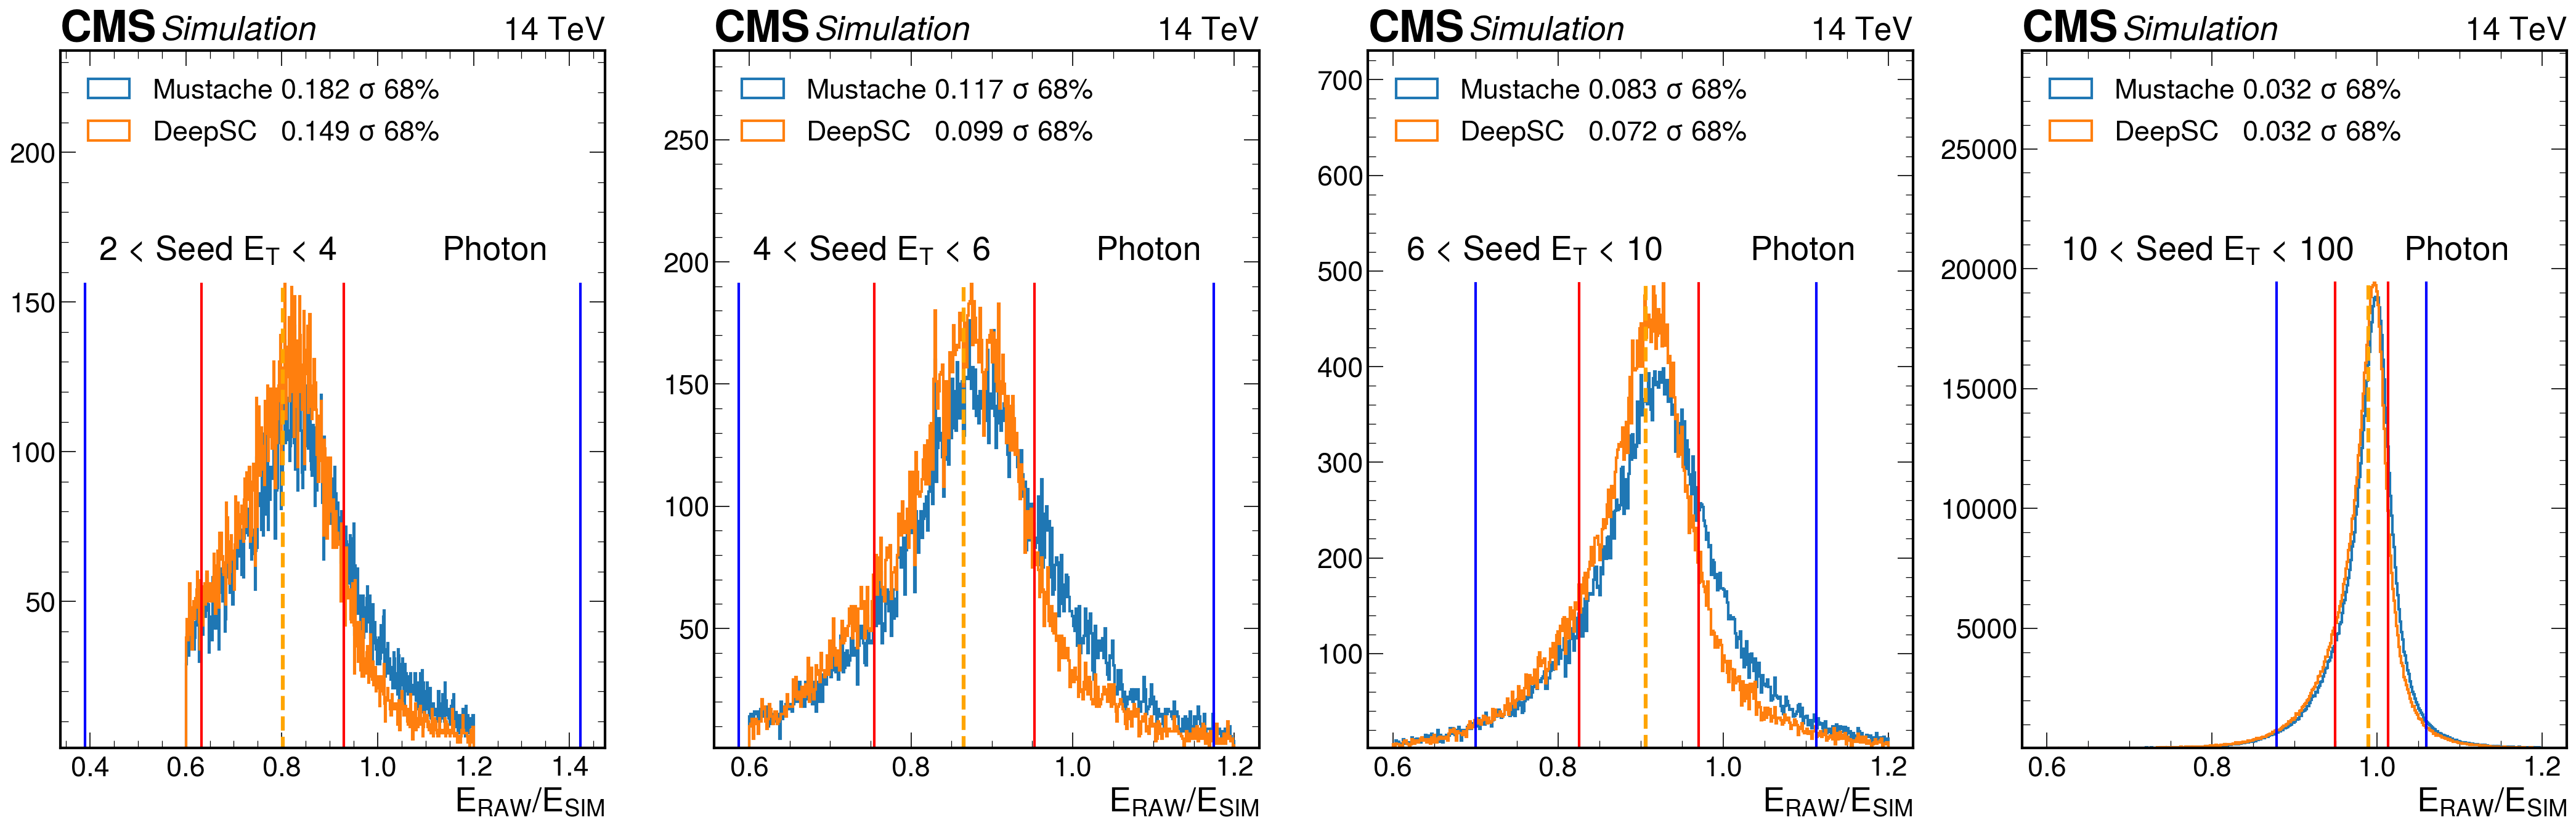

In [160]:
for df, flavour in zip([df_ele,df_gamma],["Electron","Photon"]):

    fig, ax = plt.subplots(1,4, figsize=(35,10),dpi=150)

    xrange = (0.6, 1.2)
    bins= 400

    r = [2,4,6,10,100]
    s = [[]]
    for i in range(len(r)-1):
        line = i //4 
        s[line].append((r[i],r[i+1]))

    for j,ss in enumerate(s): 
        for i, (e1,e2) in enumerate(ss): 
            dfx = df[(abs(df.et_seed)>=e1) & (abs(df.et_seed)<e2)]

            width, width_2 = get_sigma_eff(dfx.En_ovEtrue_sim_good)
            width_must, width_2_must = get_sigma_eff(dfx.En_ovEtrue_sim_good_mustache)
            
            a,b,c,d,e = get_quantiles(dfx.En_ovEtrue_sim_good)
            
    #         rms_regr = dfx.En_ovEtrue_gen_corr.std()

            ax[i].hist(dfx.En_ovEtrue_sim_good_mustache,bins=bins, range=xrange,histtype='step', linewidth=2, label='Mustache {:.3f} $\sigma$ 68%'.format(width_must))
            A= ax[i].hist(dfx.En_ovEtrue_sim_good,bins=bins, range=xrange,histtype='step', linewidth=2, label='DeepSC   {:.3f} $\sigma$ 68%'.format(width))
    #         ax[j,i].hist(dfx.En_ovEtrue_gen_corr,bins=bins, range=xrange,histtype='step', linewidth=2, label='DeepSC +regre    RMS: {:.4f}'.format(rms_regr))
            

            maxY = np.max(A[0])
            
            ax[i].plot([a,a],[0,maxY], color="blue", linewidth=2)
            ax[i].plot([e,e],[0,maxY], color="blue", linewidth=2)
            ax[i].plot([b,b],[0,maxY], color="red", linewidth=2)
            ax[i].plot([d,d],[0,maxY], color="red", linewidth=2)
            ax[i].plot([c,c],[0,maxY], color="orange", linewidth=3, linestyle='dashed')
            
            ax[i].legend(loc="upper left")
    #         ax[j,i].set_yscale('log')
            ax[i].set_ylim(1, 1.5 * maxY)
            ax[i].set_xlabel("$E_{RAW}/E_{SIM}$")
            ax[i].text(0.07,0.7,  str(e1) + ' < Seed $E_T$ < ' + str(e2), transform = ax[i].transAxes)  
            ax[i].text(0.7, 0.7, flavour, transform=ax[i].transAxes)

            hep.cms.label(rlabel='14 TeV',loc=0, ax=ax[i])


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

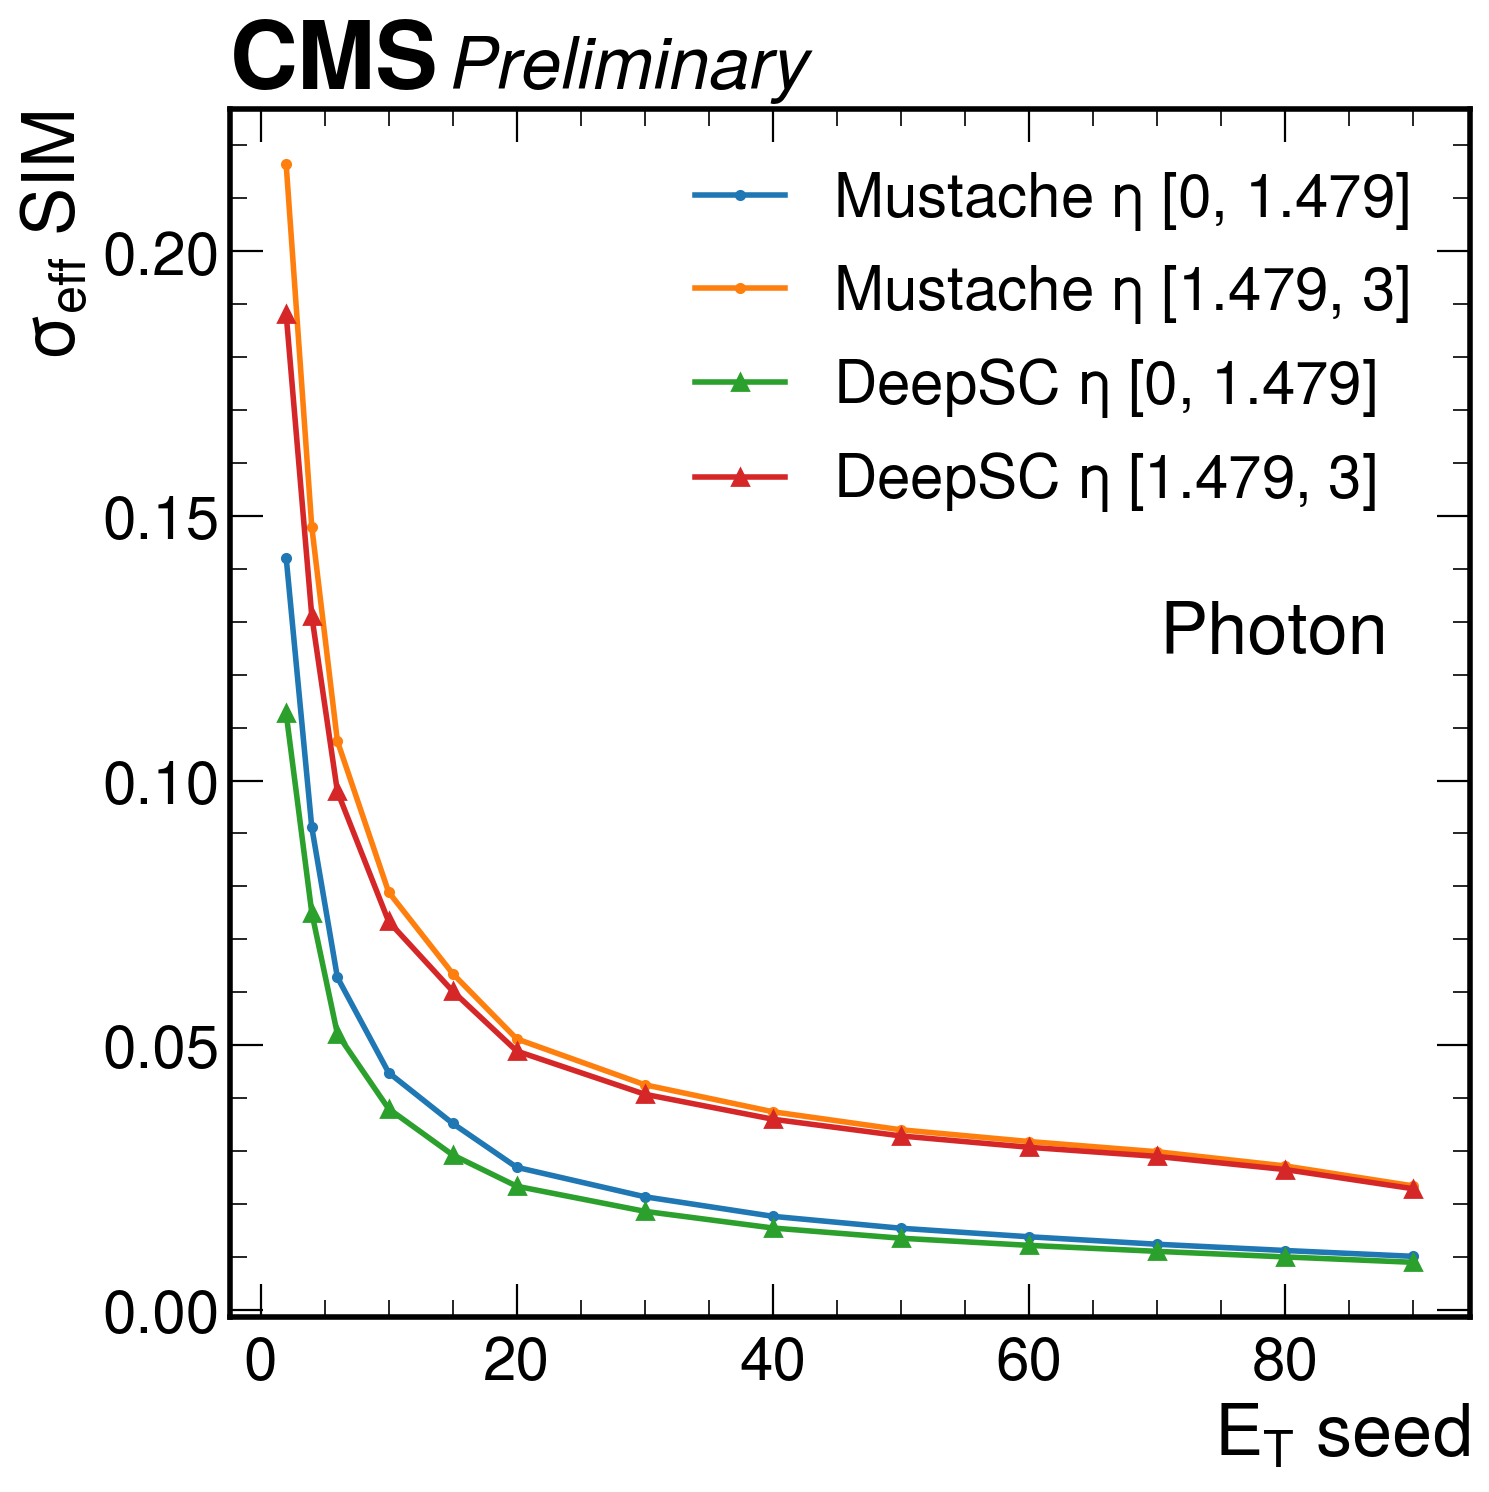

In [104]:
df = df_gamma
flavour = "Photon"
ets = [2, 4,6,10,15,20,30,40,50,60,70,80,90,100]
etas = [0, 1.479, 3]
df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)
res_must.reset_index(level=0, inplace=True)

fig, ax = plt.subplots(1,1, figsize=(8,8),dpi=200, )

for ieta, eta in enumerate(etas[:-1]):
    ax.plot(ets[:-1], res_must[res_must.eta_bin == ieta].w68,label="Mustache $\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), marker = ".", linewidth=2)

for ieta, eta in enumerate(etas[:-1]):
    ax.plot(ets[:-1], res[res.eta_bin == ieta].w68, label="DeepSC $\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), marker="^", linewidth=2)
    

# ax.set_ylim(0.7, 1.1)
ax.set_ylabel("$\sigma_{eff}$ SIM")
ax.legend(ncol=1)
ax.set_xlabel("$E_T$ seed")
# ax.plot([0,100],[1,1], linestyle="dashed", color="black")

ax.text(0.75, 0.55, flavour, transform=ax.transAxes)

hep.cms.text("Preliminary", loc=0, ax=ax)

# Resolution by Seed ET

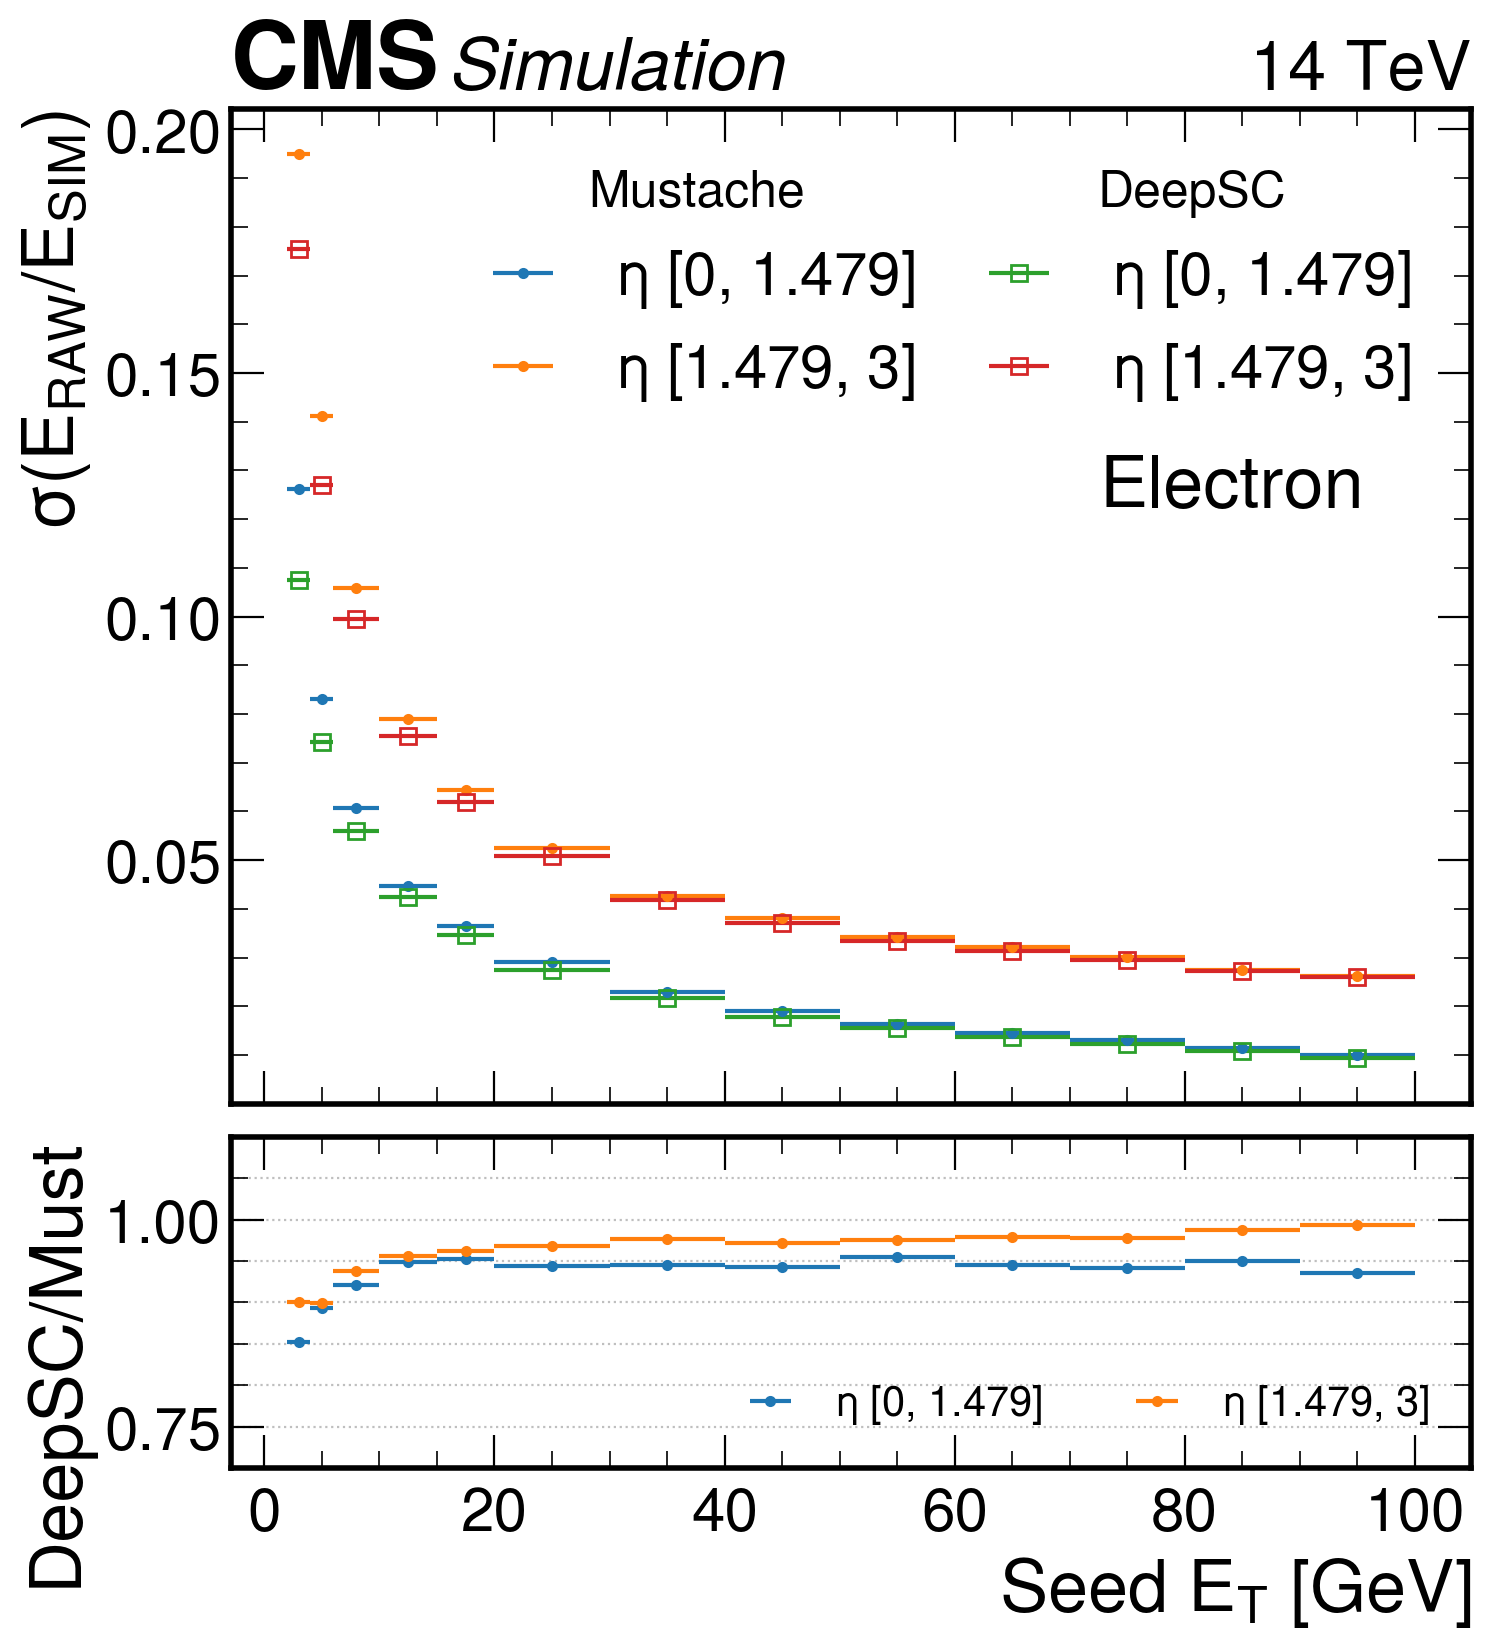

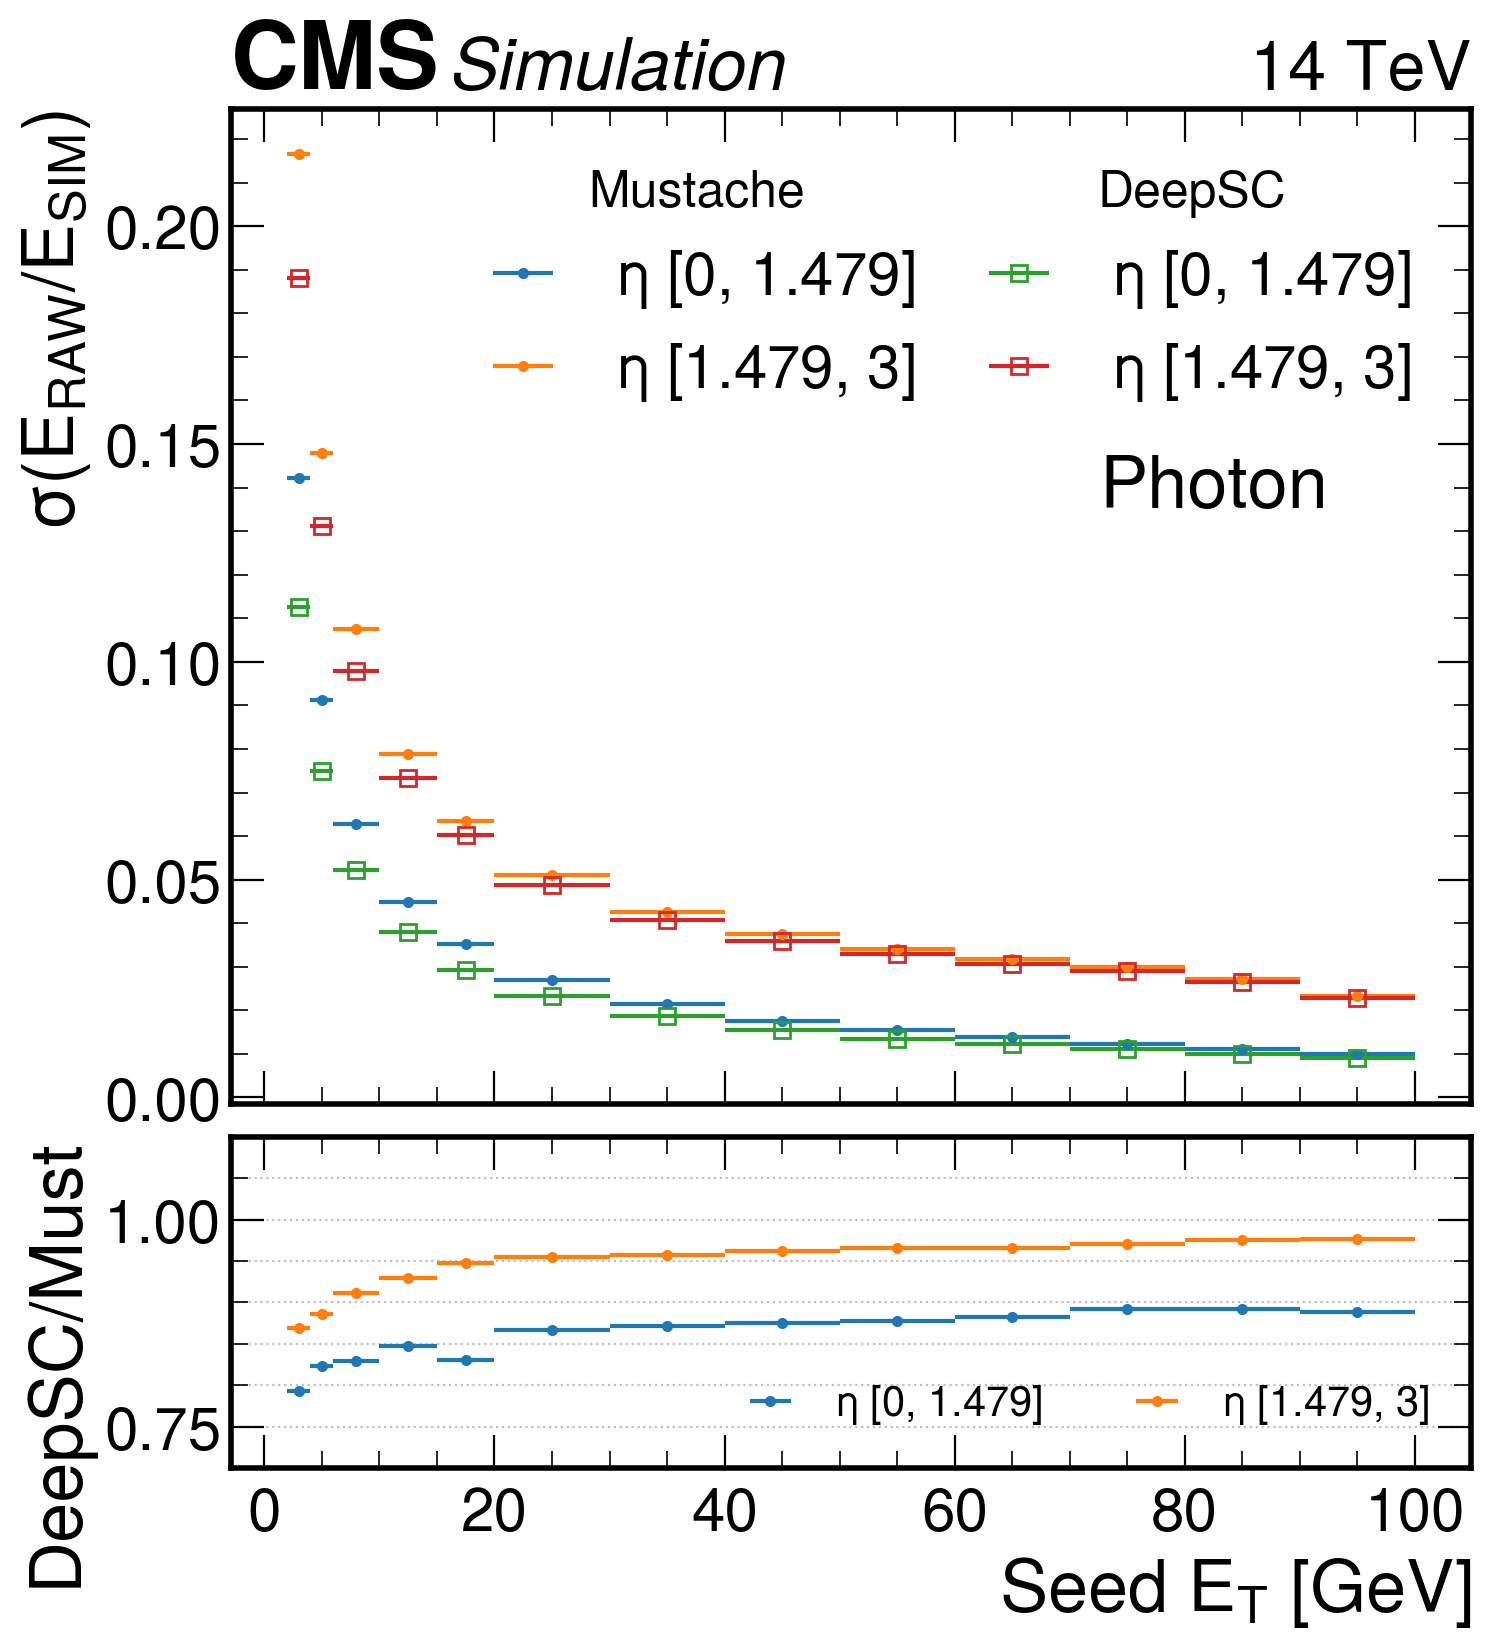

In [47]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
    ets = [2, 4,6,10,15,20,30,40,50,60,70,80,90,100]
    etas = [0, 1.479, 3]
    df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []

    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)

    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), marker="s", markerfacecolor='none', linestyle='none')
        deepl.append(l)

    for ieta, eta in enumerate(etas[:-1]):
        axs[1].errorbar(x, res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), 
                               fmt=".")

    # axs[0].errorbar(etas[:-1], rms.Et_ovEtrue_mustache, err_rms_must,  label="Mustache", linewidth=2)
    # axs[0].errorbar(etas[:-1], rms.Et_ovEtrue, err_rms_deep, label="DeepSC",linewidth=2)
    # axs[1].set_xlabel("Seed $E_T$")
    # axs[0].set_ylabel("RMS E/E true")
    # axs[0].legend(loc="upper right")
    # axs[0].set_ylim(0,rms.Et_ovEtrue_mustache.max()*1.2 )
    axs[0].set_ylabel("$\sigma (E_{RAW}/E_{SIM})$")

    axs[1].set_xlabel("Seed $E_T$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")

    axs[1].set_ylim(0.7, 1.1)
    axs[1].set_ylabel("DeepSC/Must")
    axs[1].legend(ncol=2, loc="lower right", fontsize=15)

    axs[0].text(0.7, 0.6, flavour, transform=axs[0].transAxes)


    l1= axs[0].legend(handles=mustl, title="Mustache", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1))
    axs[0].legend(handles=deepl, title="DeepSC", title_fontsize=18, loc="upper right")
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# Resolution by Gen ET

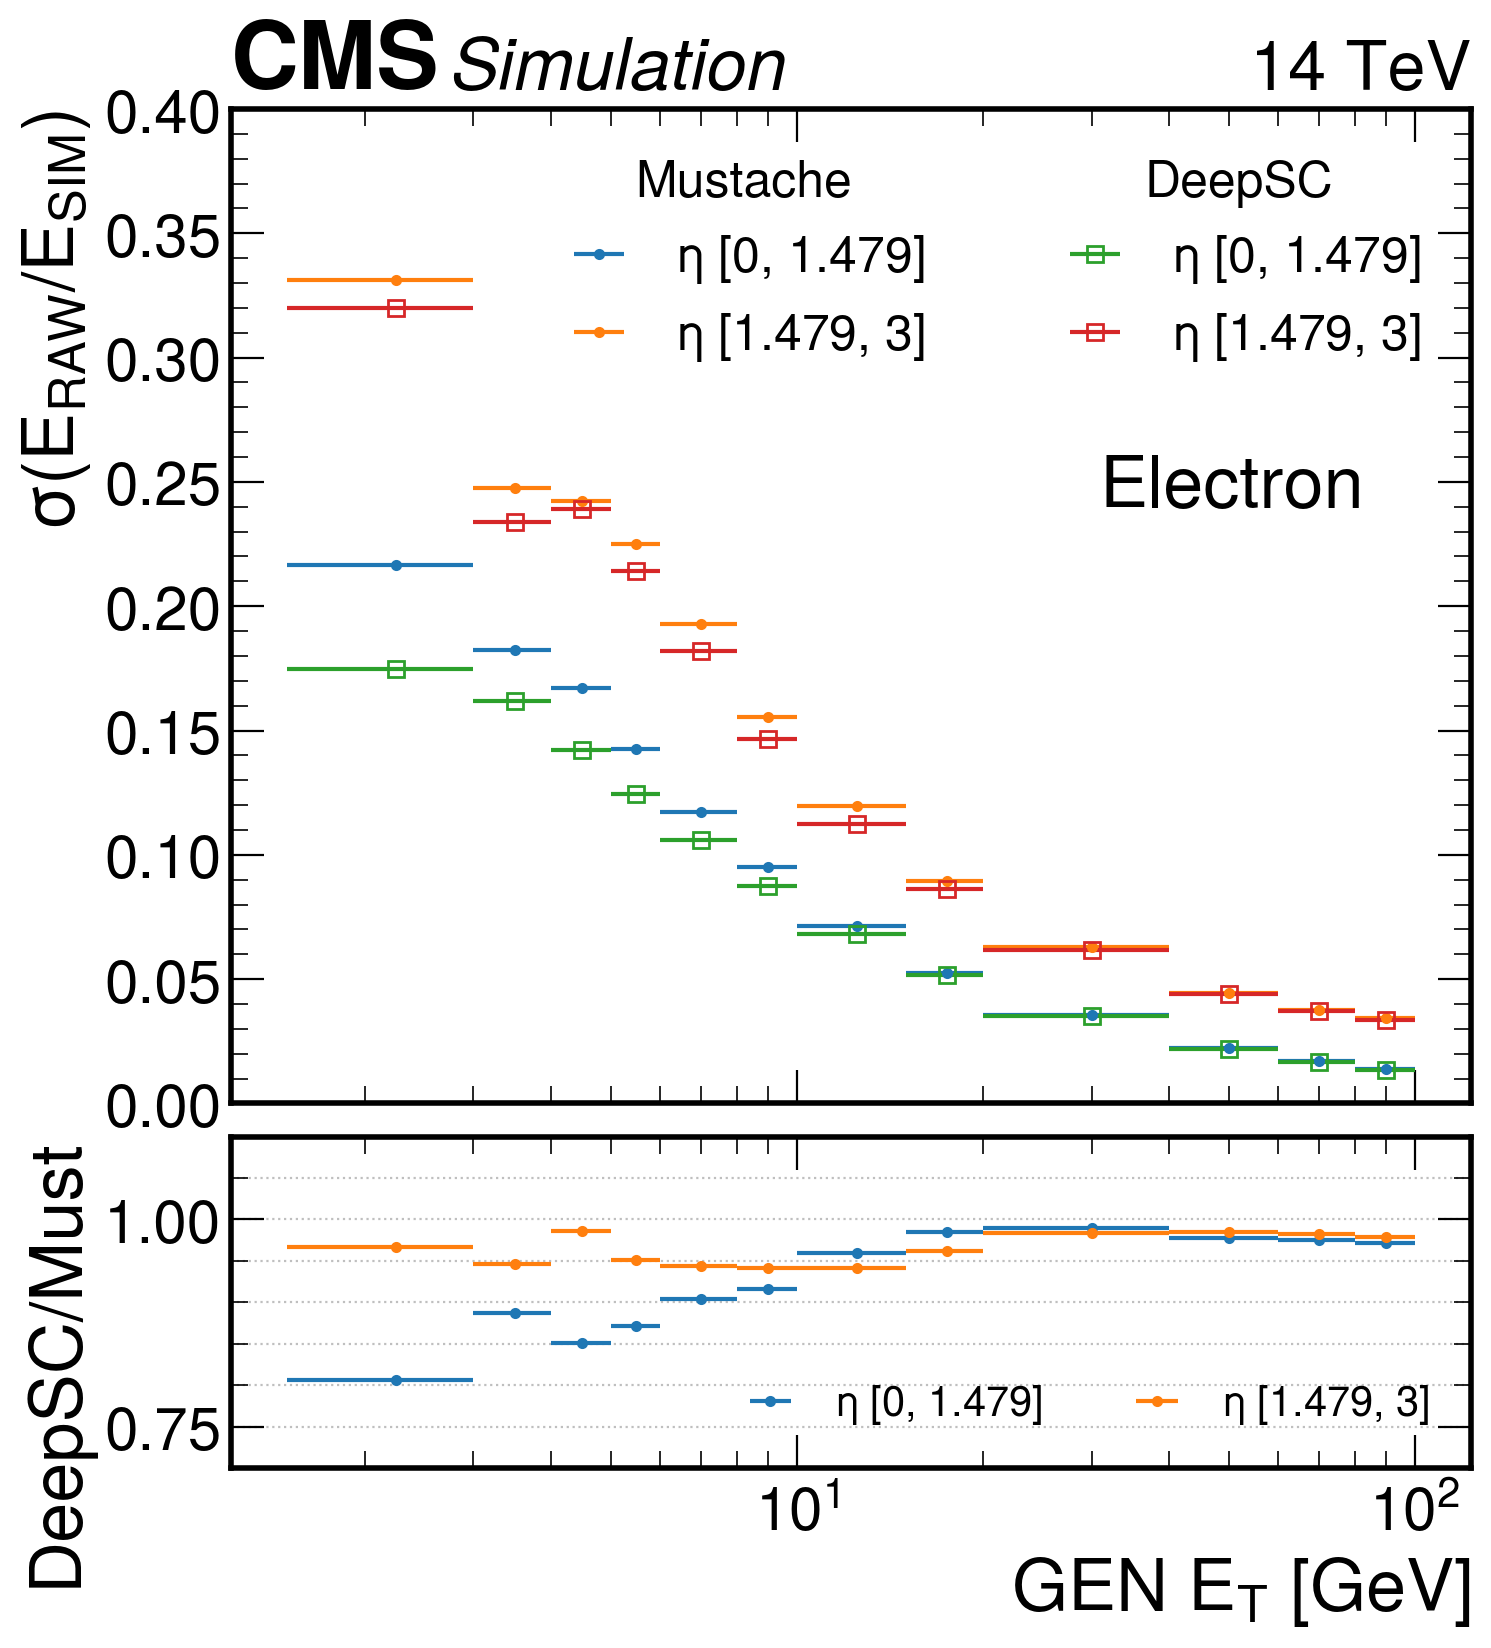

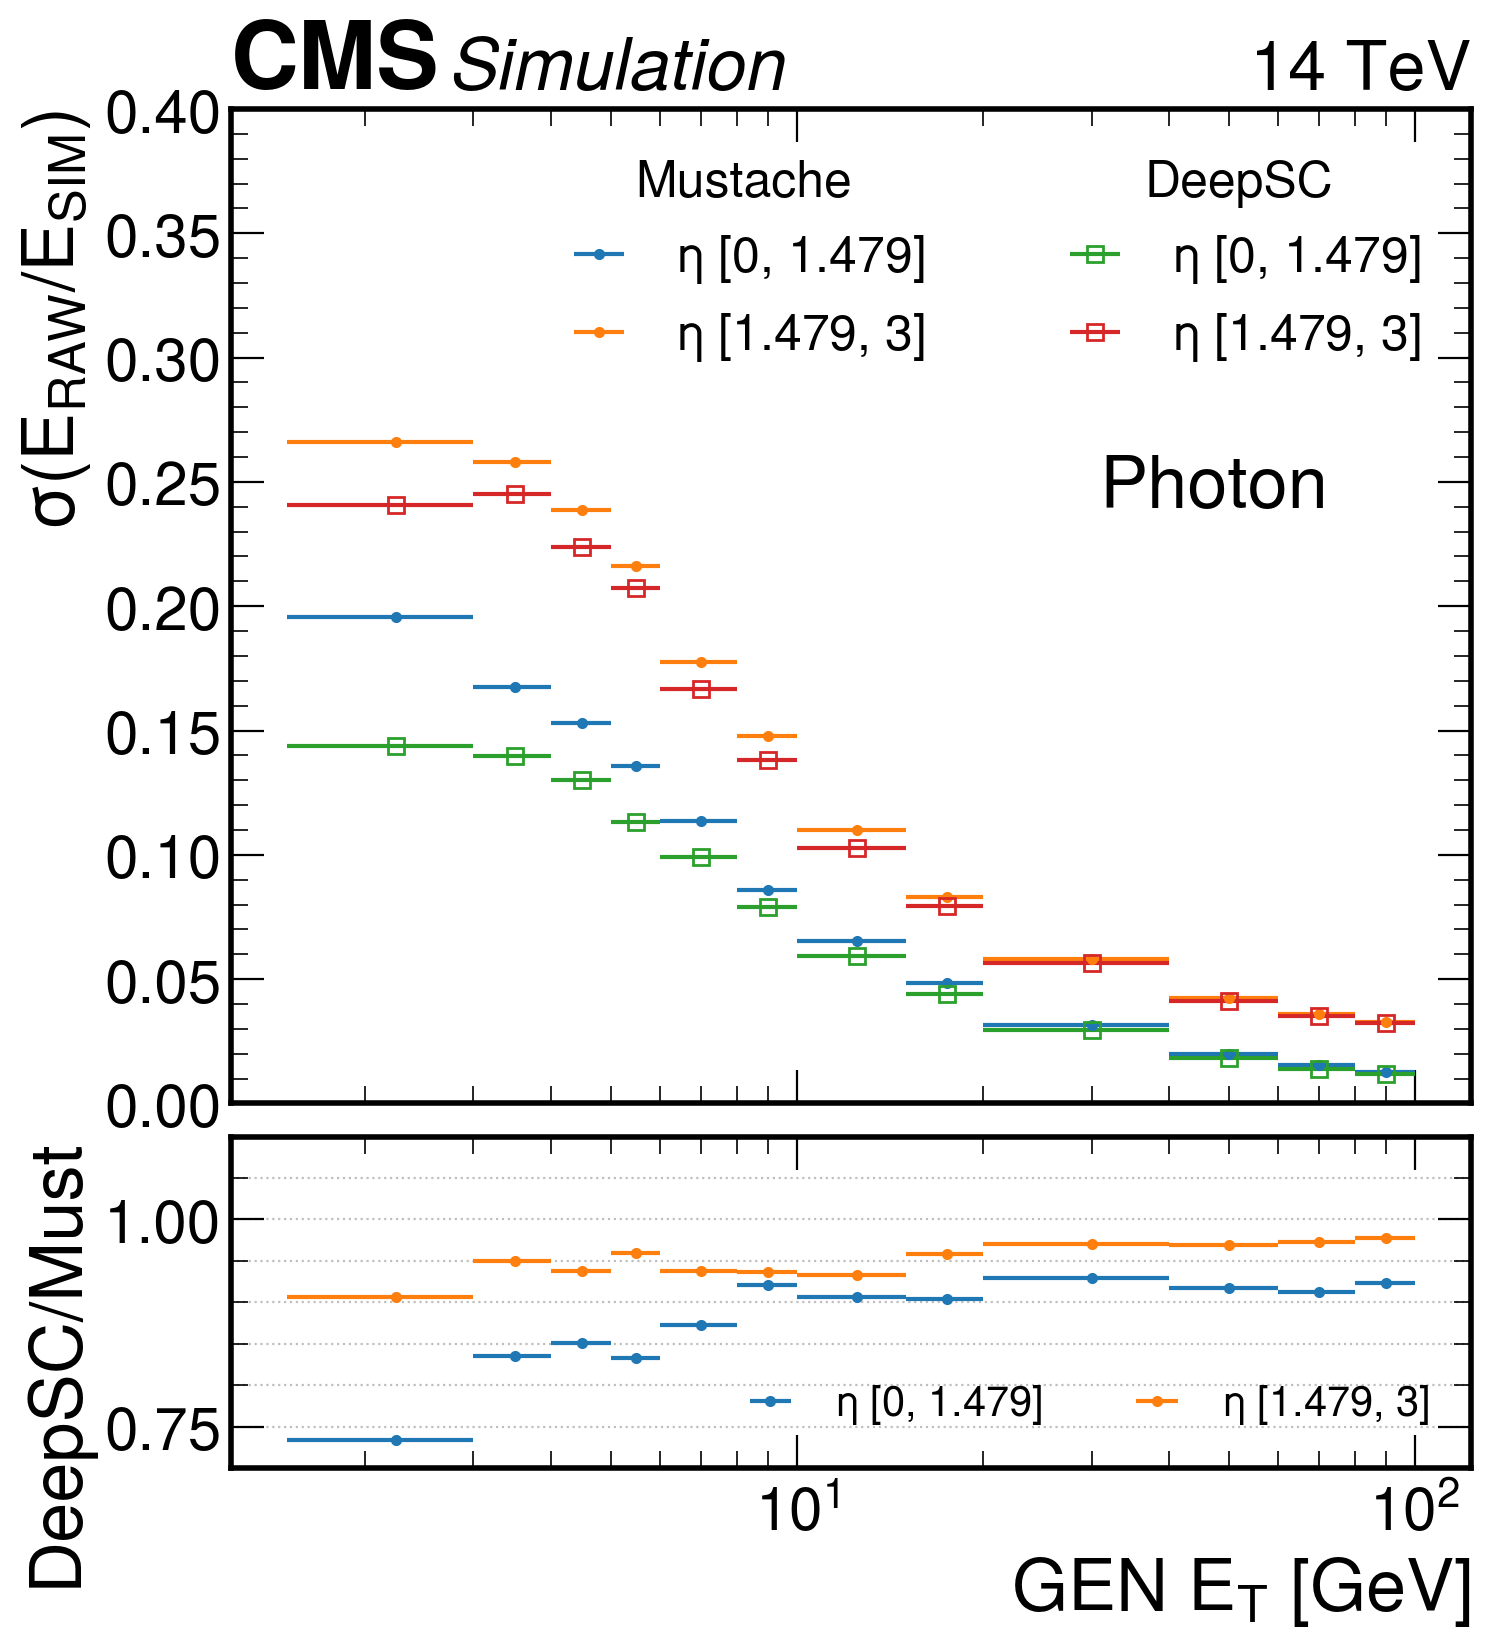

In [60]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
    ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    etas = [0, 1.479, 3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []

    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)

    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), marker="s", markerfacecolor='none', linestyle='none')
        deepl.append(l)

    for ieta, eta in enumerate(etas[:-1]):
        axs[1].errorbar(x, res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), 
                               fmt=".")

    # axs[0].errorbar(etas[:-1], rms.Et_ovEtrue_mustache, err_rms_must,  label="Mustache", linewidth=2)
    # axs[0].errorbar(etas[:-1], rms.Et_ovEtrue, err_rms_deep, label="DeepSC",linewidth=2)
    # axs[1].set_xlabel("Seed $E_T$")
    # axs[0].set_ylabel("RMS E/E true")
    # axs[0].legend(loc="upper right")
    # axs[0].set_ylim(0,rms.Et_ovEtrue_mustache.max()*1.2 )
    axs[0].set_ylabel("$\sigma (E_{RAW}/E_{SIM})$")

    axs[1].set_xlabel("GEN $E_T$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(0, 0.4)
    axs[1].set_ylim(0.7, 1.1)
    axs[1].set_ylabel("DeepSC/Must")
    axs[1].legend(ncol=2, loc="lower right", fontsize=15)

    axs[0].text(0.7, 0.6, flavour, transform=axs[0].transAxes)
    axs[0].set_xscale("log")

    l1= axs[0].legend(handles=mustl, title="Mustache", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    axs[0].legend(handles=deepl, title="DeepSC", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# Resolution by GenET with relative improvement in quadrature

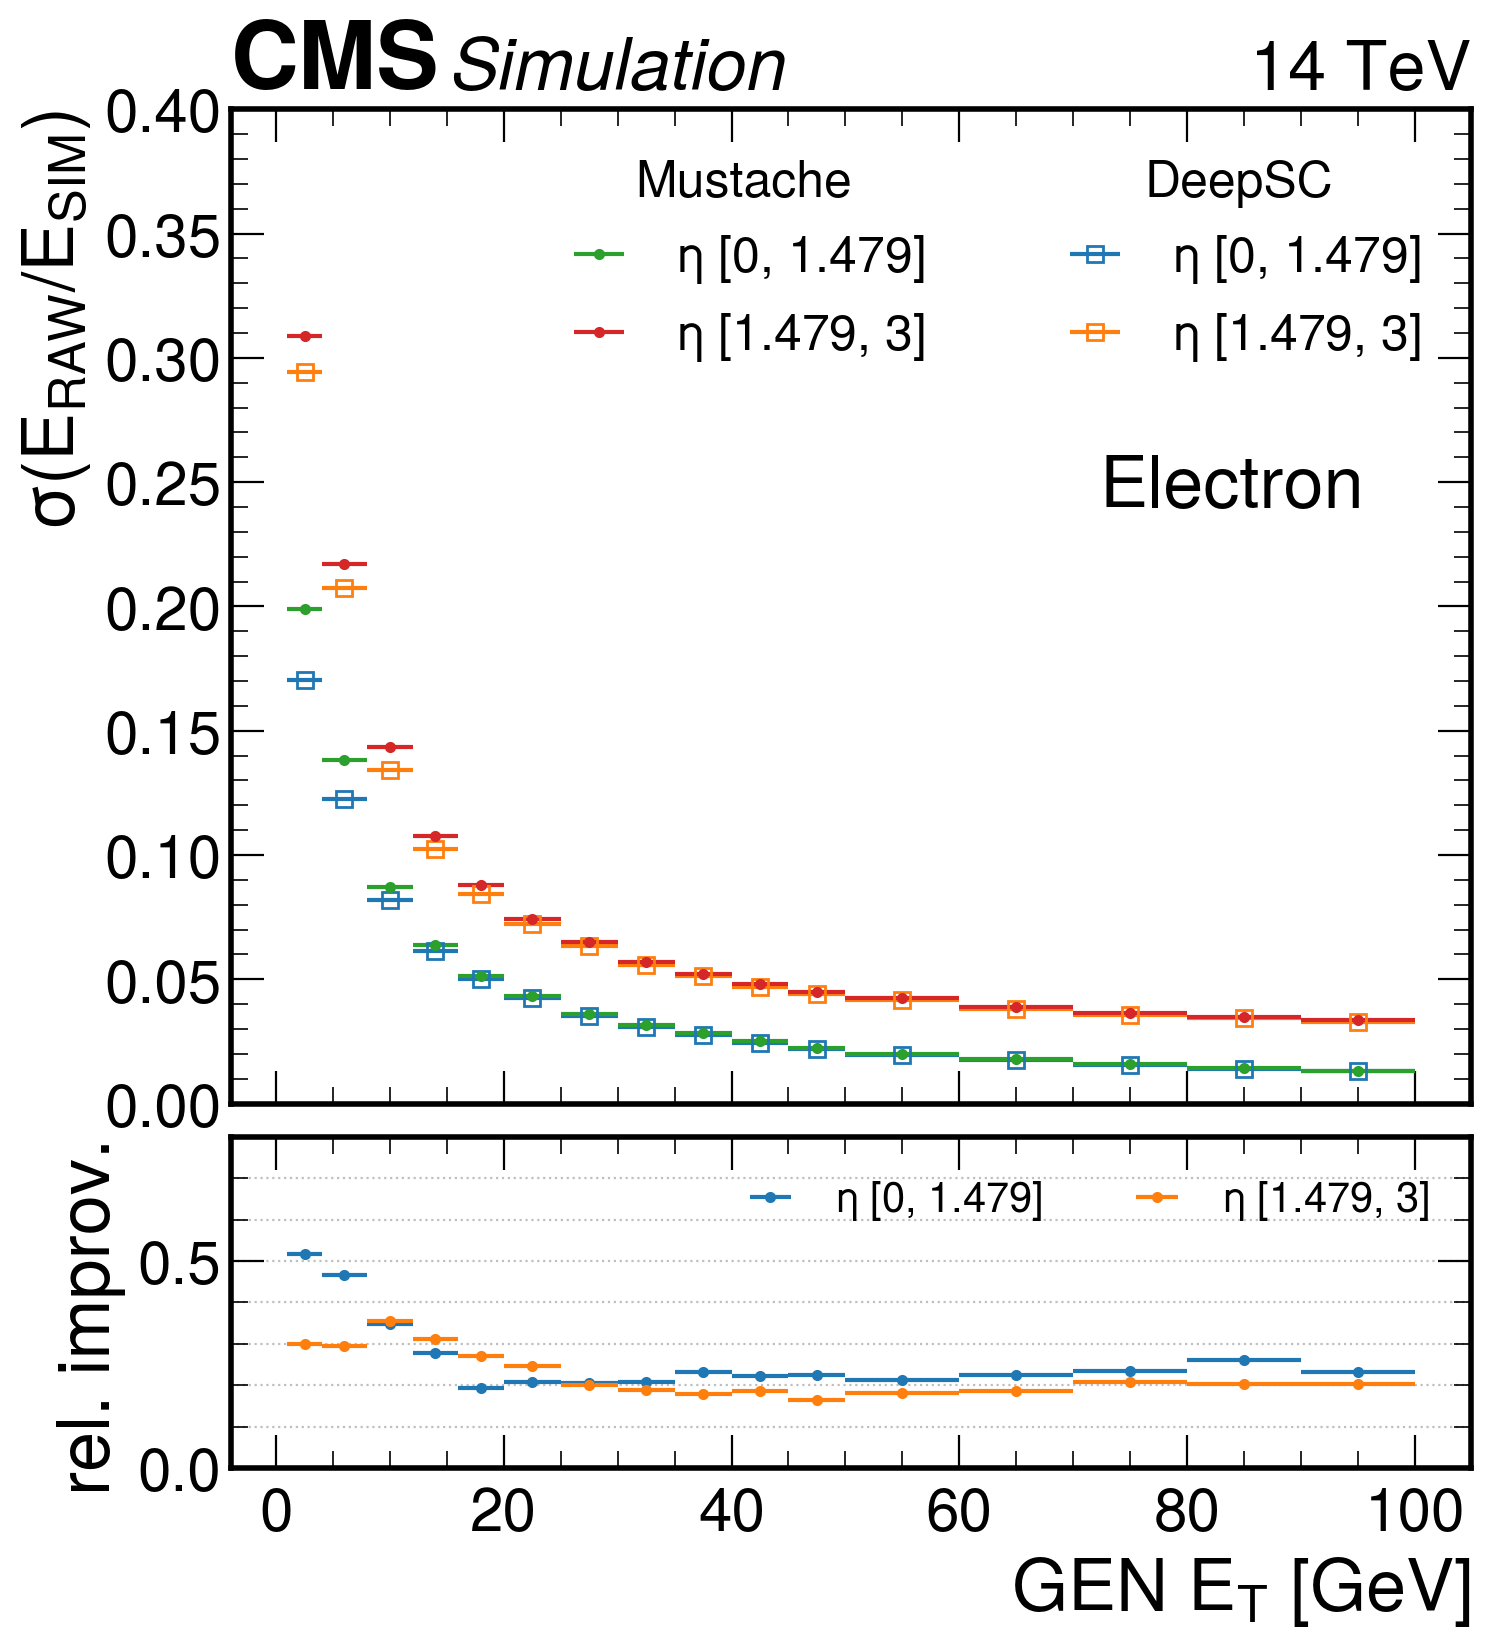

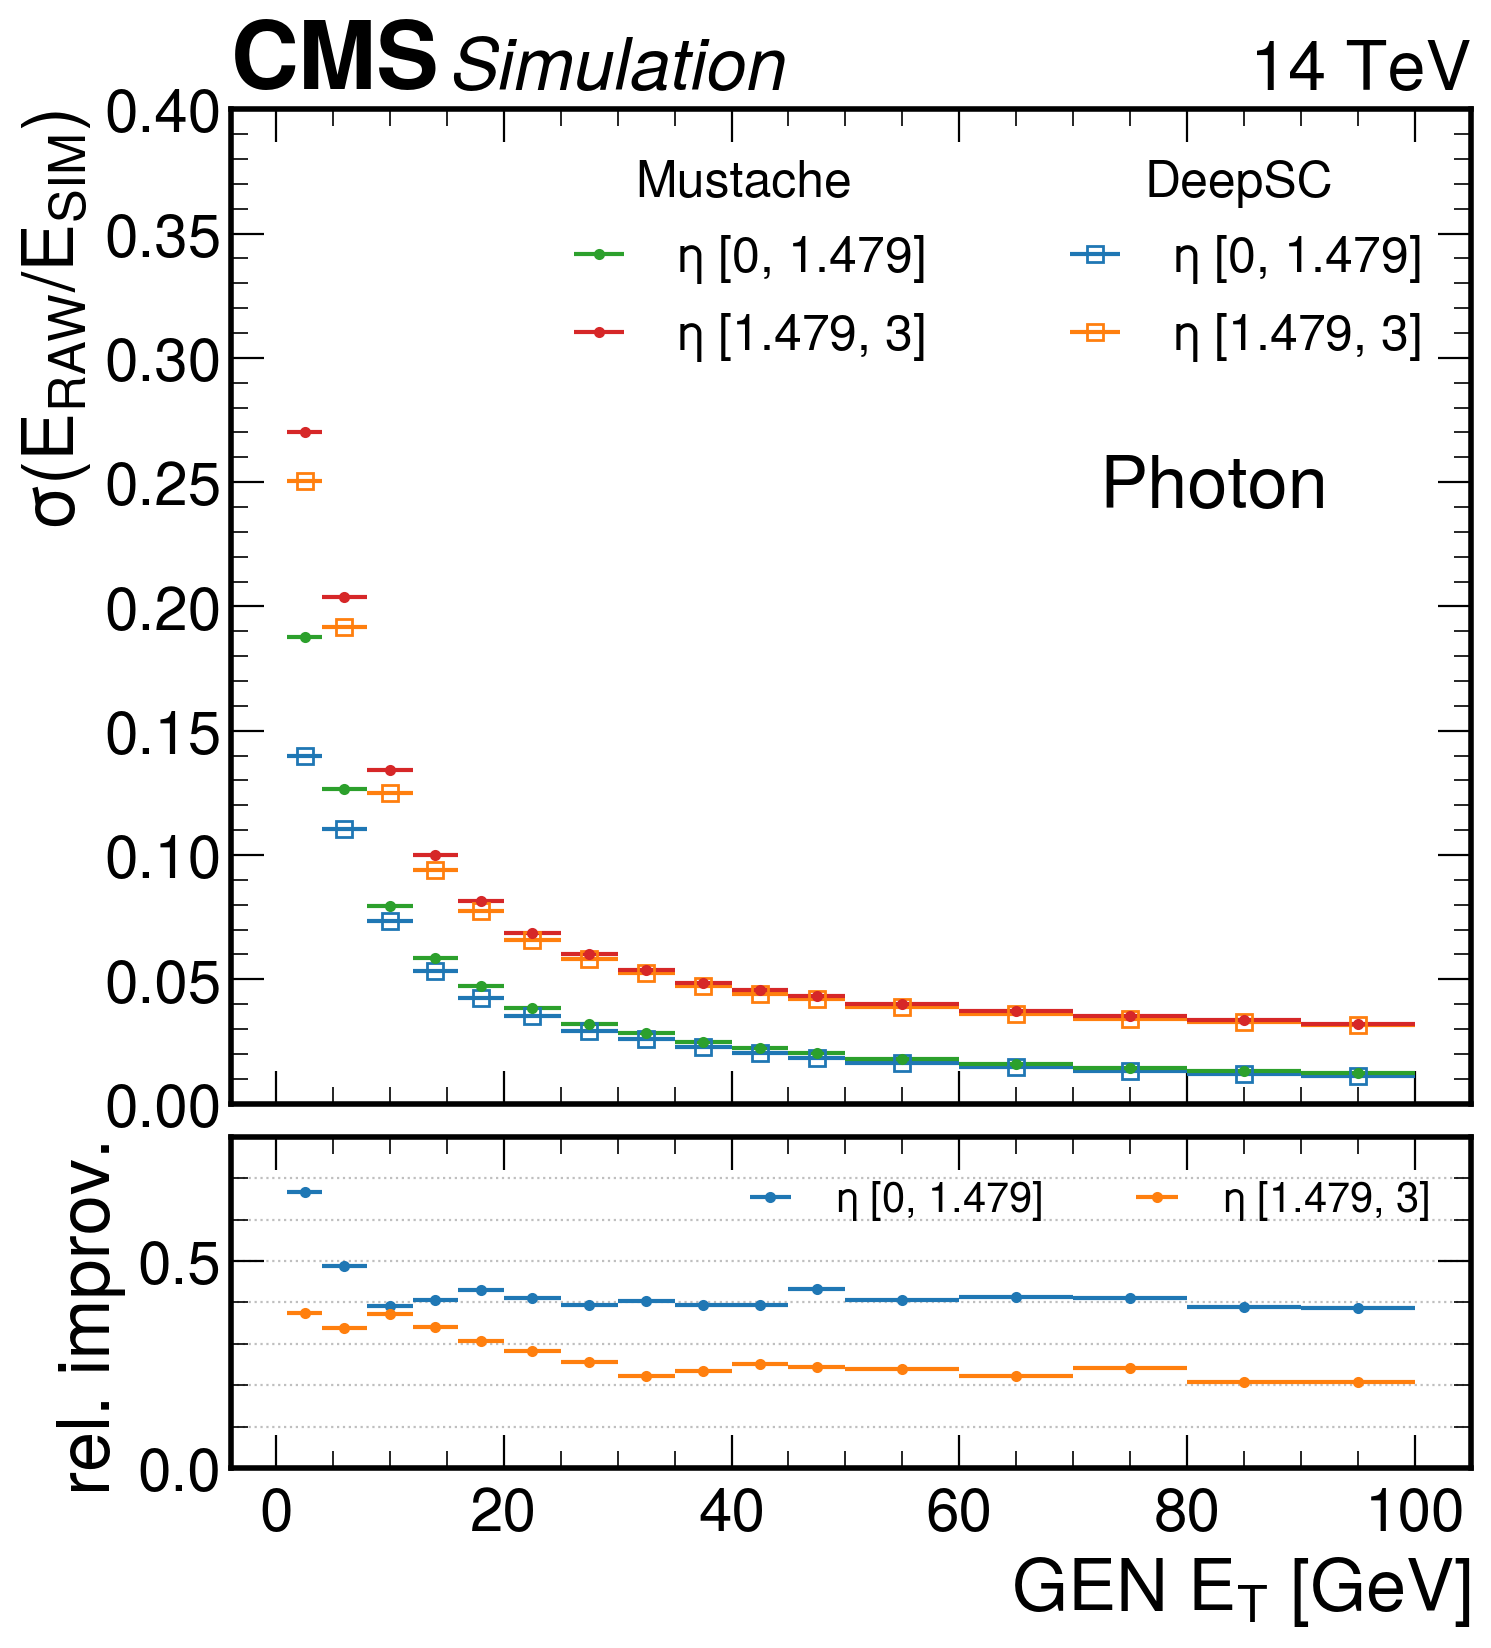

In [102]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [1.00, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    etas = [0, 1.479, 3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []

    
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), marker="s", markerfacecolor='none', linestyle='none')
        deepl.append(l)
        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)

    

    for ieta, eta in enumerate(etas[:-1]):
        var = np.sqrt(res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2 ) / res_must[res_must.eta_bin == ieta].w68
        axs[1].errorbar(x, var, xerr=errx, label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), fmt=".")

    axs[0].set_ylabel("$\sigma (E_{RAW}/E_{SIM})$")

    axs[1].set_xlabel("GEN $E_T$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(0, 0.4)
    axs[1].set_ylim(0., 0.8)
    axs[1].set_ylabel("rel. improv.")
    axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.7, 0.6, flavour, transform=axs[0].transAxes)
#     axs[0].set_xscale("log")

    l1= axs[0].legend(handles=mustl, title="Mustache", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    axs[0].legend(handles=deepl, title="DeepSC", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# Resolution by Gen ET with rel improva and sigmaE

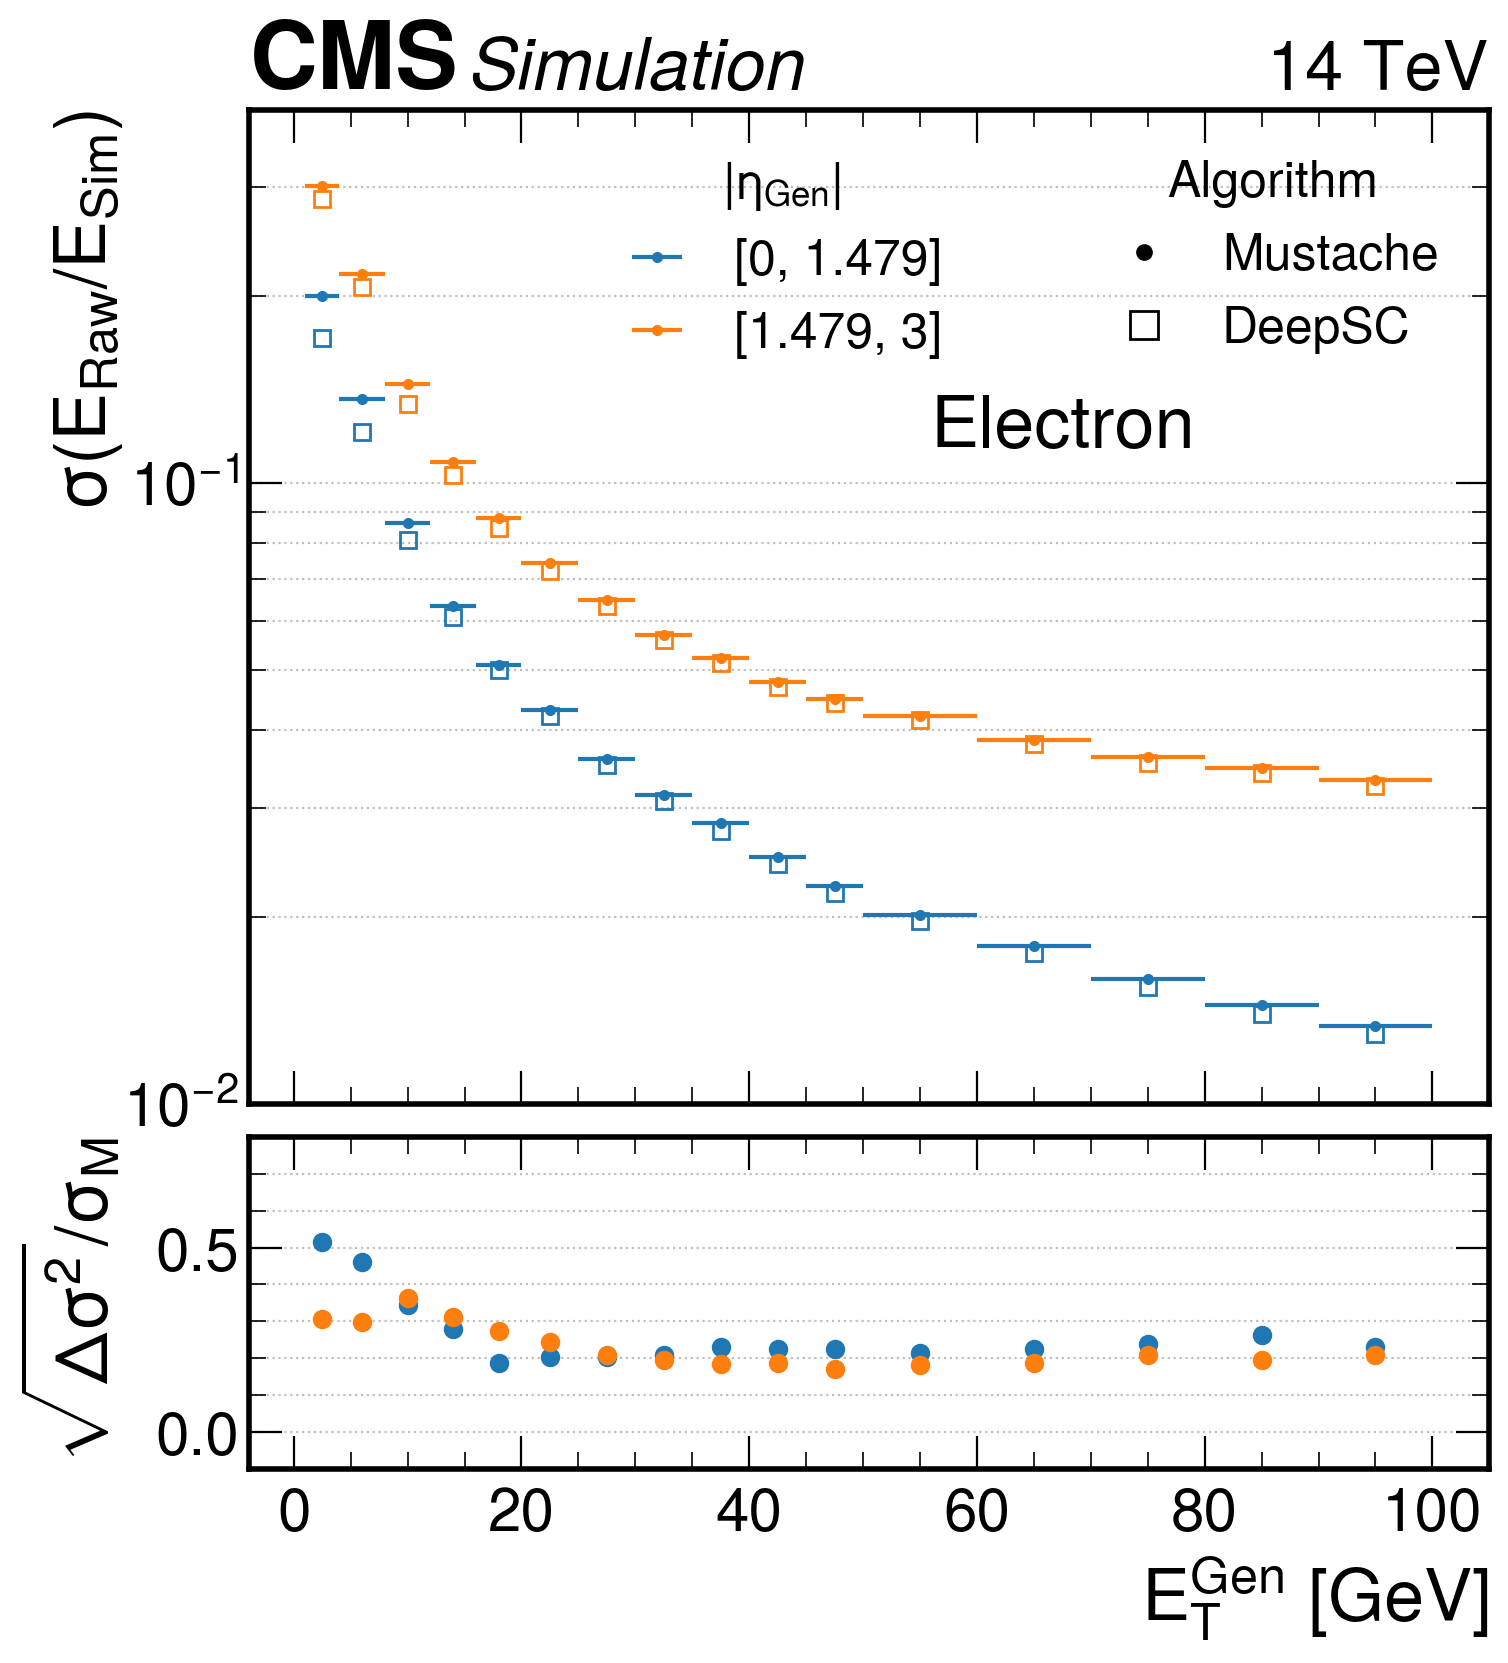

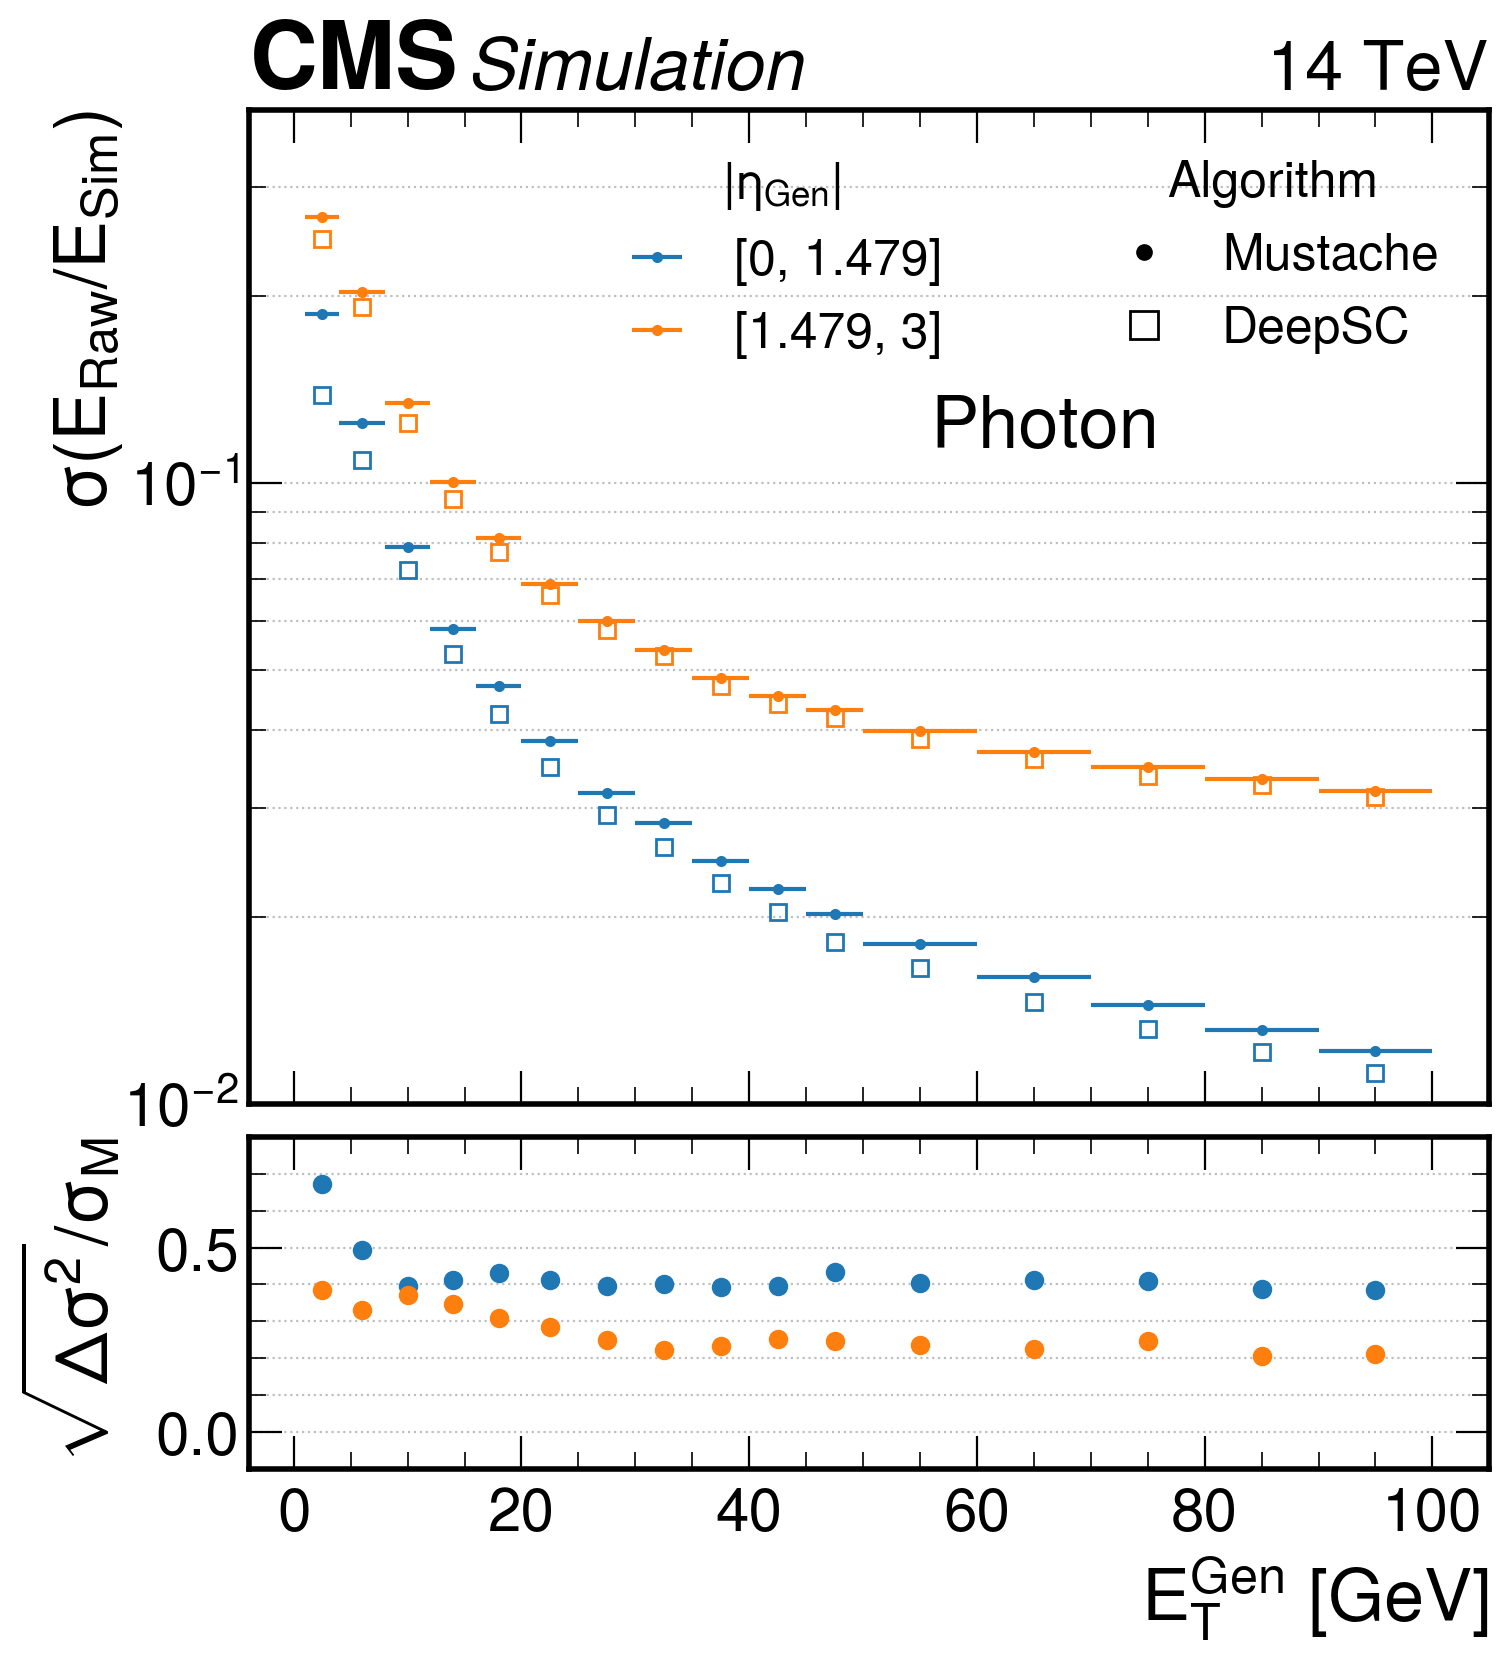

In [12]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [1.00, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    etas = [0, 1.479, 3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim_true_eta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []


        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)
        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="[{}, {}]".format(etas[ieta], etas[ieta+1]), 
                                marker="s", markerfacecolor='none', c=mustl[ieta].lines[0].get_color(), linestyle='none', elinewidth=0)
        deepl.append(l)
    

    for ieta, eta in enumerate(etas[:-1]):
        v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
        var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
        axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt="o", linestyle='none', elinewidth=0 )

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(1e-2, 0.4)
    axs[1].set_ylim(-0.1, 0.8)
    axs[1].set_ylabel("$\sqrt{\Delta\sigma^2}/\sigma_M$")
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.55, 0.66, flavour, transform=axs[0].transAxes)
    axs[0].set_yscale("log")

    l1= axs[0].legend(handles=mustl, title="$|\eta_{Gen}|$", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")
    axs[0].grid(axis="y", which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_byEnergy_{}.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_{}.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_{}.svg".format(flavour))

# Resolution by Gen ET with ratio of resolution

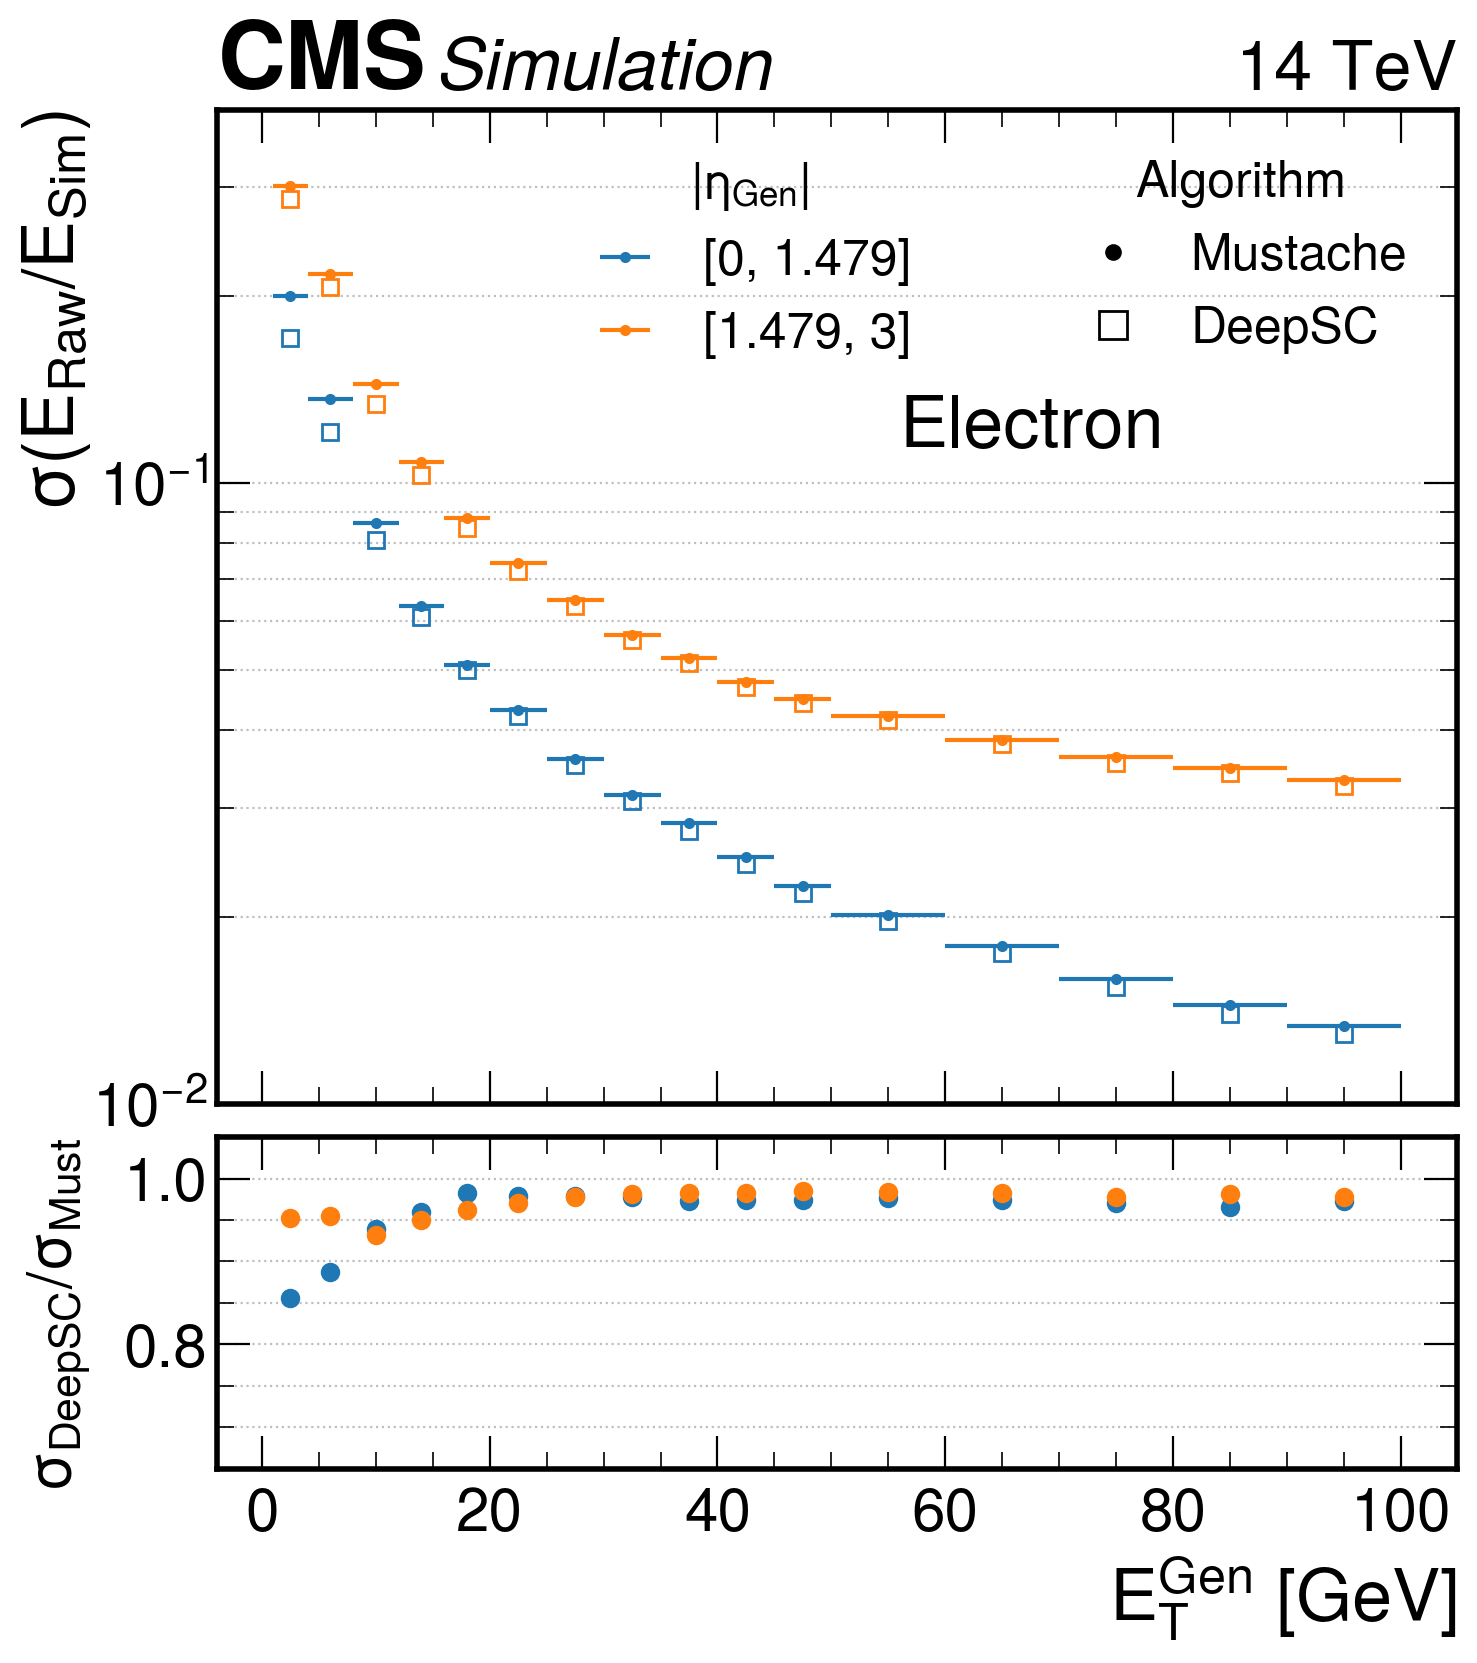

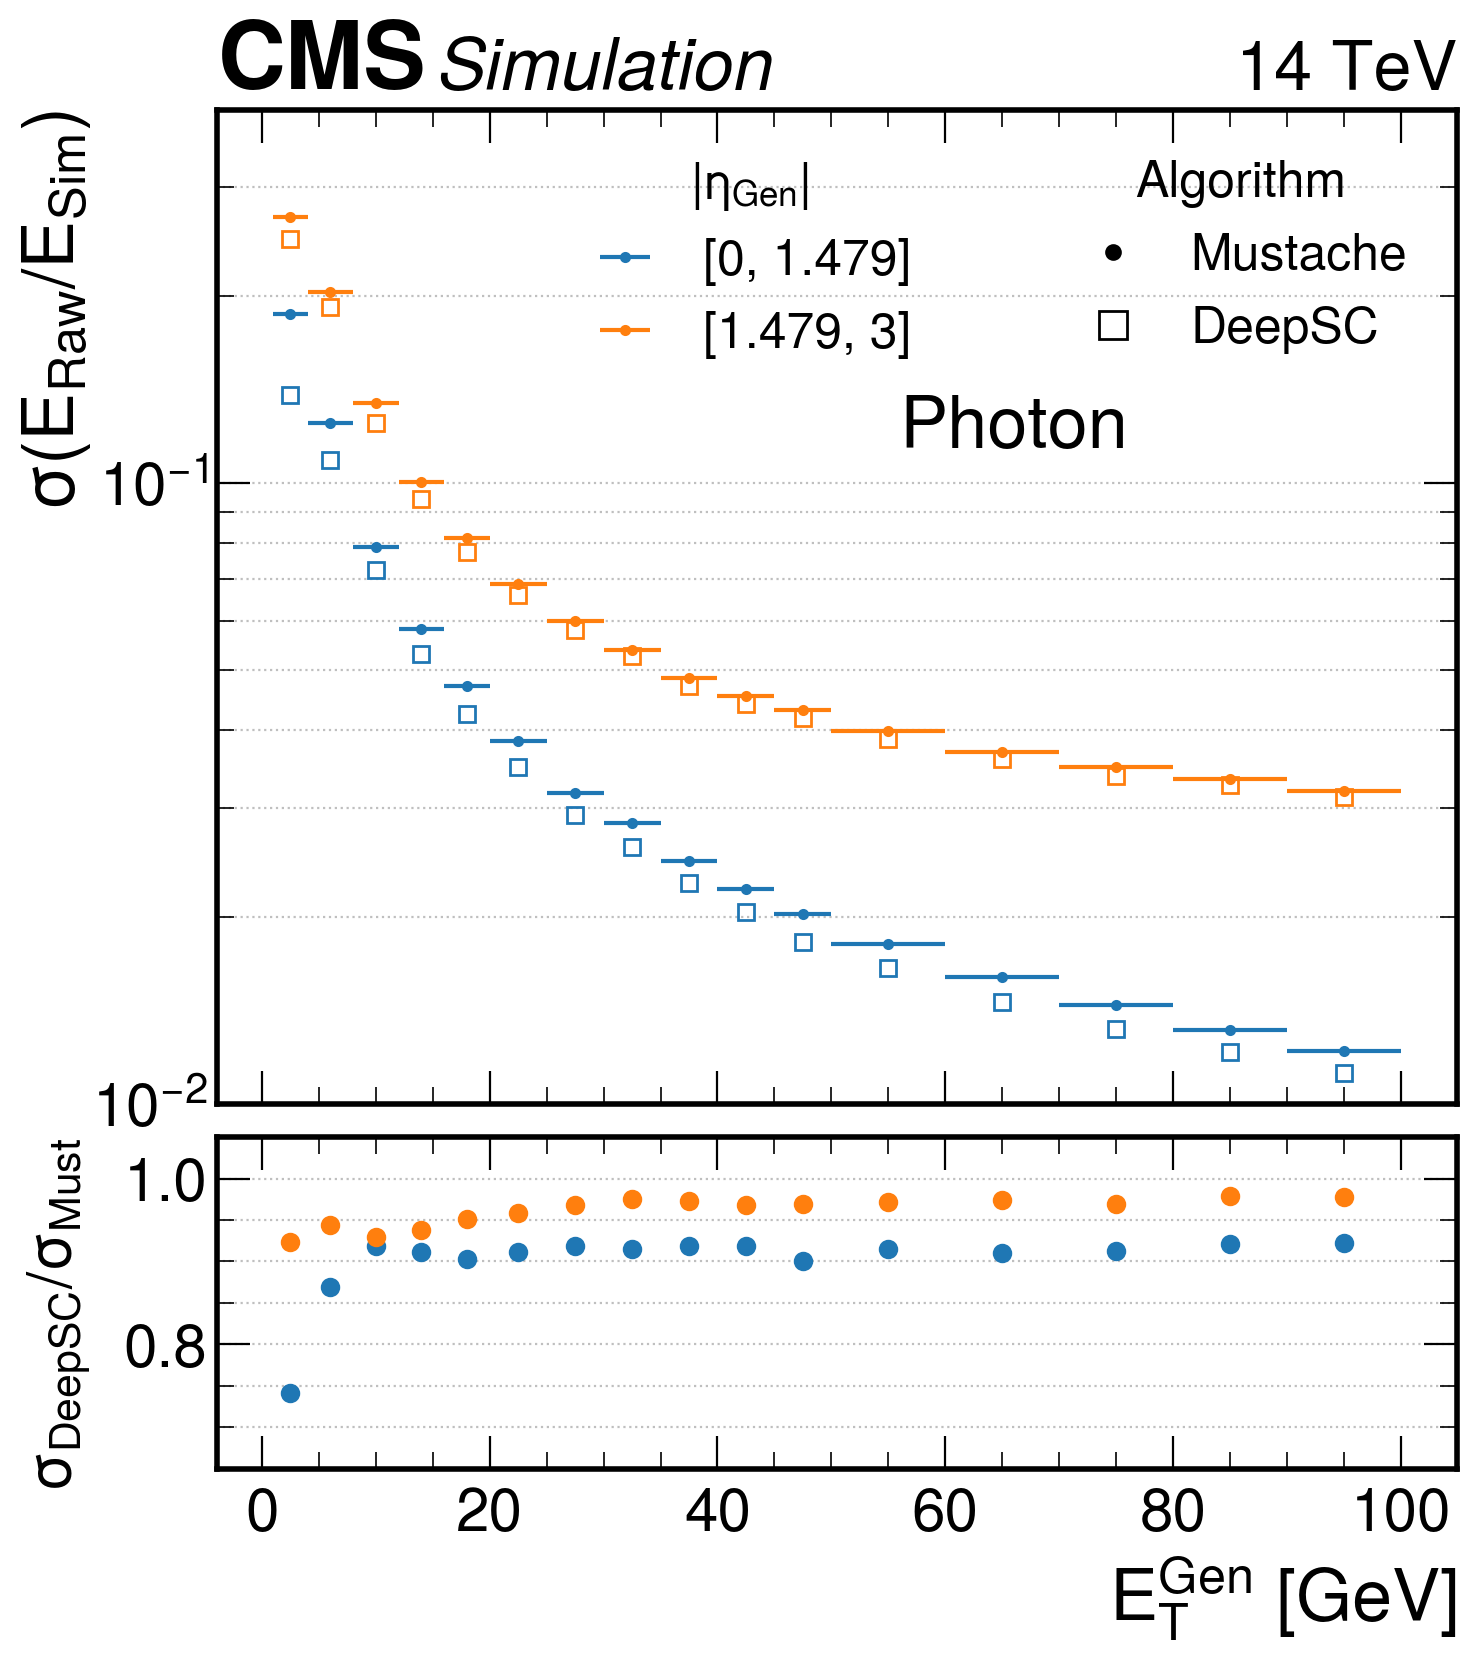

In [10]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [1.00, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    etas = [0, 1.479, 3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim_true_eta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []


        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)
        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="[{}, {}]".format(etas[ieta], etas[ieta+1]), 
                                marker="s", markerfacecolor='none', c=mustl[ieta].lines[0].get_color(), linestyle='none', elinewidth=0)
        deepl.append(l)
    

    for ieta, eta in enumerate(etas[:-1]):
#         v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
#         var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
        var = res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68
        axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt="o", linestyle='none', elinewidth=0 )

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(1e-2, 0.4)
    axs[1].set_ylim(0.65, 1.05)
    axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.55, 0.66, flavour, transform=axs[0].transAxes)
    axs[0].set_yscale("log")

    l1= axs[0].legend(handles=mustl, title="$|\eta_{Gen}|$", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")
    axs[0].grid(axis="y", which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.svg".format(flavour))

### Central quantiles

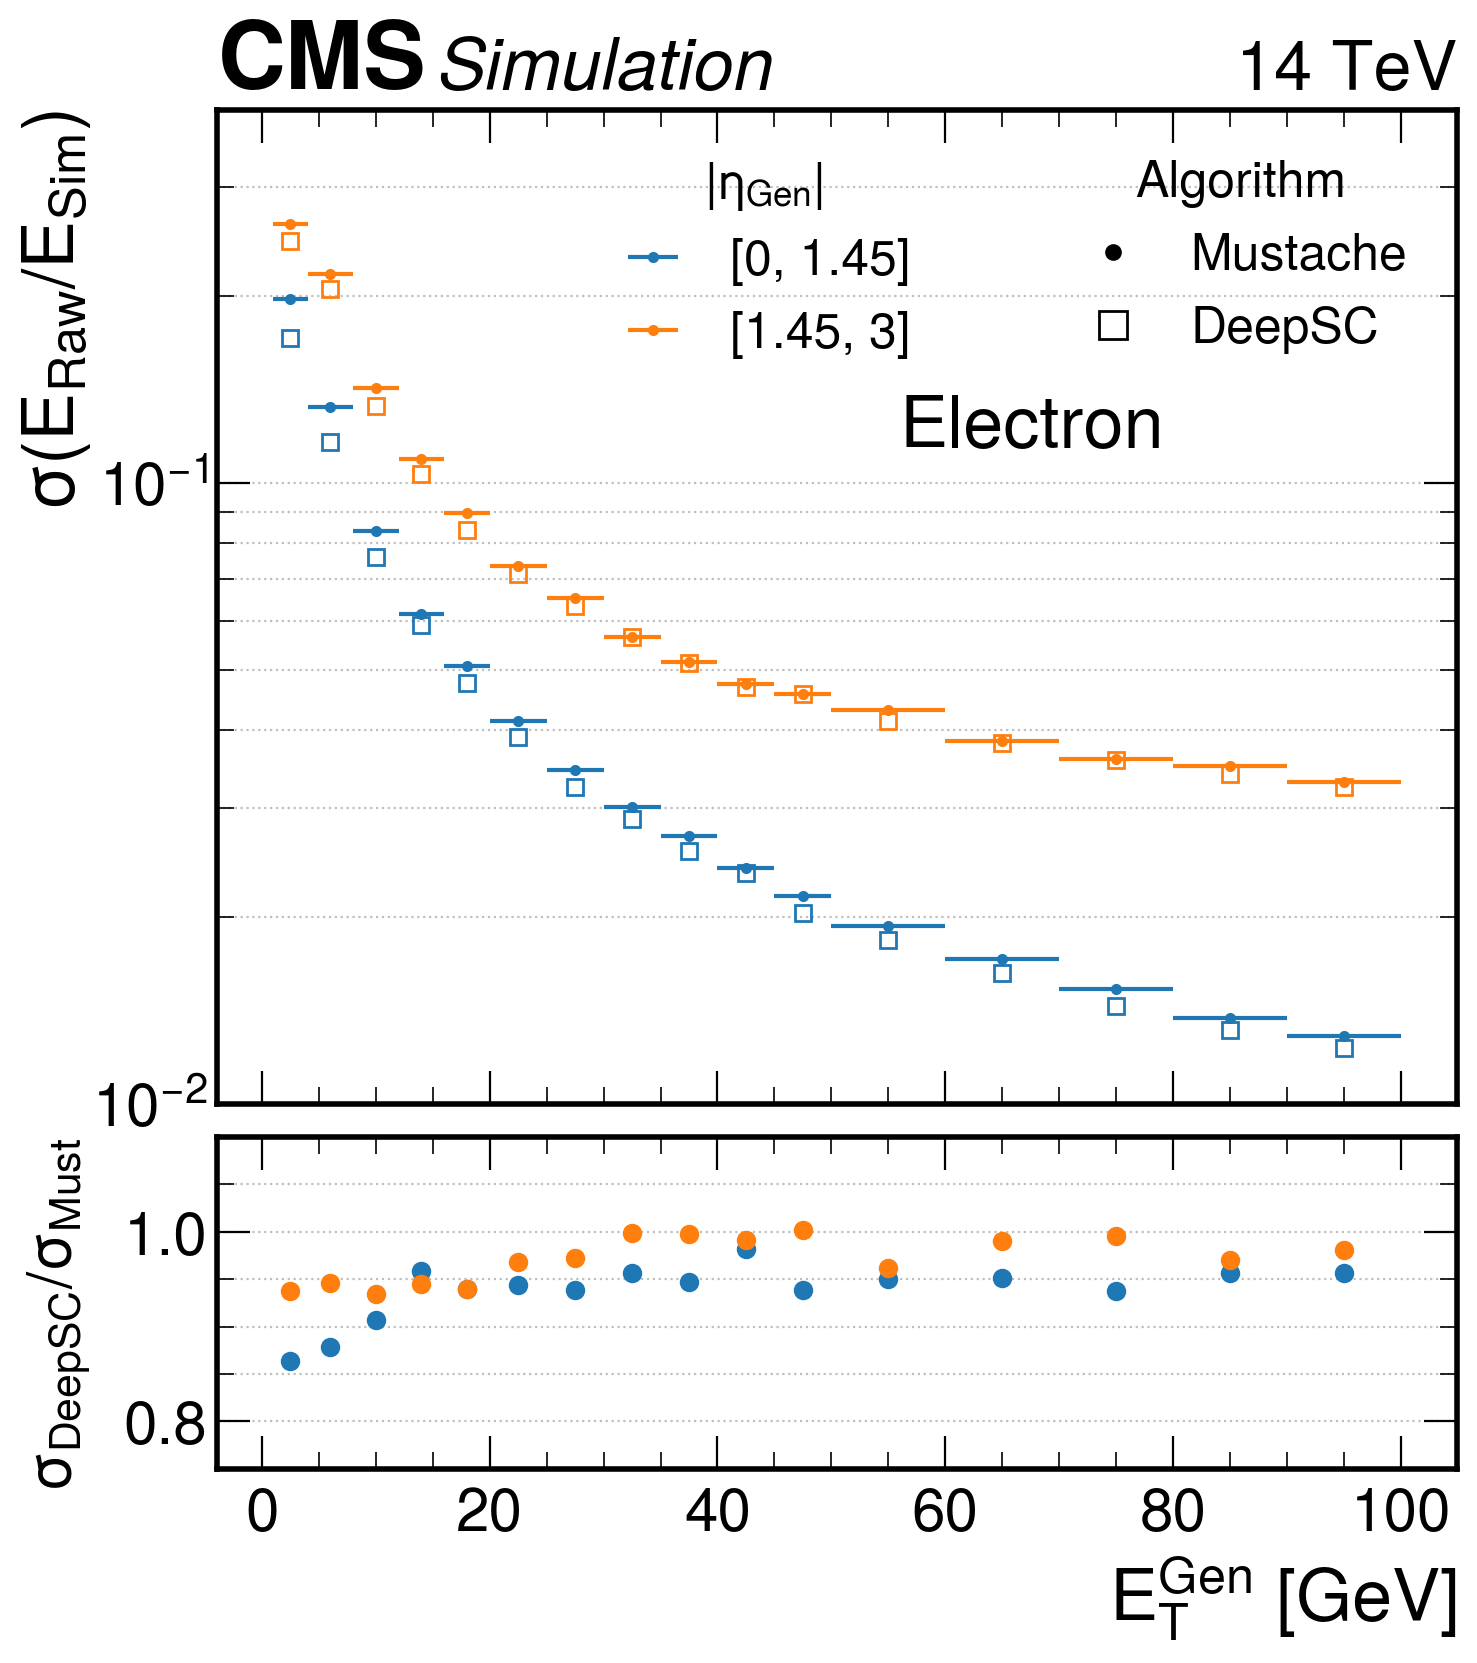

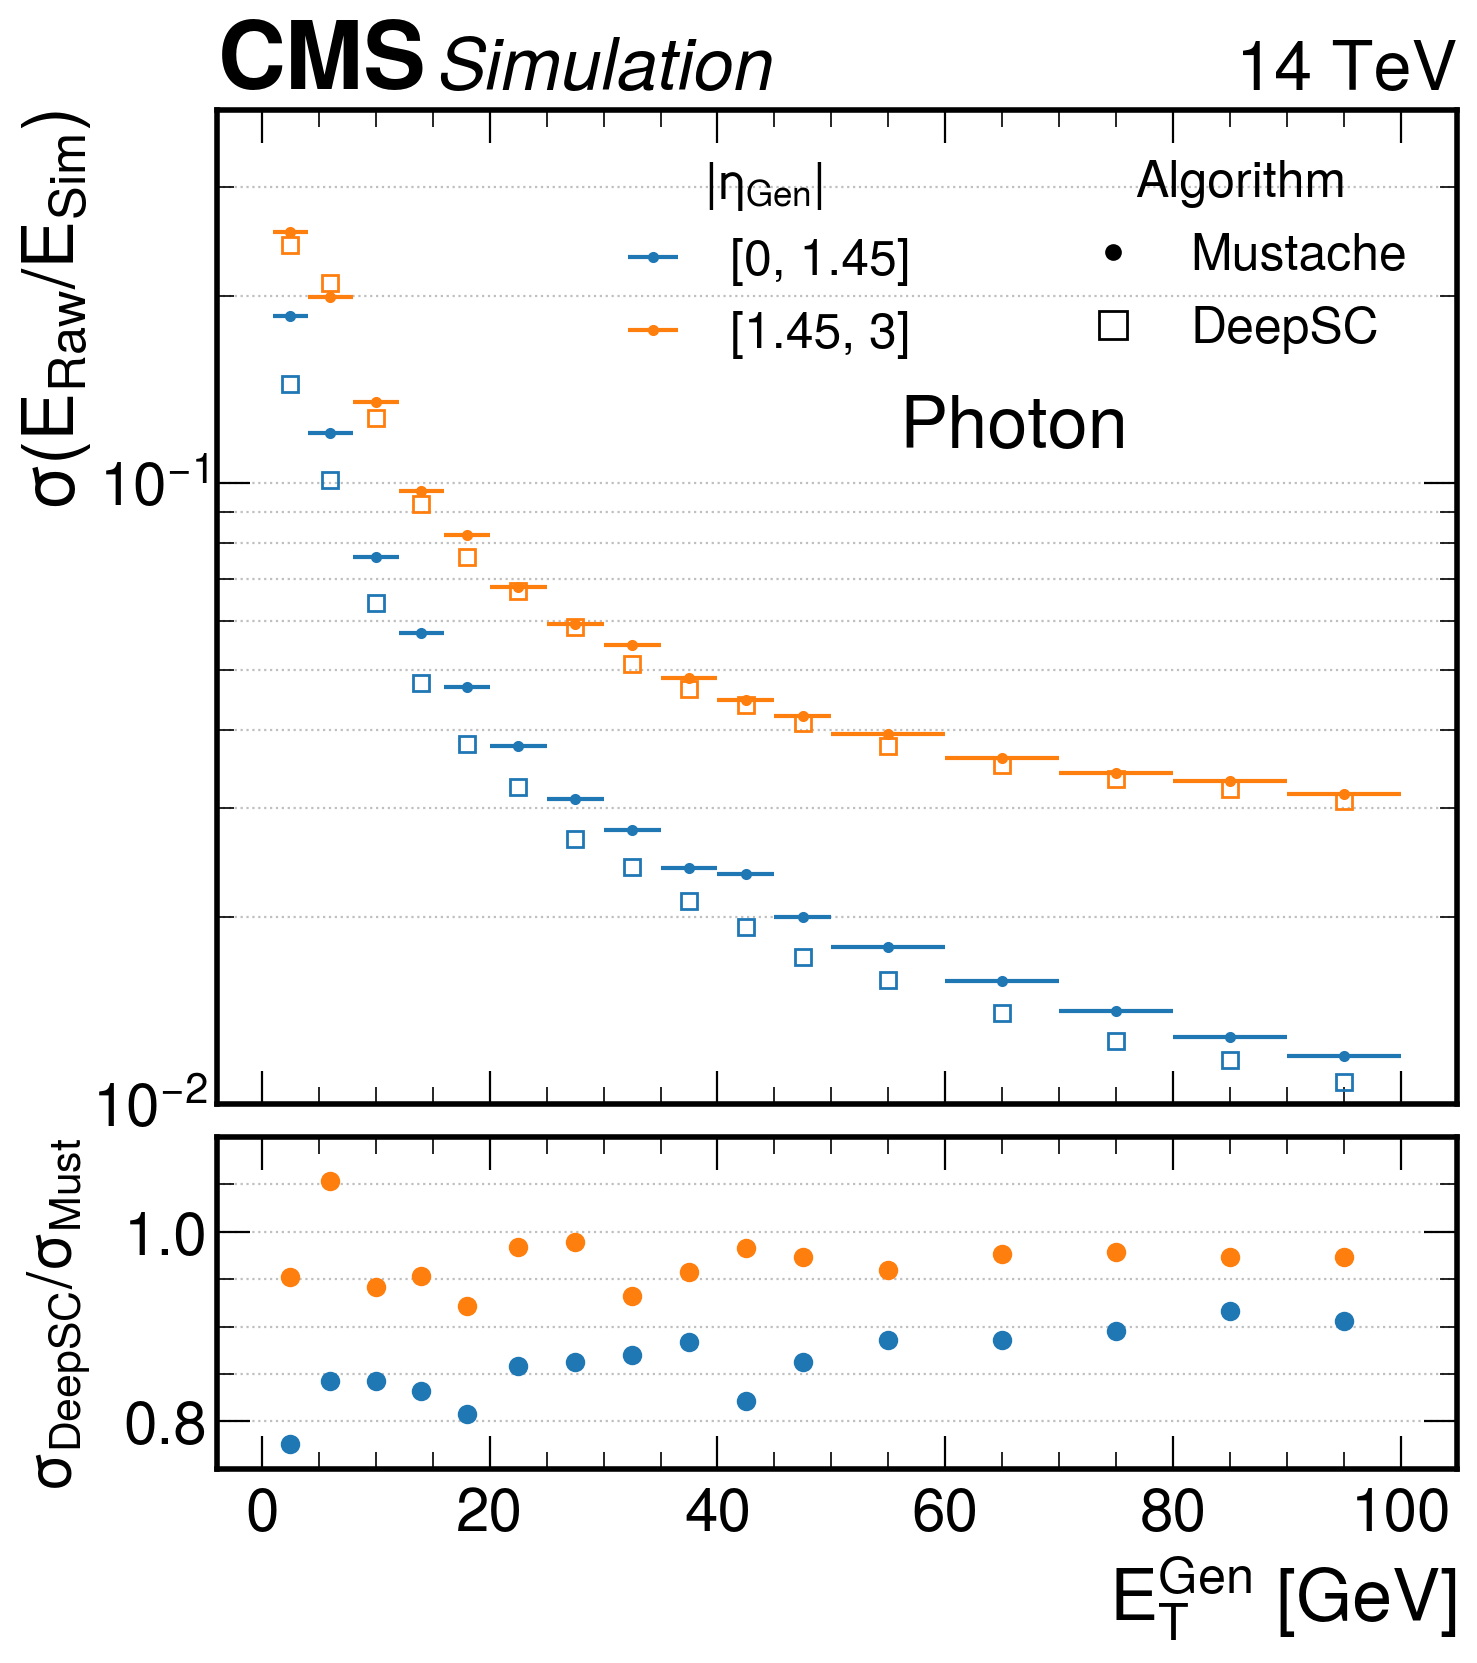

In [73]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [1.00, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    etas = [0, 1.45, 3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim_true_eta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("En_ovEtrue_sim_good", xrange=(0.5, 1.3), nbins=400))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("En_ovEtrue_sim_good_mustache", xrange=(0.5, 1.3), nbins=400))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []


        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)
        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="[{}, {}]".format(etas[ieta], etas[ieta+1]), 
                                marker="s", markerfacecolor='none', c=mustl[ieta].lines[0].get_color(), linestyle='none', elinewidth=0)
        deepl.append(l)
    

    for ieta, eta in enumerate(etas[:-1]):
#         v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
#         var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
        var = res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68
        axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt="o", linestyle='none', elinewidth=0 )

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(1e-2, 0.4)
    axs[1].set_ylim(0.75, 1.10)
    axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.55, 0.66, flavour, transform=axs[0].transAxes)
    axs[0].set_yscale("log")

    l1= axs[0].legend(handles=mustl, title="$|\eta_{Gen}|$", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")
    axs[0].grid(axis="y", which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
#     fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.png".format(flavour))
#     fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.pdf".format(flavour))
#     fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.svg".format(flavour))

# Resolution by Gen ET with improvement in quadrature and sigmaE/E

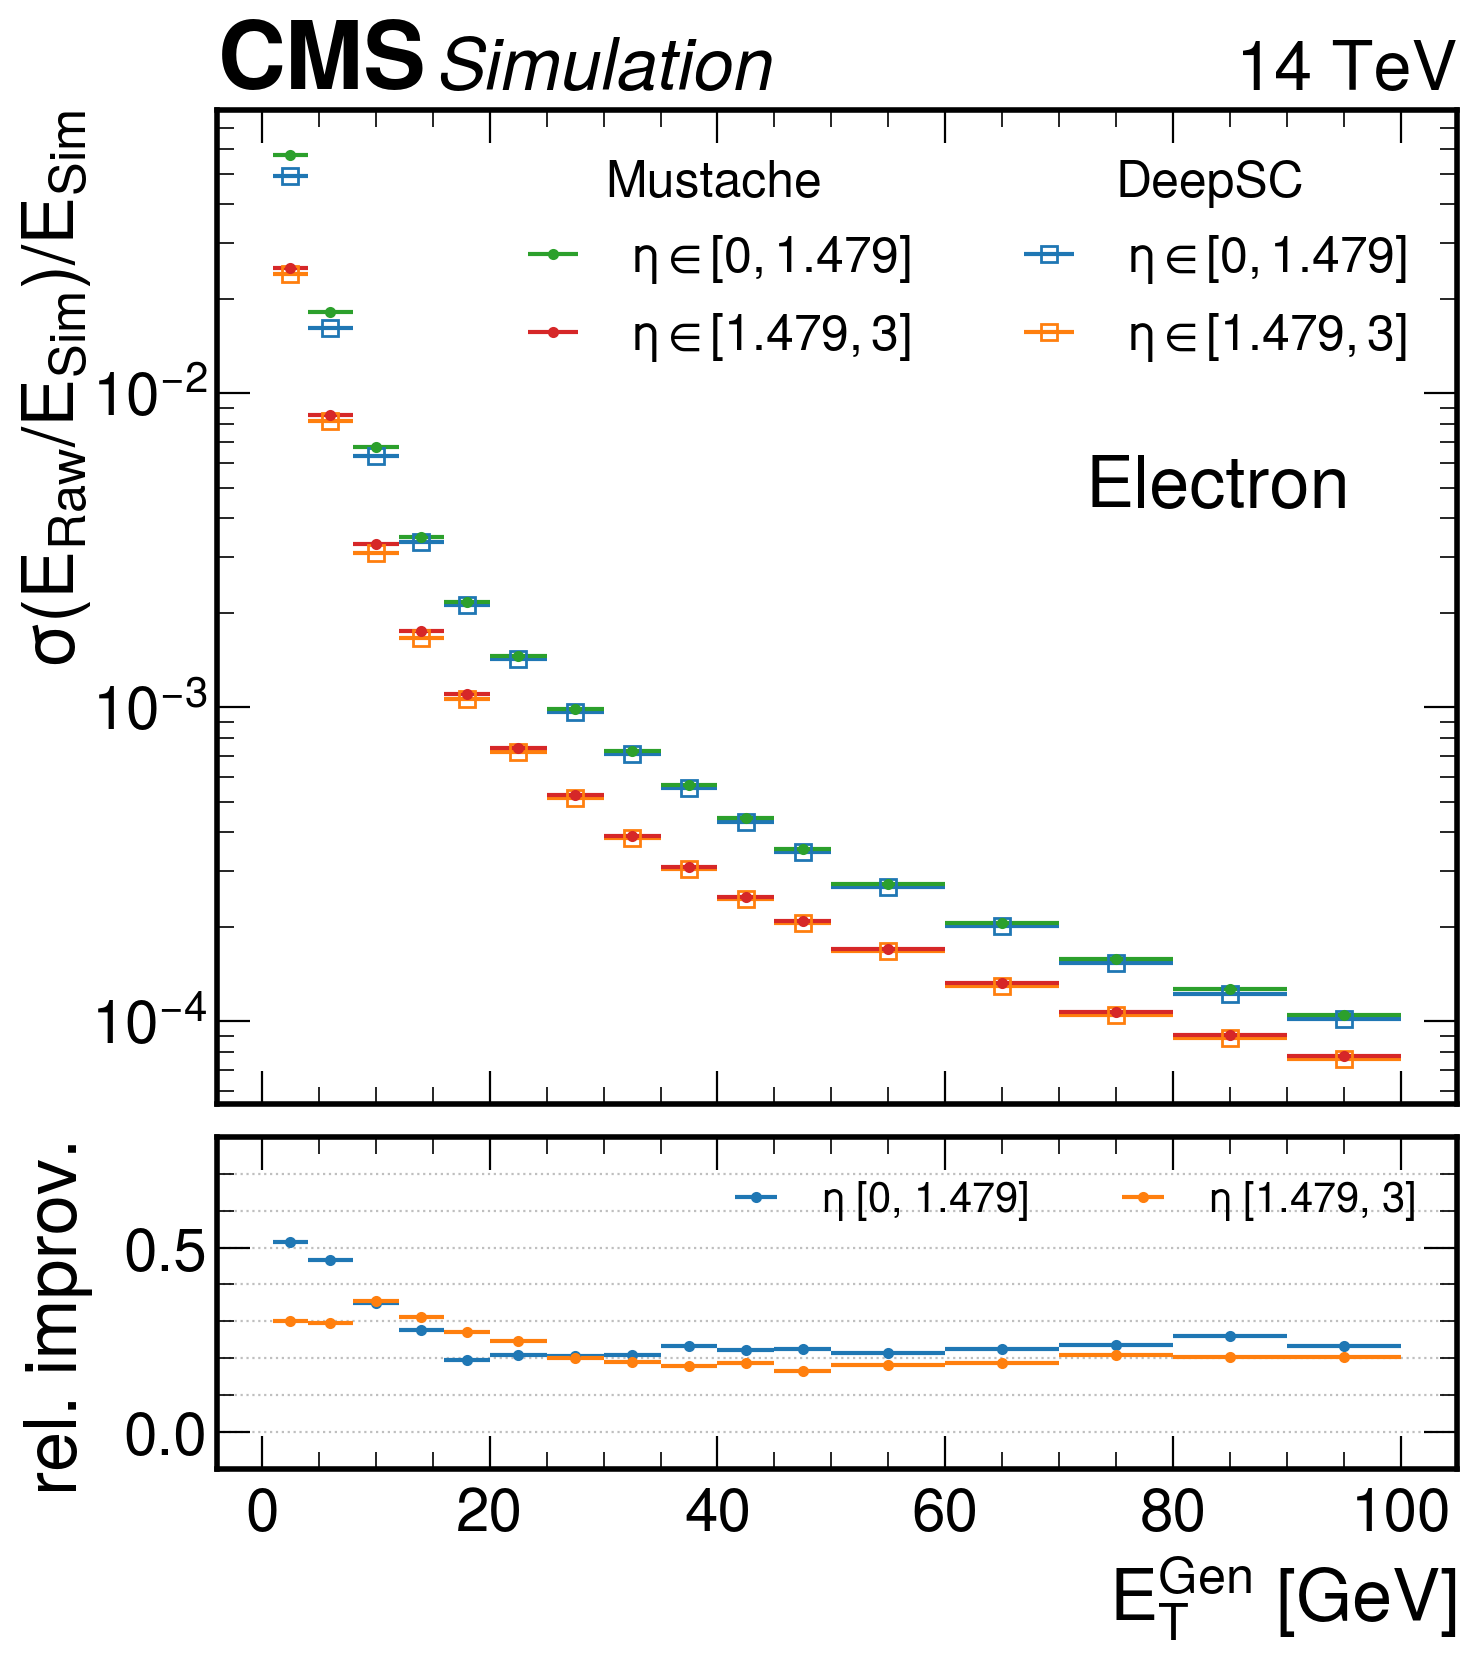

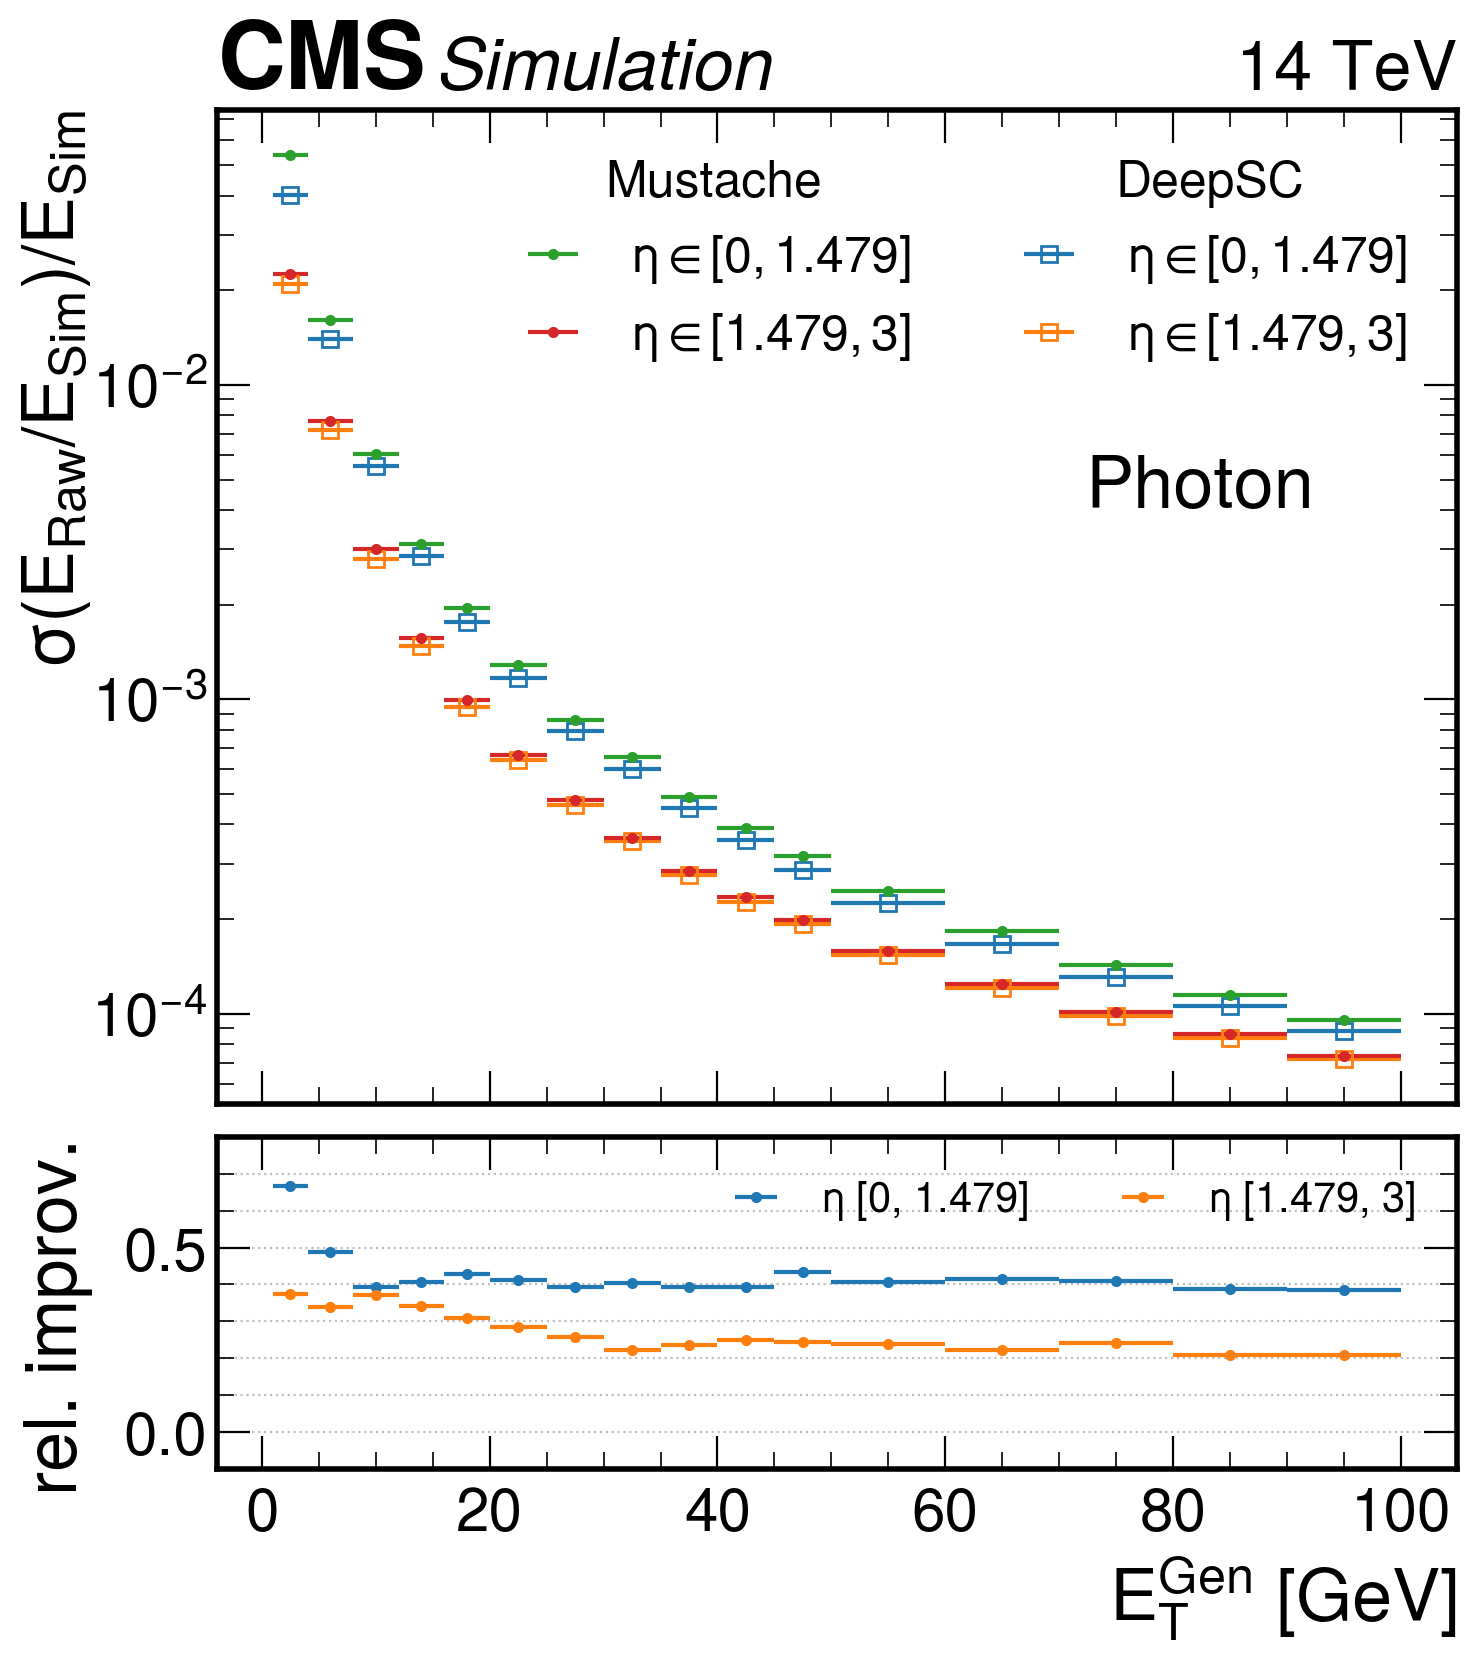

In [9]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [1.00, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    etas = [0, 1.479, 3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
    avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
    avgenraw.reset_index(level=0, inplace=True)
    avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []

    
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68/ avgenraw[avgenraw.eta_bin ==ieta].en_true_sim_good, xerr=errx,label="$\eta \in [{}, {}]$".format(etas[ieta], etas[ieta+1]), marker="s", markerfacecolor='none', linestyle='none')
        deepl.append(l)
        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68/avgenraw[avgenraw.eta_bin ==ieta].en_true_sim_good, xerr=errx, label="$\eta \in [{}, {}]$".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)

    

    for ieta, eta in enumerate(etas[:-1]):
        v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
        var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
        axs[1].errorbar(x, var, xerr=errx, label="$\eta$ [{}, {}]".format(etas[ieta], etas[ieta+1]), fmt=".")

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim}) / E_{Sim}$")

    axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
#     axs[0].set_ylim(0, 0.15)
    axs[1].set_ylim(-0.1, 0.8)
    axs[1].set_ylabel("rel. improv.")
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
    axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.7, 0.6, flavour, transform=axs[0].transAxes)
    axs[0].set_yscale("log")

    l1= axs[0].legend(handles=mustl, title="Mustache", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    axs[0].legend(handles=deepl, title="DeepSC", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# Resolution by Eta (seed ET) with rel. improvement and sigmaE/E

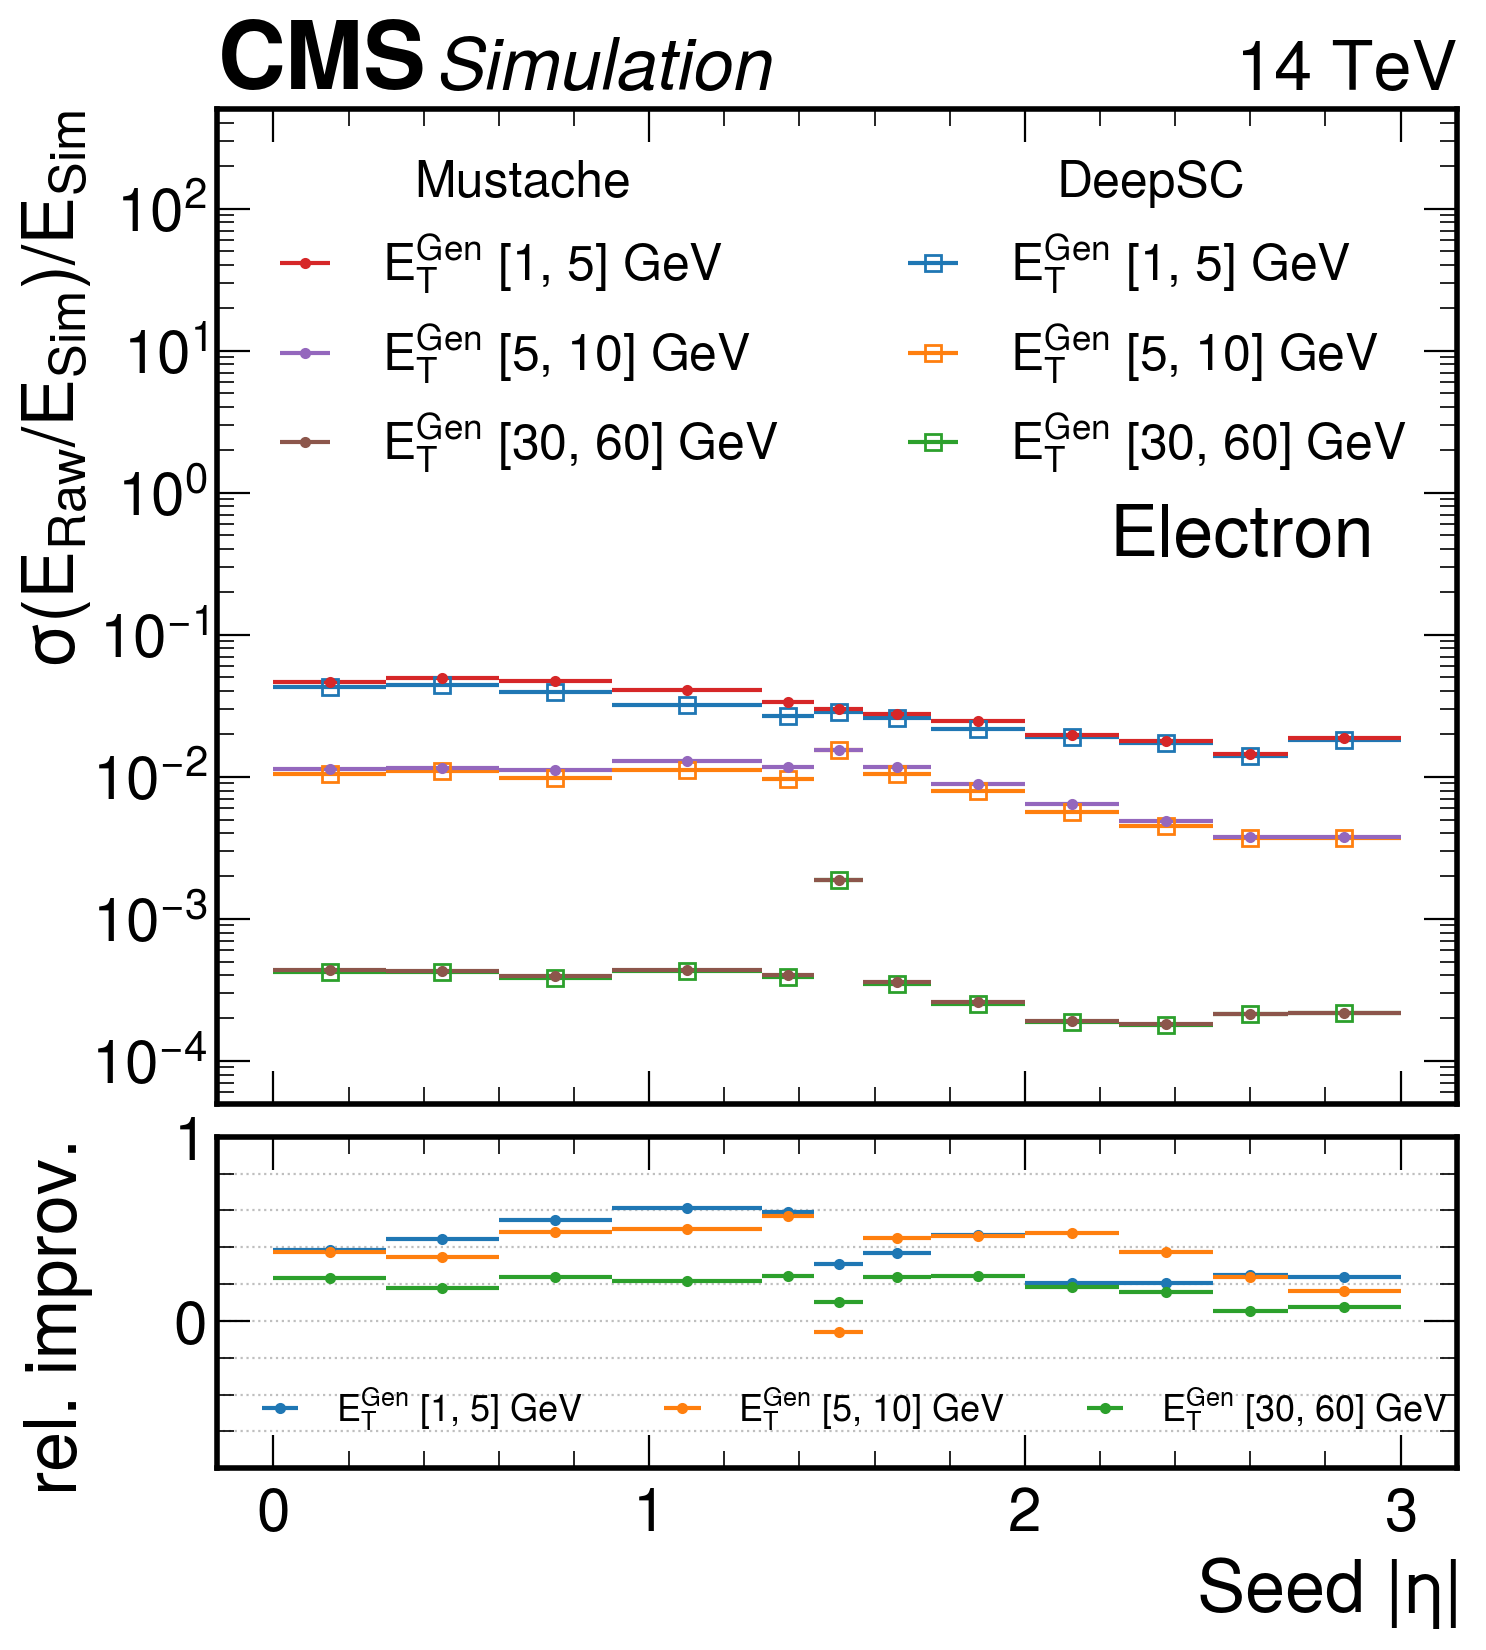

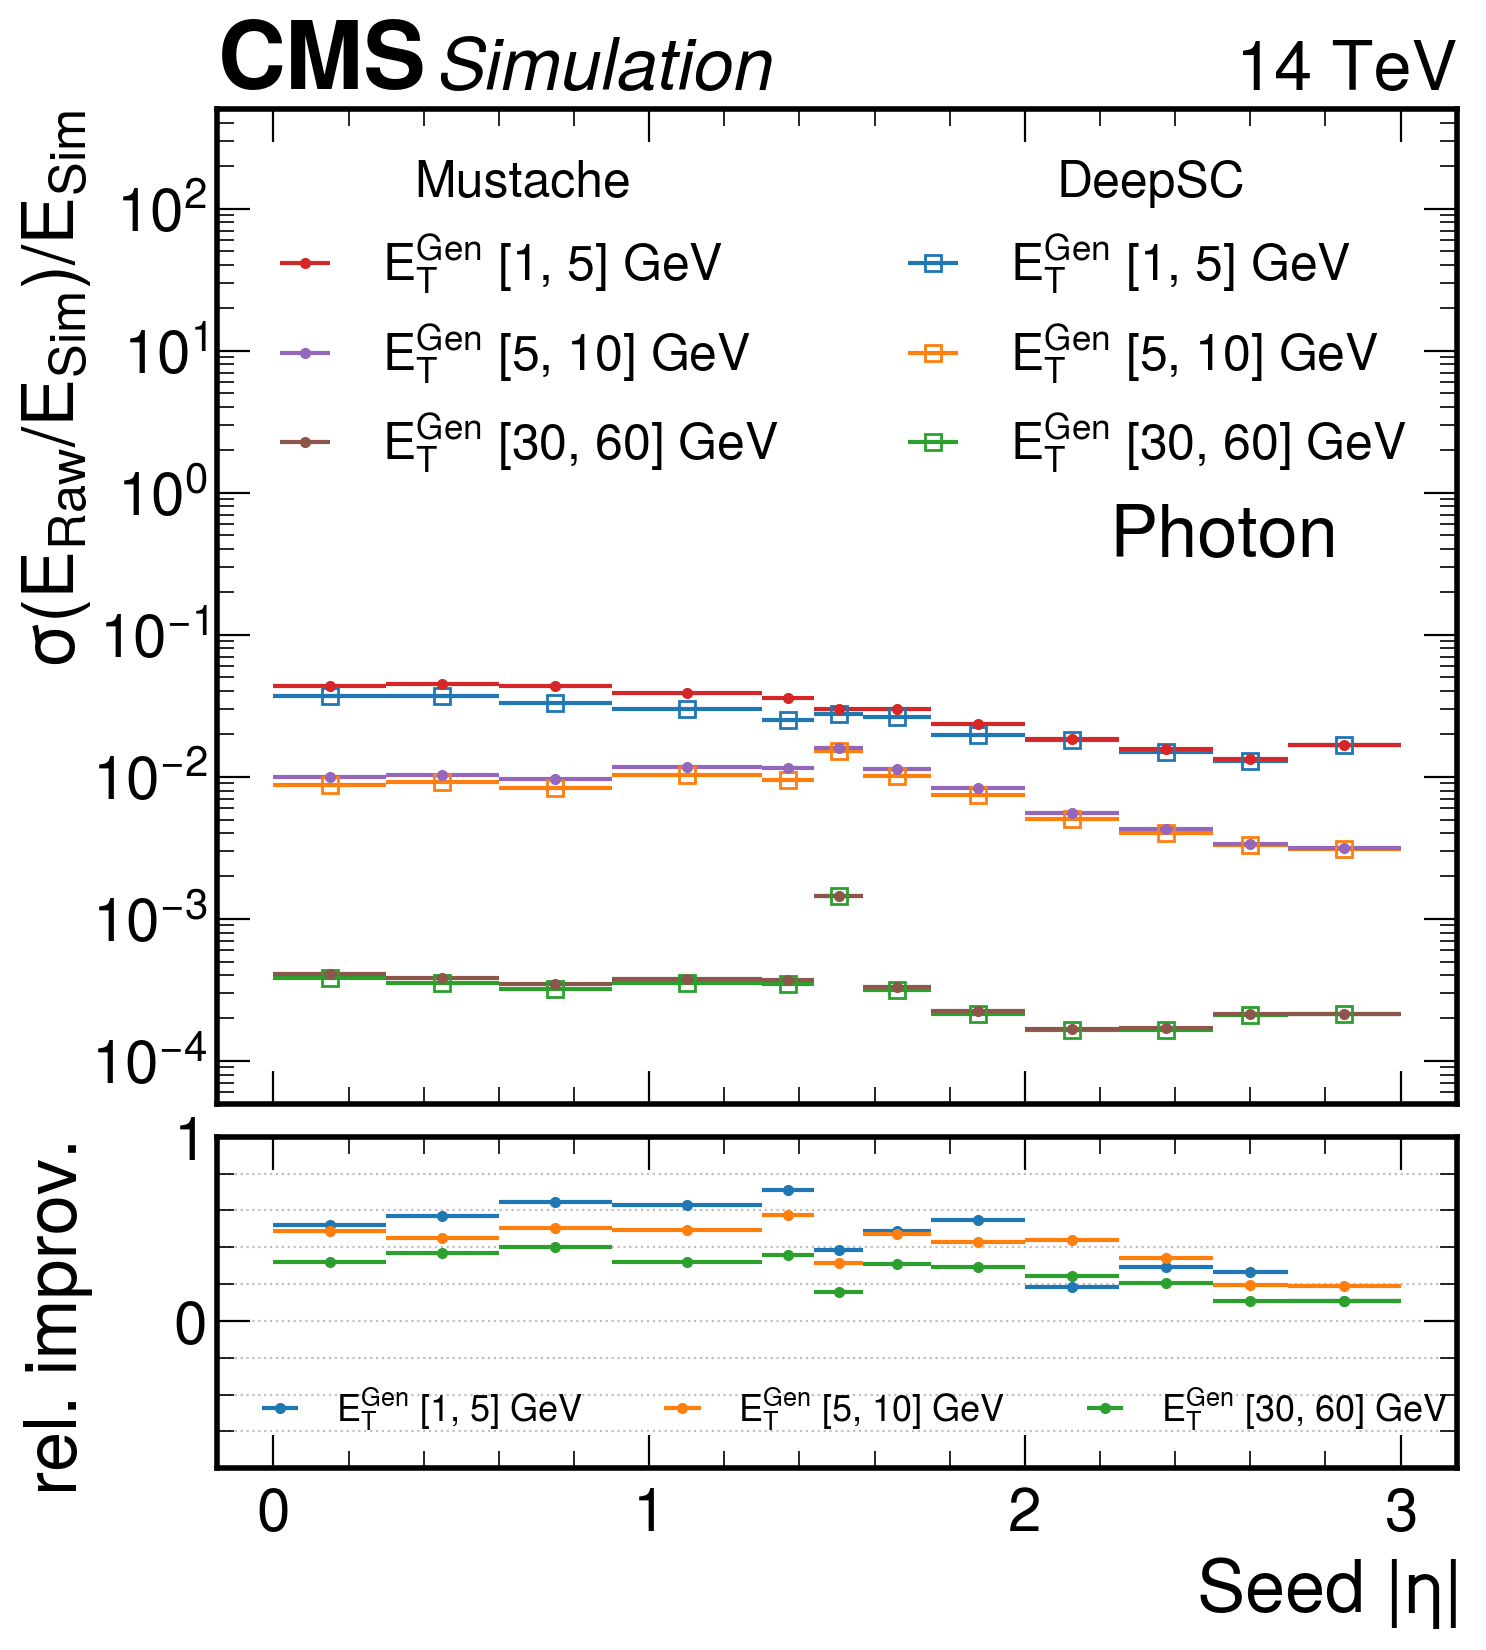

In [19]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):

    ets = [1, 5, 10, 30,60]
    iplot = [0,1, 3 ]
    etas = [0, 0.3,0.6,0.9,1.3, 1.44,1.57, 1.75, 2.,2.25,2.5,2.7,3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(df.eta, etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
    avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    avgenraw.reset_index(level=0, inplace=True)
    avgenraw.reset_index(level=0, inplace=True)
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(etas)-1):
        errx.append((etas[i+1]- etas[i])/2)
        x.append((etas[i+1]+ etas[i])/2)

    mustl = []
    deepl = []
    

    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res[res.et_bin == iet].w68/ avgenraw[avgenraw.et_bin ==iet].en_true_sim_good ,  xerr=errx ,label="$E_T^{Gen}$" +" [{}, {}] GeV".format(ets[iet], ets[iet+1]), marker="s", markerfacecolor='none', linestyle='none')
        deepl.append(l)
        
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res_must[res_must.et_bin == iet].w68/ avgenraw[avgenraw.et_bin ==iet].en_true_sim_good , xerr=errx, label="$E_T^{Gen}$" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)


    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        axs[1].errorbar(x, var,xerr=errx, label="$E_T^{Gen} $" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),  fmt=".")

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim}) / E_{Sim}$")

    l1= axs[0].legend(handles=mustl, title="Mustache", title_fontsize=18, loc="upper left", fontsize=18)
    axs[0].legend(handles=deepl, title="DeepSC", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)

    axs[1].set_xlabel("Seed $|\eta|$")
    axs[0].set_ylim(5e-5,5e2)
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")

    axs[1].set_ylim(-0.8, 1)
    axs[1].set_ylabel("rel. improv.")
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
    axs[1].legend(ncol=3,prop={'size': 13}, loc="lower left" )

    axs[0].text(0.72, 0.55, flavour, transform=axs[0].transAxes)
    
    axs[0].set_yscale("log")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])

# Resolution by Eta and Gen PT

# Resolution by eta with rel improvement

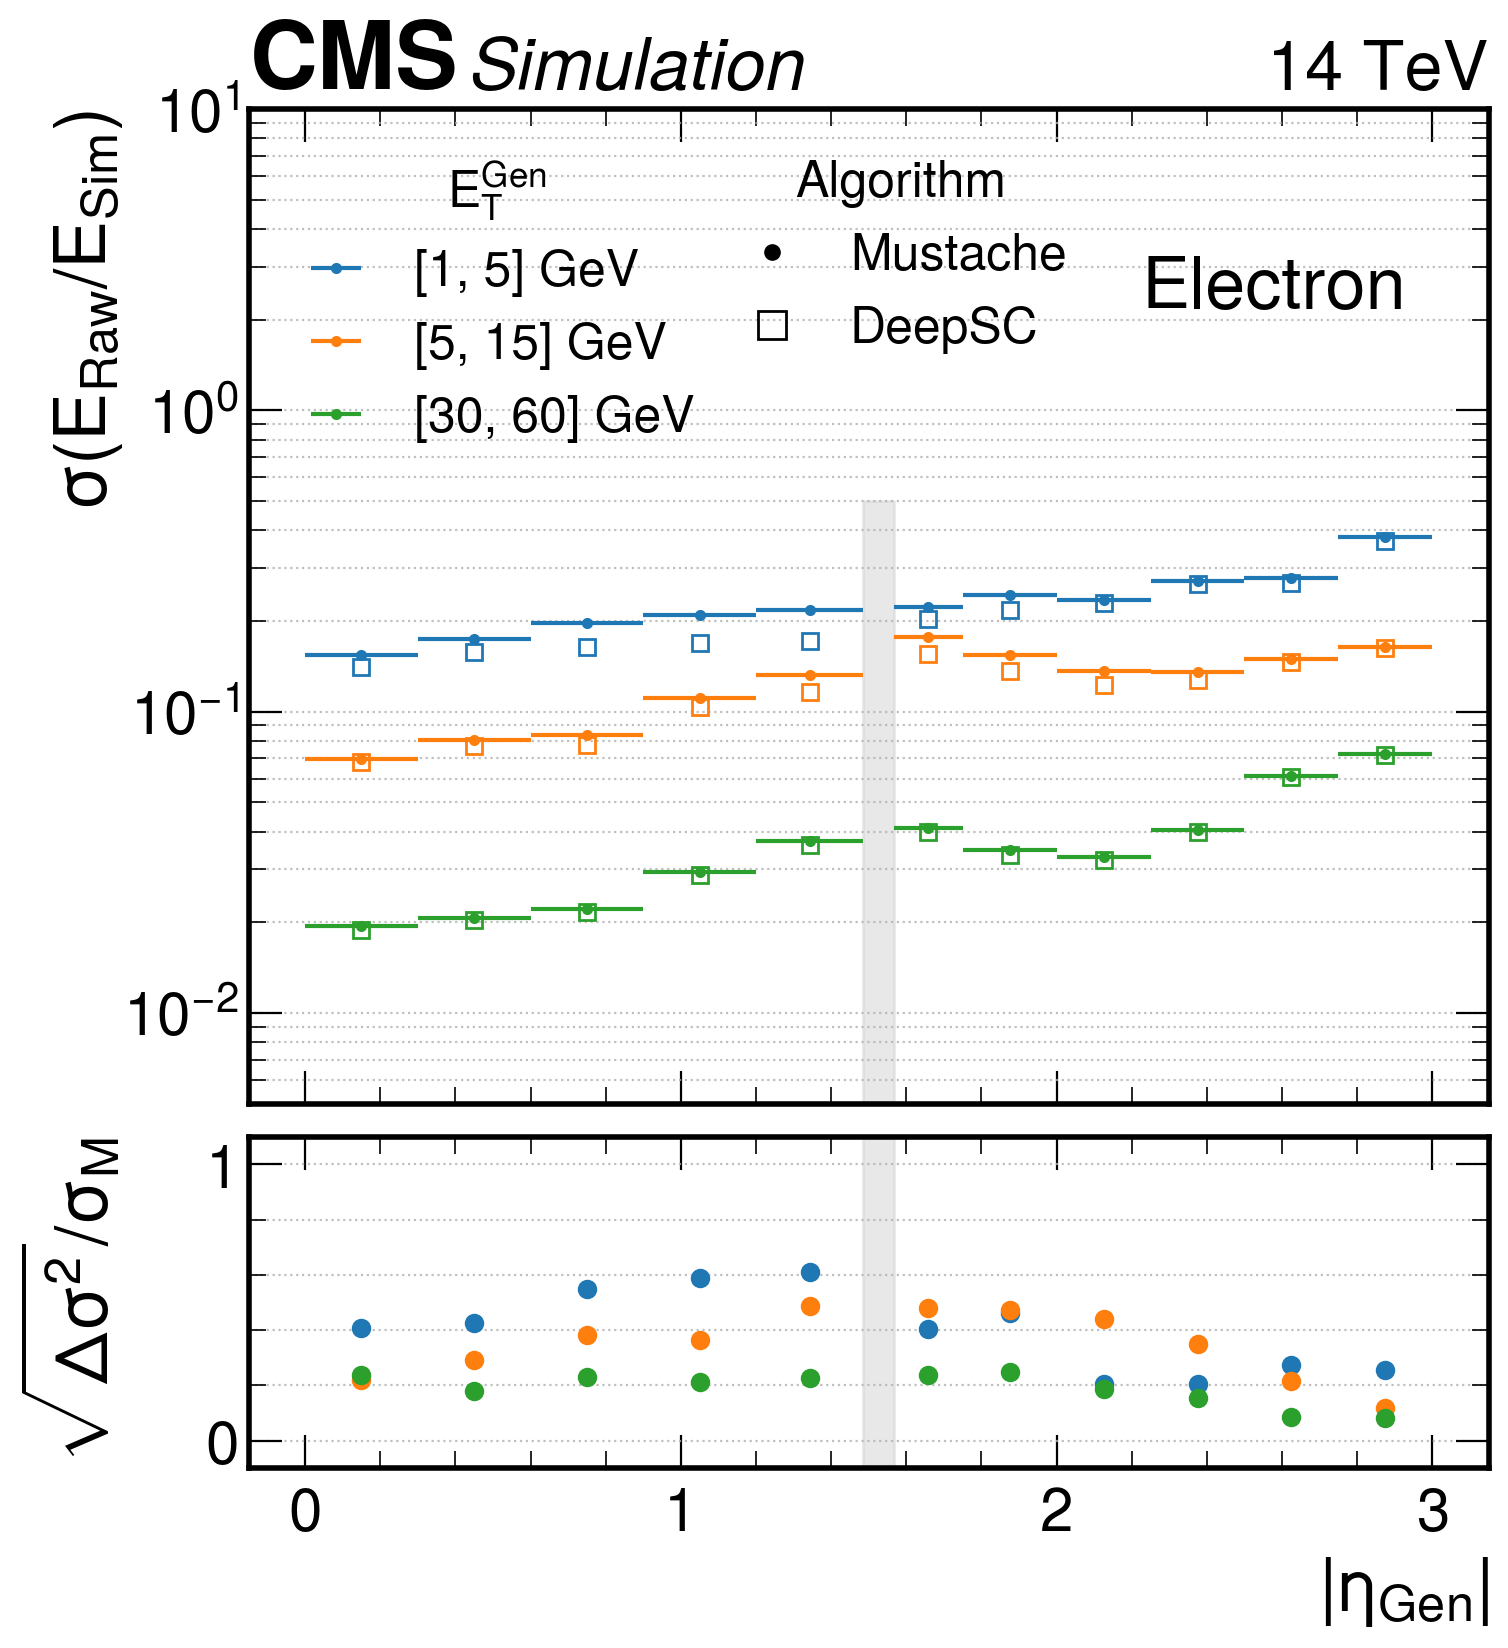

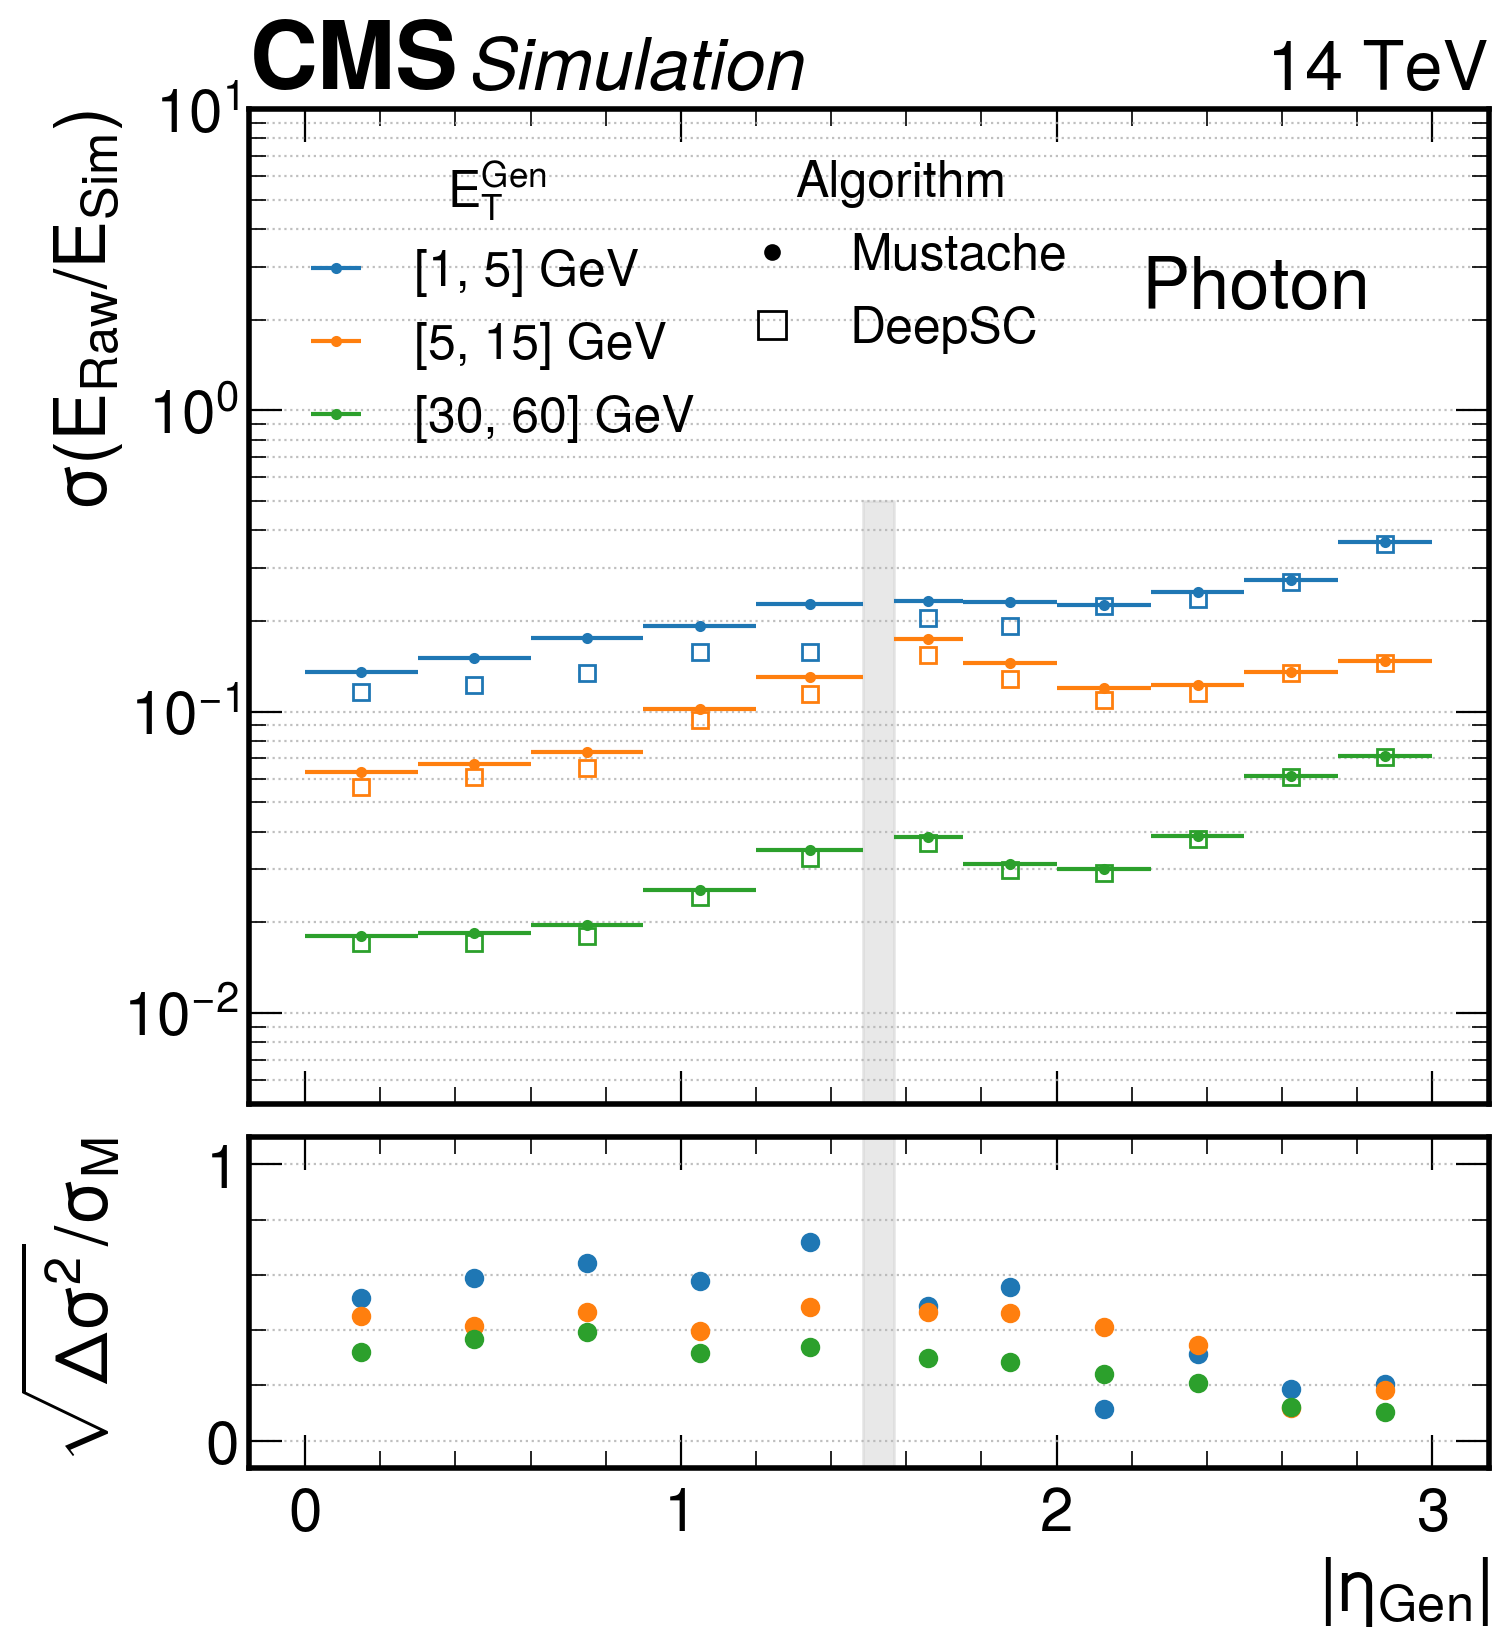

In [13]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):

    ets = [1, 5,  15, 30,60]
    iplot = [0,1, 3 ]
    etas = [0, 0.3,0.6,0.9,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,2.75,3]
    exclude_bin = 5
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim_true_eta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(etas)-1):
        errx.append((etas[i+1]- etas[i])/2)
        x.append((etas[i+1]+ etas[i])/2)

    mustl = []
    deepl = []
    
    res.loc[res.eta_bin == exclude_bin, ["w68"]] = 0
    res_must.loc[res_must.eta_bin == exclude_bin, ["w68"]] = 0
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)

    i = 0
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res[res.et_bin == iet].w68,  xerr=errx ,label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), 
                                c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
        i+=1
        deepl.append(l)
        
    axs[0].fill_between([1.485, 1.566], [5e-3,5e-3],[0.5,0.5], color="lightgray", alpha=0.5)

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        axs[1].errorbar(x, var,xerr=errx, label="$E_T^{Gen} $" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),  fmt="o", linestyle='none', elinewidth=0)

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    l1= axs[0].legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.7, 1), fontsize=18)
    axs[0].add_artist(l1)

    axs[1].set_xlabel("$|\eta_{Gen}|$")
    axs[0].set_ylim(5e-3,1e1)
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")

    axs[1].set_ylim(-0.1, 1.1)
    axs[1].set_ylabel("$\sqrt{\Delta\sigma^2}/\sigma_M$")
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
    
    axs[1].fill_between([1.485, 1.566], [-0.1,-0.1],[1.1,1.1], color="lightgray", alpha=0.5)
      
#     axs[1].legend(ncol=3,prop={'size': 13}, loc="lower left" )

    axs[0].text(0.72, 0.8, flavour, transform=axs[0].transAxes)
    
    axs[0].set_yscale("log")
    axs[0].grid(which="both",axis="y")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_byeta_{}.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byeta_{}.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byeta_{}.svg".format(flavour))

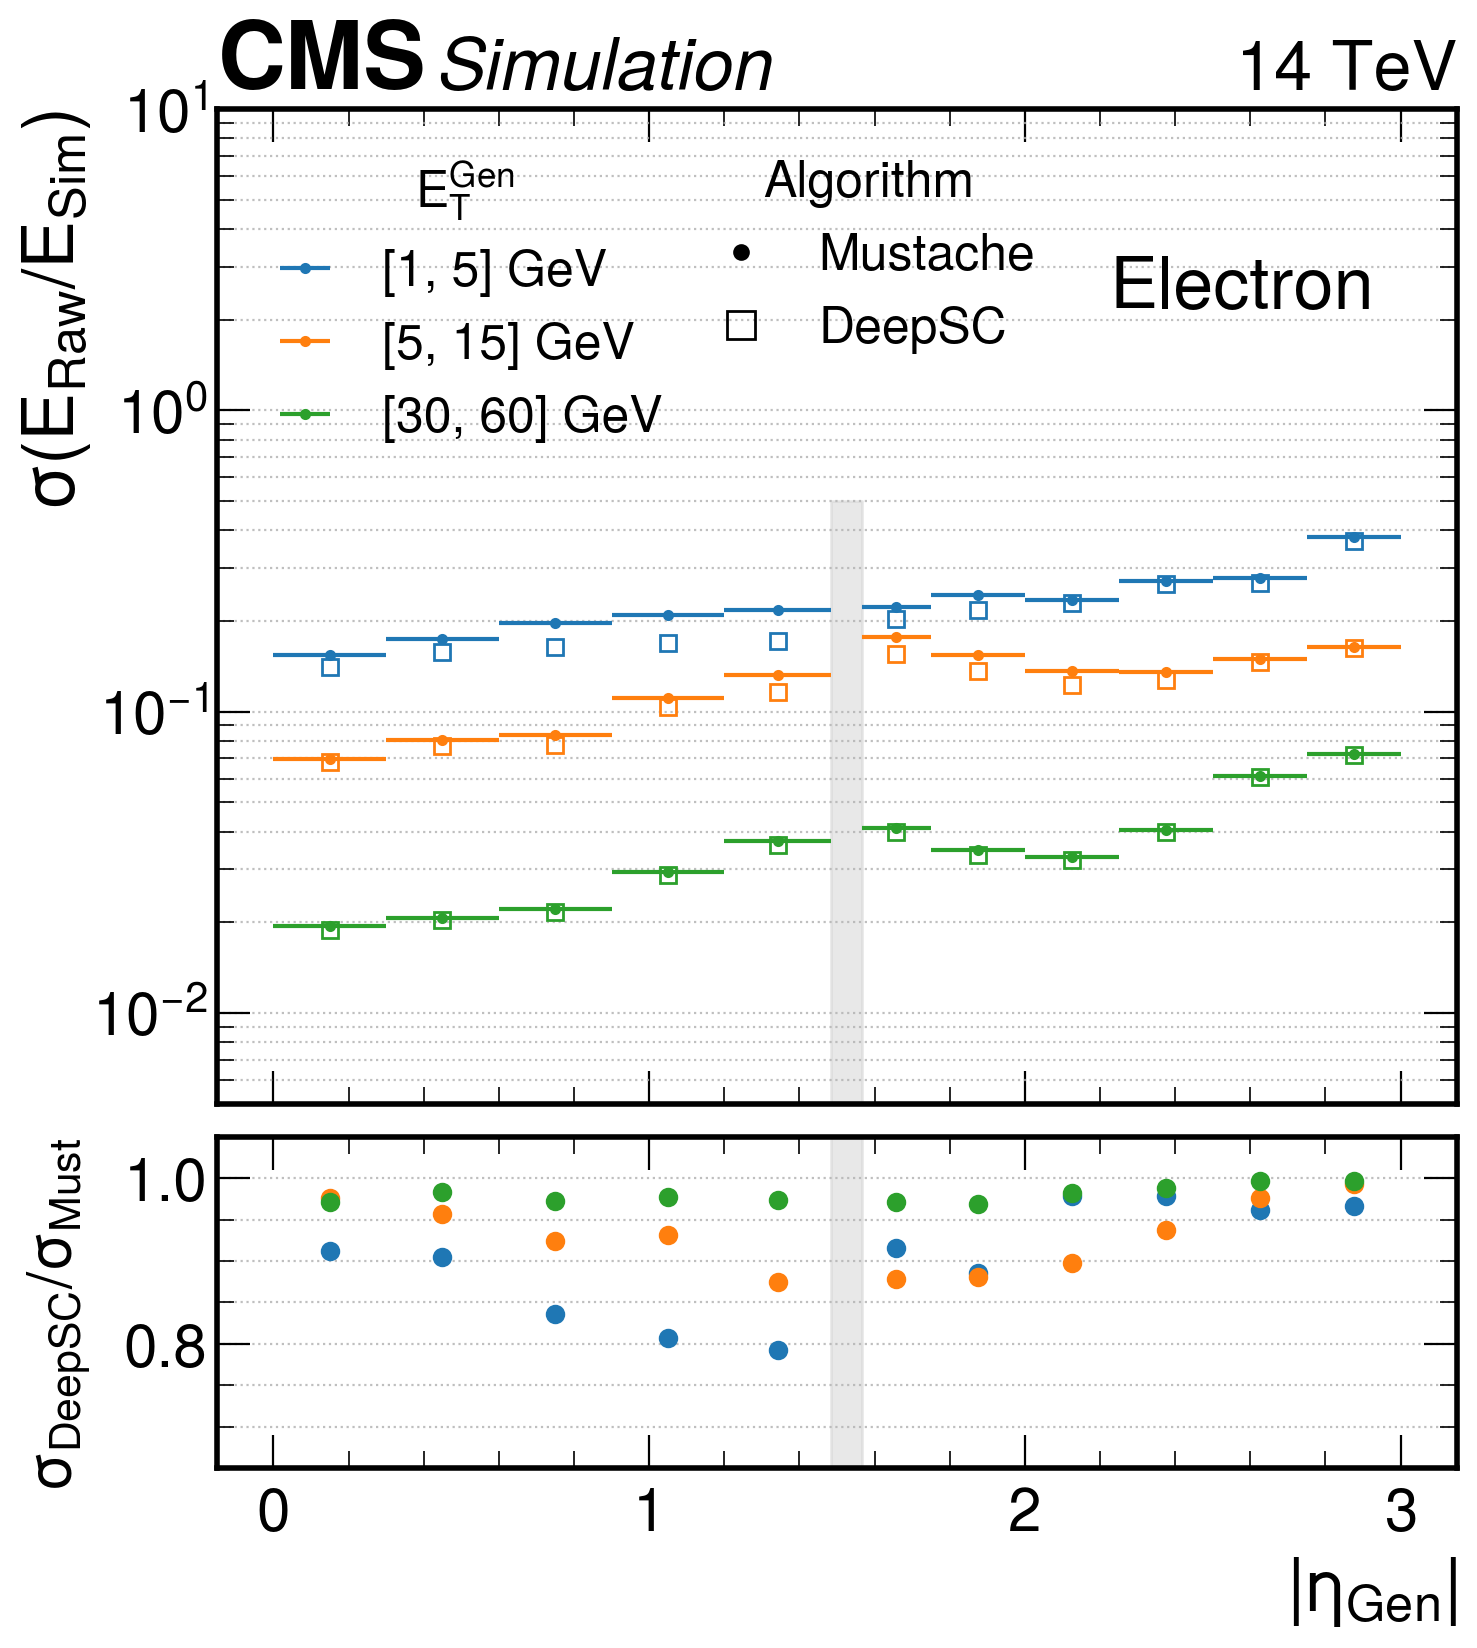

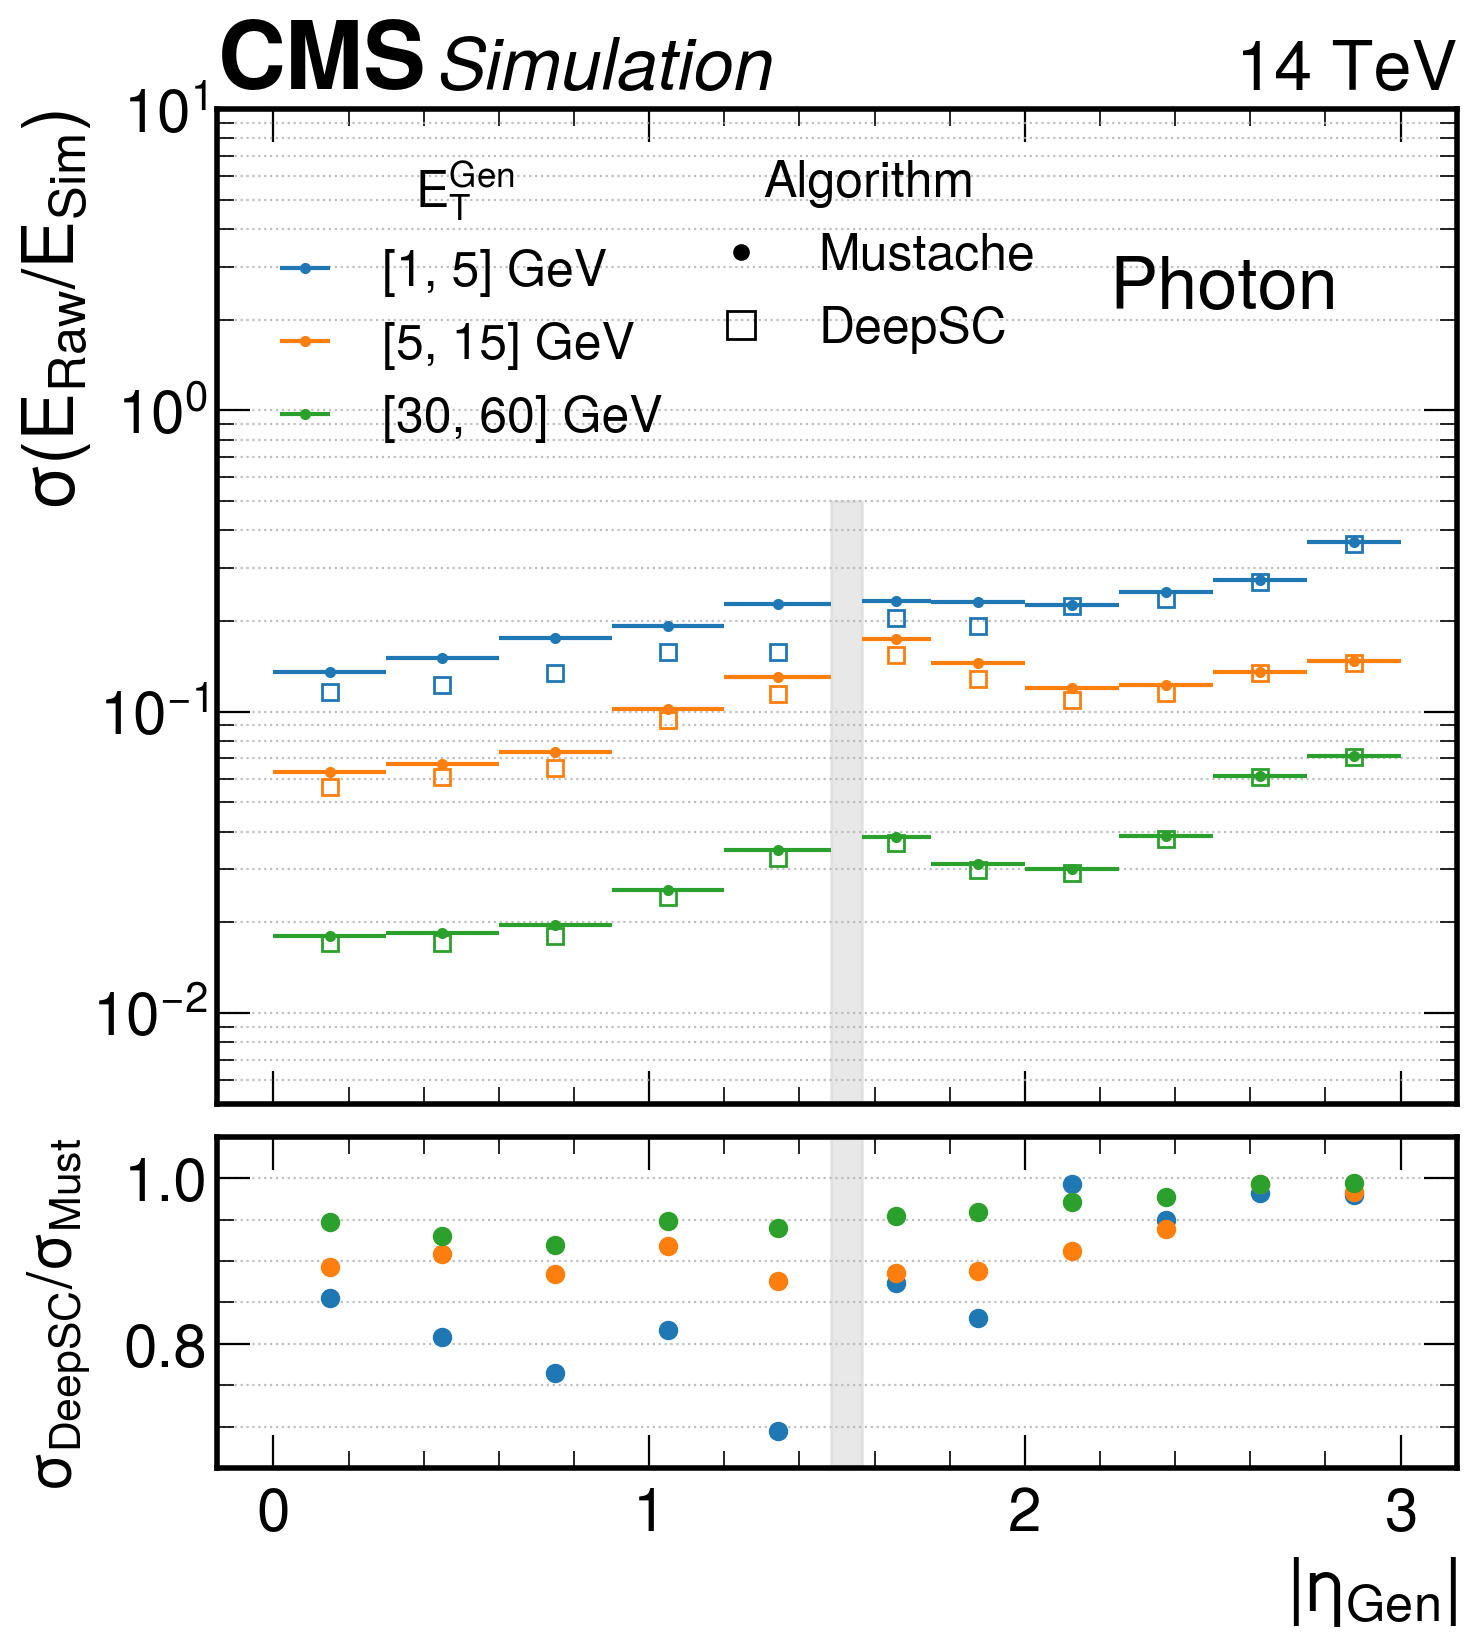

In [18]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):

    ets = [1, 5,  15, 30,60]
    iplot = [0,1, 3 ]
    etas = [0, 0.3,0.6,0.9,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,2.75,3]
    exclude_bin = 5
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim_true_eta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(etas)-1):
        errx.append((etas[i+1]- etas[i])/2)
        x.append((etas[i+1]+ etas[i])/2)

    mustl = []
    deepl = []
    
    res.loc[res.eta_bin == exclude_bin, ["w68"]] = 0
    res_must.loc[res_must.eta_bin == exclude_bin, ["w68"]] = 0
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)

    i = 0
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res[res.et_bin == iet].w68,  xerr=errx ,label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), 
                                c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
        i+=1
        deepl.append(l)
        
    axs[0].fill_between([1.485, 1.566], [5e-3,5e-3],[0.5,0.5], color="lightgray", alpha=0.5)

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        #v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        #var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        var = res[res.et_bin==iet].w68 / res_must[res_must.et_bin==iet].w68
        axs[1].errorbar(x, var,xerr=errx, label="$E_T^{Gen} $" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),  fmt="o", linestyle='none', elinewidth=0)

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    l1= axs[0].legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.7, 1), fontsize=18)
    axs[0].add_artist(l1)

    axs[1].set_xlabel("$|\eta_{Gen}|$")
    axs[0].set_ylim(5e-3,1e1)
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")

    axs[1].set_ylim(0.65, 1.05)
    axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
    
    axs[1].fill_between([1.485, 1.566], [-0.1,-0.1],[1.1,1.1], color="lightgray", alpha=0.5)
      
#     axs[1].legend(ncol=3,prop={'size': 13}, loc="lower left" )

    axs[0].text(0.72, 0.8, flavour, transform=axs[0].transAxes)
    
    axs[0].set_yscale("log")
    axs[0].grid(which="both",axis="y")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_byeta_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byeta_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byeta_{}_ratio.svg".format(flavour))

### With central quantiles

In [75]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):

    ets = [1, 5,  15, 30,60]
    iplot = [0,1, 3 ]
    etas = [0, 0.3,0.6,0.9,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,2.75,3]
    exclude_bin = 5
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim_true_eta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("En_ovEtrue_sim_good", xrange=(0.5, 1.3), nbins=400))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis_central_smallest("En_ovEtrue_sim_good_must", xrange=(0.5, 1.3), nbins=400))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(etas)-1):
        errx.append((etas[i+1]- etas[i])/2)
        x.append((etas[i+1]+ etas[i])/2)

    mustl = []
    deepl = []
    
    res.loc[res.eta_bin == exclude_bin, ["w68"]] = 0
    res_must.loc[res_must.eta_bin == exclude_bin, ["w68"]] = 0
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)

    i = 0
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res[res.et_bin == iet].w68,  xerr=errx ,label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), 
                                c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
        i+=1
        deepl.append(l)
        
    axs[0].fill_between([1.485, 1.566], [5e-3,5e-3],[0.5,0.5], color="lightgray", alpha=0.5)

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        #v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        #var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        var = res[res.et_bin==iet].w68 / res_must[res_must.et_bin==iet].w68
        axs[1].errorbar(x, var,xerr=errx, label="$E_T^{Gen} $" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),  fmt="o", linestyle='none', elinewidth=0)

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    l1= axs[0].legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.7, 1), fontsize=18)
    axs[0].add_artist(l1)

    axs[1].set_xlabel("$|\eta_{Gen}|$")
    axs[0].set_ylim(5e-3,1e1)
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")

    axs[1].set_ylim(0.65, 1.05)
    axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
    
    axs[1].fill_between([1.485, 1.566], [-0.1,-0.1],[1.1,1.1], color="lightgray", alpha=0.5)
      
#     axs[1].legend(ncol=3,prop={'size': 13}, loc="lower left" )

    axs[0].text(0.72, 0.8, flavour, transform=axs[0].transAxes)
    
    axs[0].set_yscale("log")
    axs[0].grid(which="both",axis="y")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
#     fig.savefig(output_folder + "/resolution_byeta_{}_ratio.png".format(flavour))
#     fig.savefig(output_folder + "/resolution_byeta_{}_ratio.pdf".format(flavour))
#     fig.savefig(output_folder + "/resolution_byeta_{}_ratio.svg".format(flavour))

KeyError: 'En_ovEtrue_sim_good_must'

# Resolution by N clusters

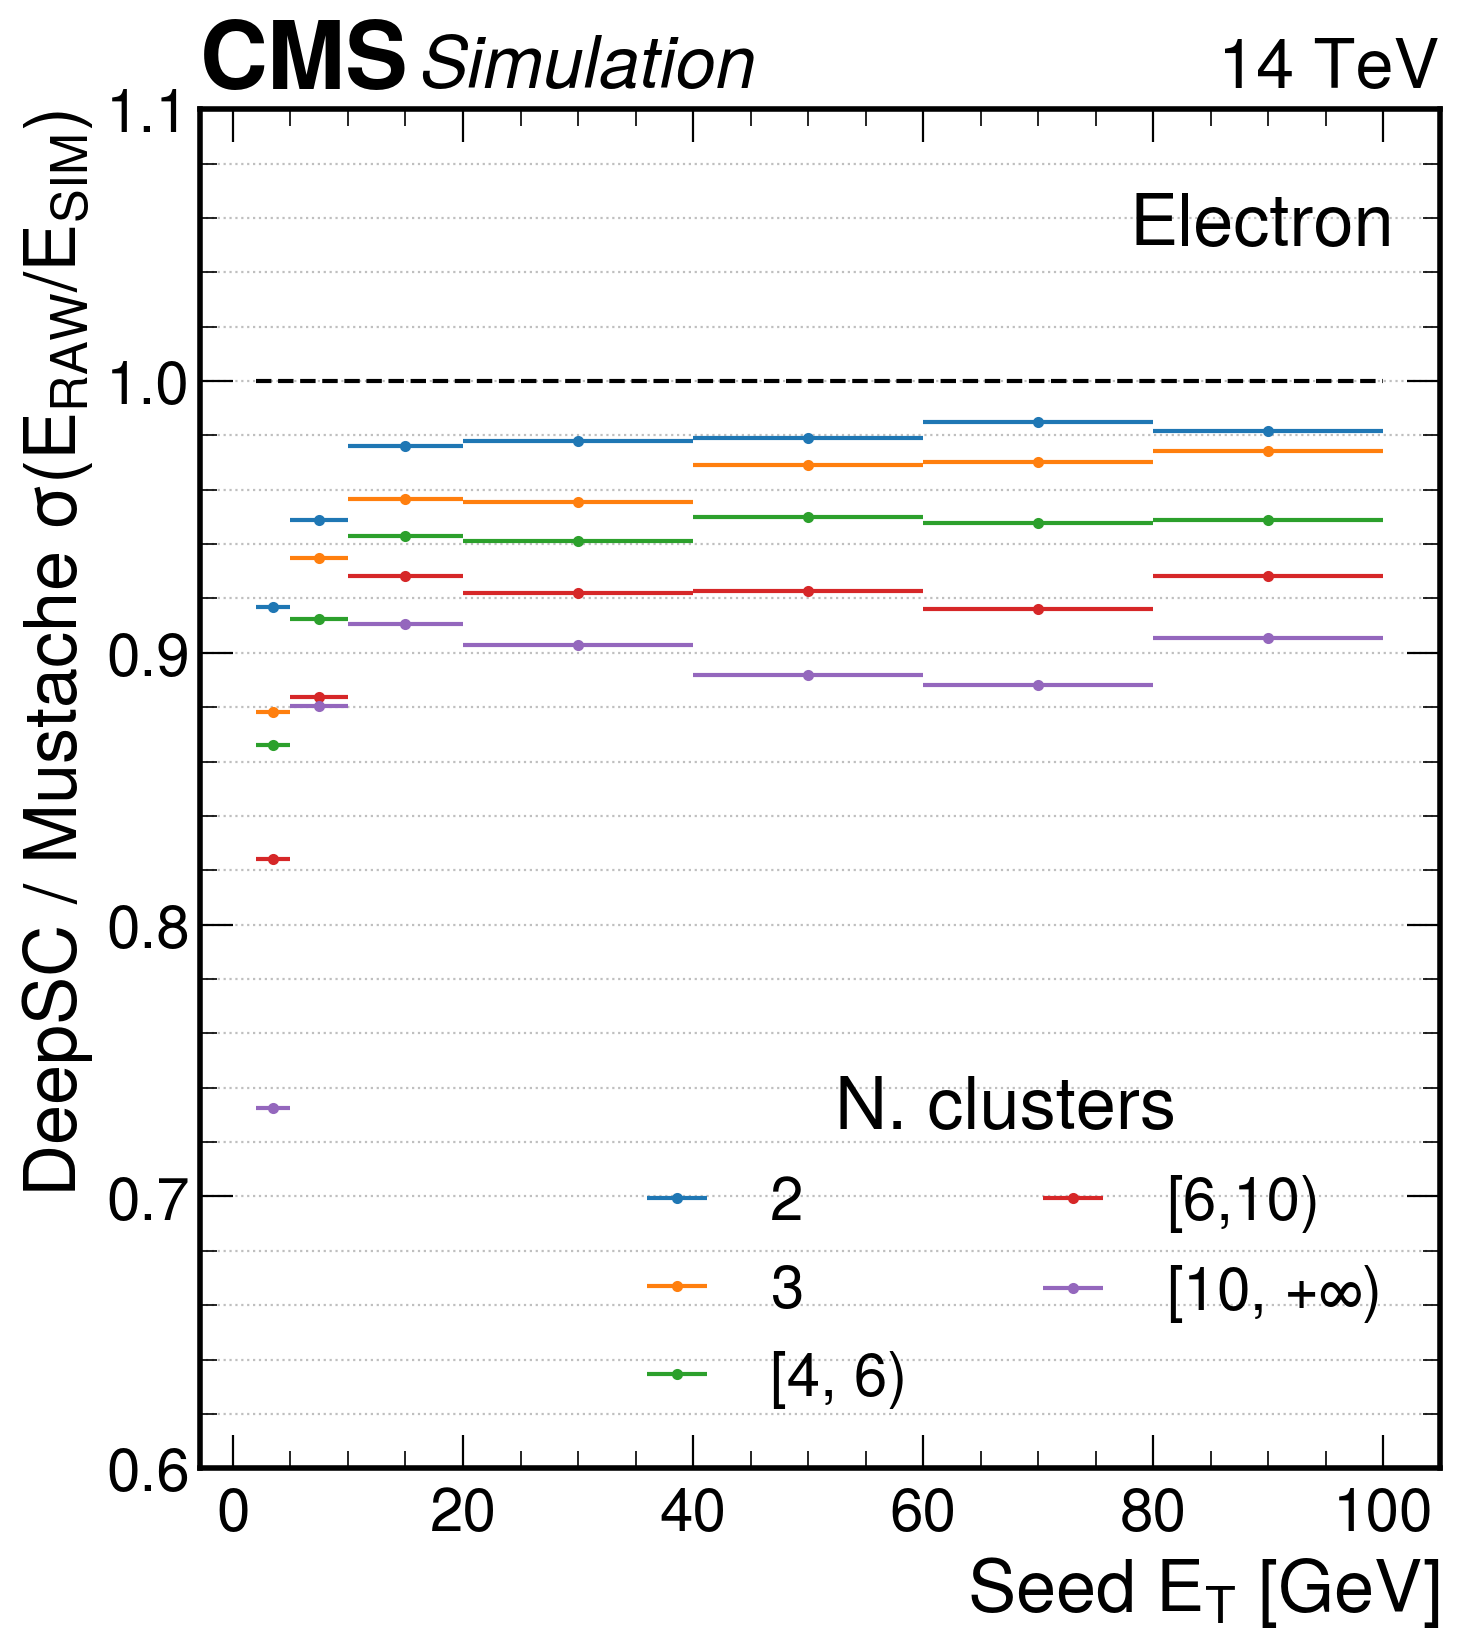

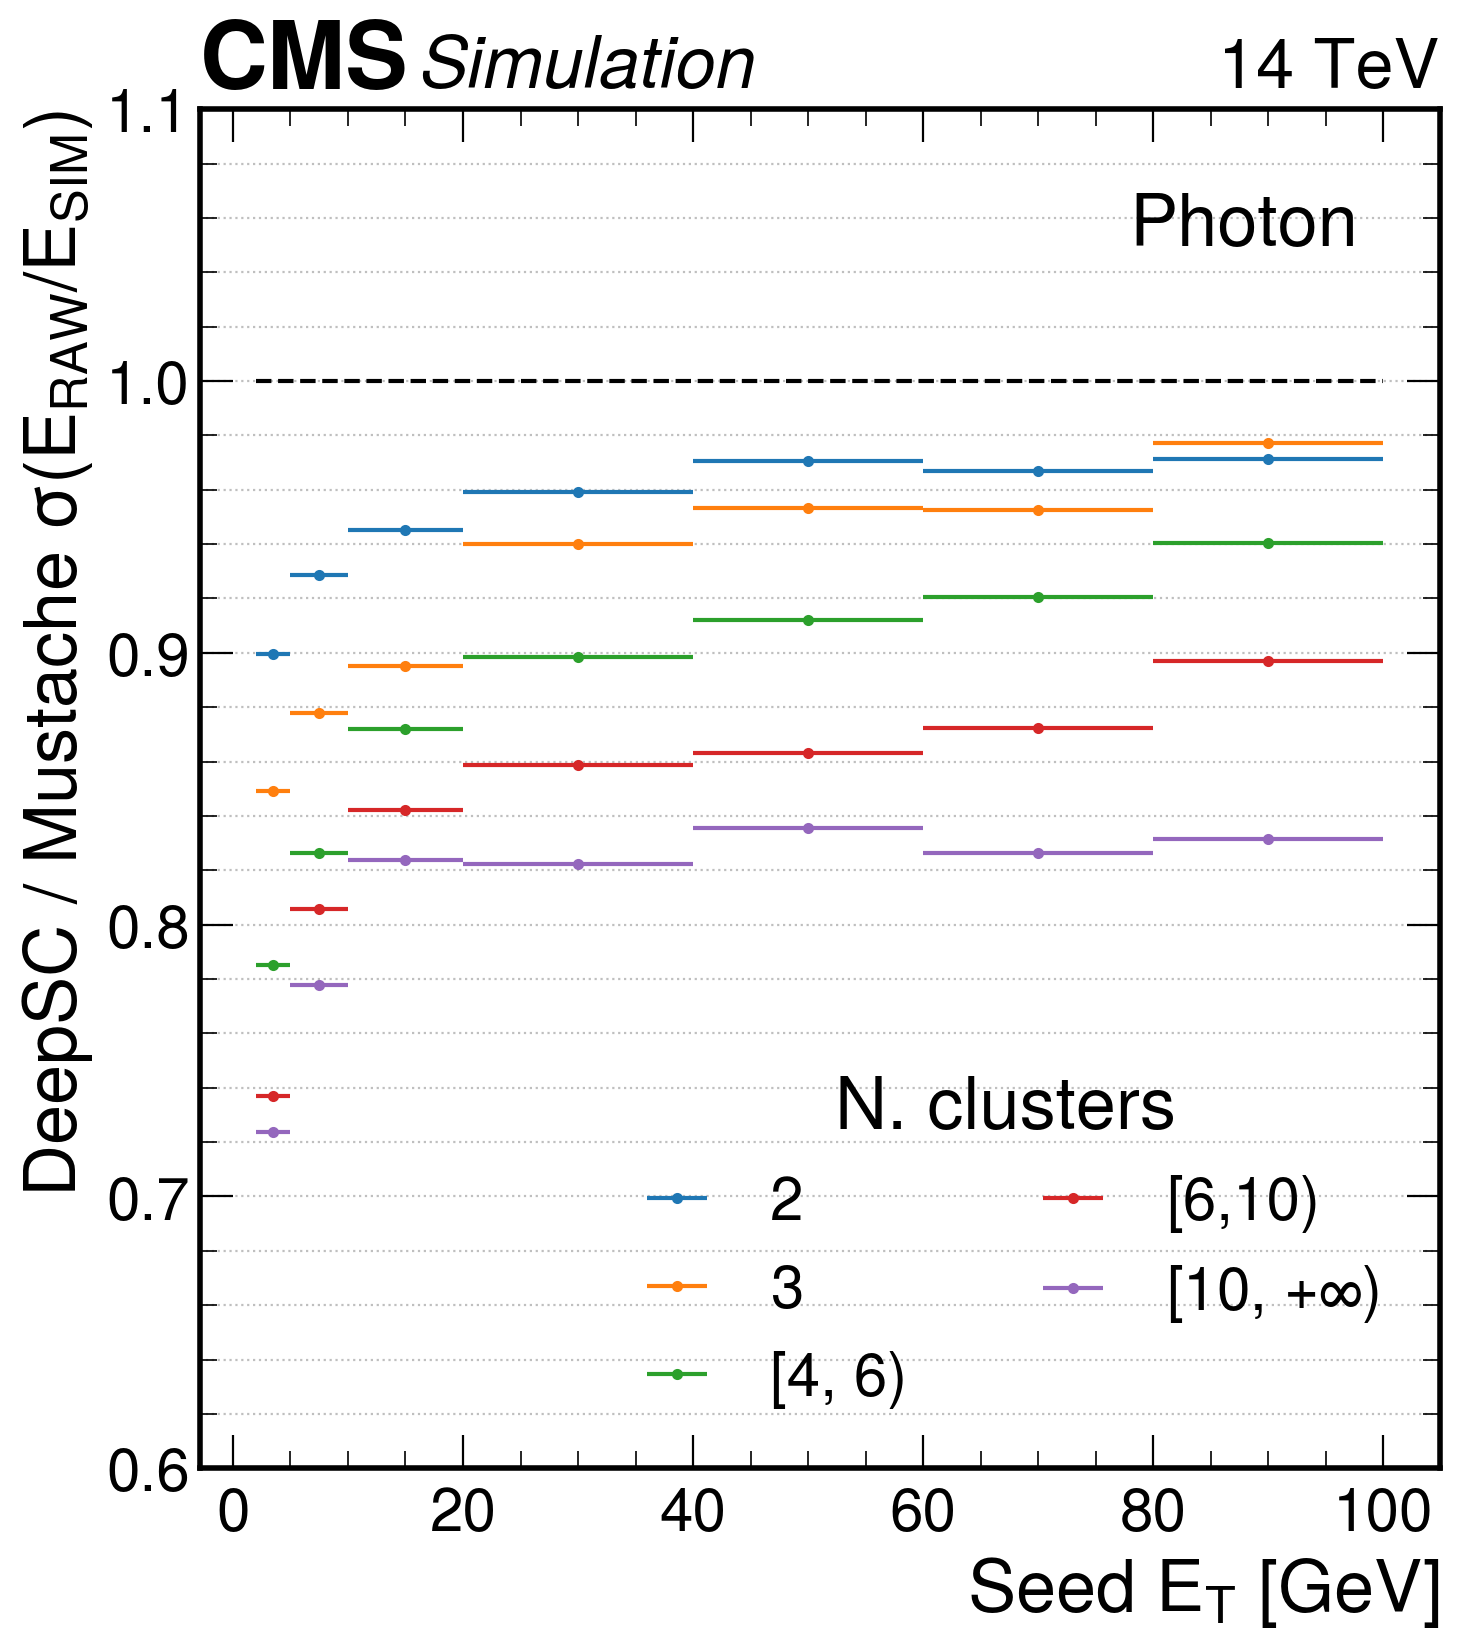

In [177]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):

    fig, ax = plt.subplots(1,1, figsize=(8,9),dpi=200, )

    ets = [2,5,10,20,40,60,80,100]
    ncls = [2,3,4,6,10,15]
    
    legends = ["2", "3", "[4, 6)", "[6,10)","[10, $+\infty$)"]
    df["et_bin"] = pd.cut(df.et, ets, labels=list(range(len(ets)-1)))
    df["ncls_bin"] = pd.cut(df.ncls, ncls, labels=list(range(len(ncls)-1)))


    res = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)


    # gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[0.8,0.2])
    # axs = gs.subplots(sharex=True)

    for ieta, eta in enumerate(ncls[:-1]):
        ax.errorbar(x, res[res.ncls_bin == ieta].w68/res_must[res_must.ncls_bin == ieta].w68, xerr=errx, label=legends[ieta], fmt=".")


    ax.set_ylim(0.6, 1.1)
    ax.set_ylabel("DeepSC / Mustache $\sigma (E_{RAW}/E_{SIM})$")
    ax.legend(ncol=2, title="N. clusters")

    ax.set_xlabel("Seed $E_T$ [GeV]")
    ax.plot([min(ets),max(ets)],[1,1], linestyle="dashed", color="black")

    ax.grid(axis="y", which="both")
    ax.text(0.75, 0.9, flavour, transform=ax.transAxes)

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax)



# N vtx analysis

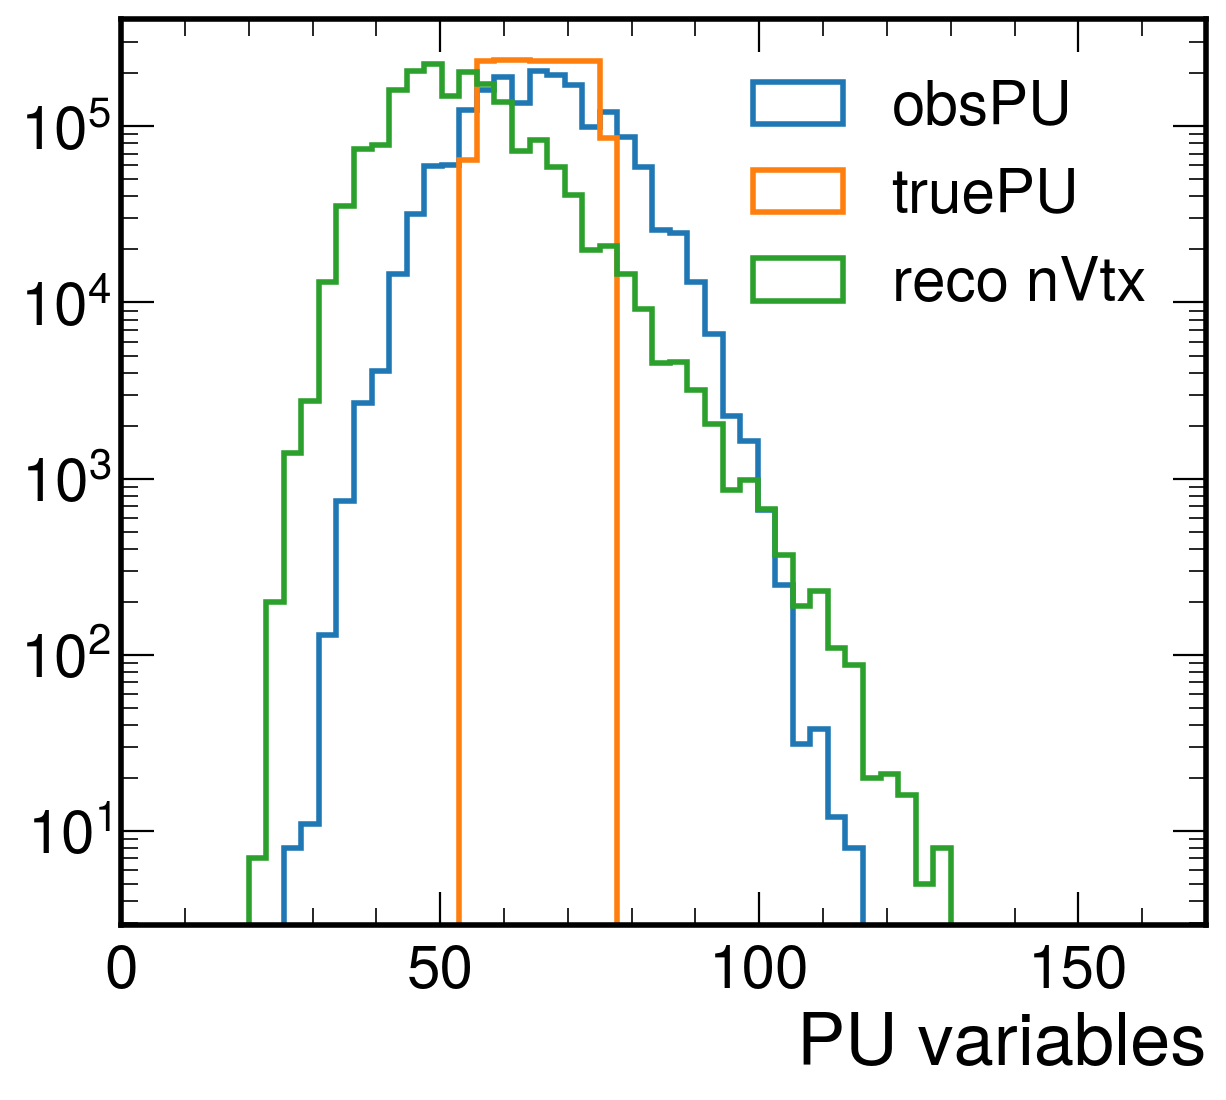

In [126]:
f = plt.figure(figsize=(7,6), dpi=200)
plt.hist(df_tot.obsPU, bins=40, range=(20,130), histtype="step",linewidth=2, label="obsPU",)
plt.hist(df_tot.truePU, bins=40, range=(20,130), histtype="step",linewidth=2, label="truePU")
plt.hist(df_tot.nVtx, bins=40, range=(20,130), histtype="step",linewidth=2, label="reco nVtx")
plt.legend()
plt.xlim(0, 170)
# plt.ylim(0, 1e5)
plt.xlabel("PU variables")
plt.yscale("log")

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,  107., 1680.,
        2151., 2211., 2197., 2092., 2038., 2012., 1956., 1922., 1739.,
        1791., 1748., 1665., 1578., 1642., 1543., 1643., 1567., 1458.,
        1580., 1543., 1527., 1443., 1513., 1526., 1489., 1527., 1452.,
        1508., 1370., 1405., 1377., 1368., 1384., 1358., 1367., 1324.,
        1391., 1363., 1355., 1405., 1240., 1386., 1327., 1345., 1397.,
        1332., 1282., 1282., 1356., 1252., 1306., 1277., 1292., 1281.,
        1261., 1261., 1265., 1266., 1243., 1236., 1216., 1178., 1206.,
        1215., 1226., 1197., 1260., 1166., 1221., 1261., 1172., 1195.,
        1150., 1260., 1169., 1250., 1229., 1161., 1181., 1205., 1184.,
        1153., 1131., 1124., 1143., 1109., 1154., 1107., 1122., 1122.,
        1136.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9

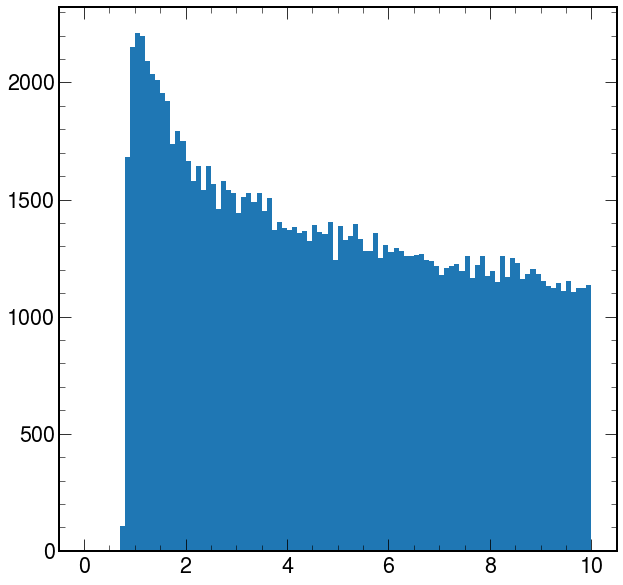

In [154]:
plt.hist(df_ele.et, bins=100, range=(0,10))

Text(1, 0, 'ieta')

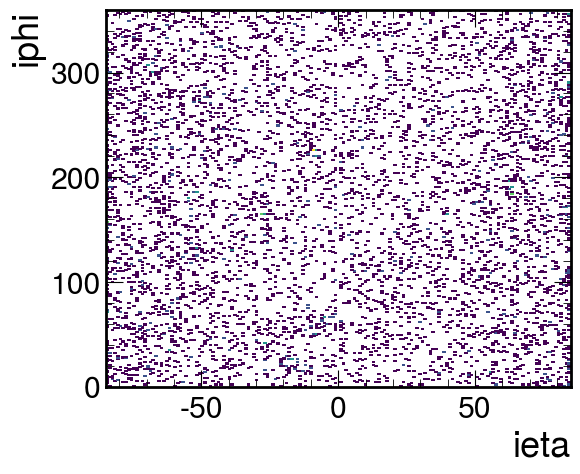

In [170]:
f, ax, = plt.subplots(1,1, figsize=(6,5), dpi=100)

df = df_ele
ax.hist2d(df[(df.seed_iz==0)&(df.et < 1.5)].seed_ieta, df[(df.seed_iz==0)&(df.et < 1.5)].seed_iphi, range=((-85,85),(0,360)), bins=(171,360), cmin=1)

ax.set_ylabel("iphi")
ax.set_xlabel("ieta")

Text(1, 0, 'iphi')

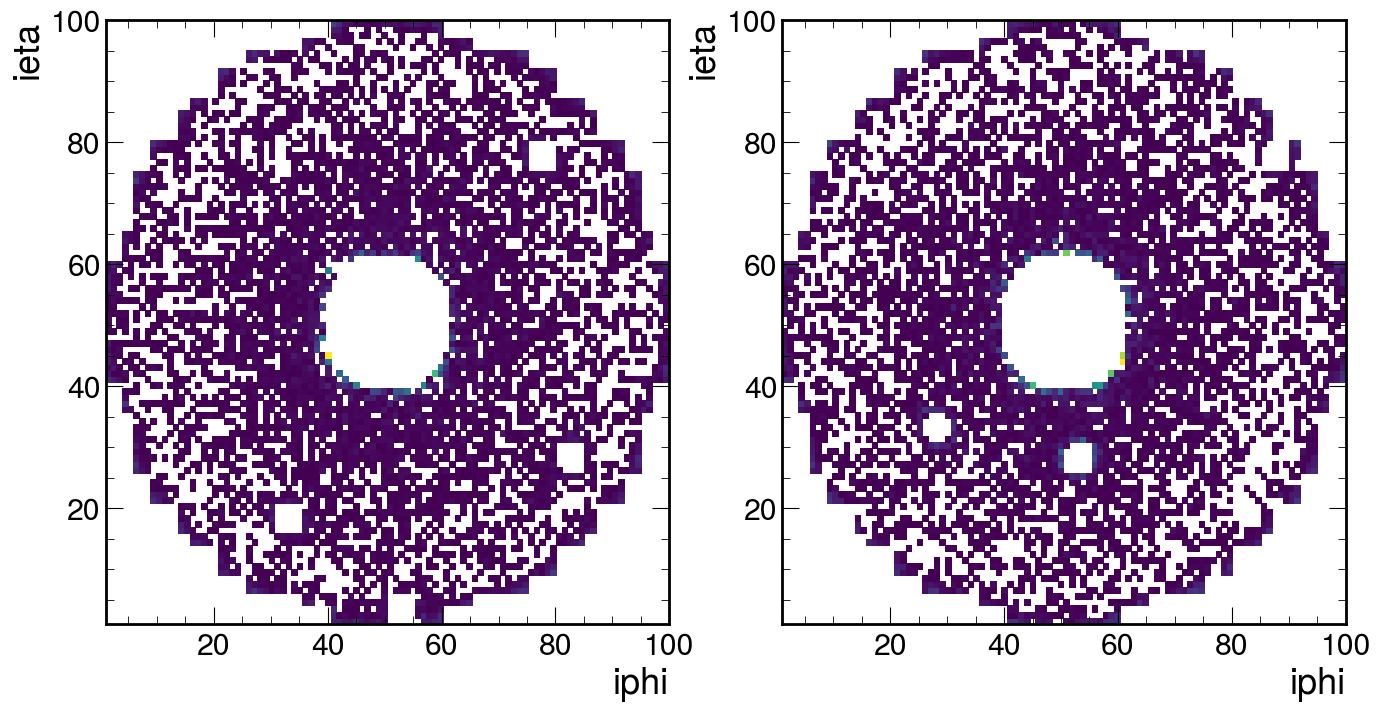

In [169]:
f, ax, = plt.subplots(1,2, figsize=(16,8), dpi=100)

E= 3
ax[0].hist2d(df[(df.seed_iz==1)&(df.et < E)].seed_ieta, df[(df.seed_iz==1)&(df.et < E)].seed_iphi, range=((1,100),(1,100)), bins=(100,100), cmin=1)
ax[1].hist2d(df[(df.seed_iz==-1)&(df.et < E)].seed_ieta, df[(df.seed_iz==-1)&(df.et < E)].seed_iphi, range=((1,100),(1,100)), bins=(100,100), cmin=1)


ax[0].set_ylabel("ieta")
ax[0].set_xlabel("iphi")
ax[1].set_ylabel("ieta")
ax[1].set_xlabel("iphi")

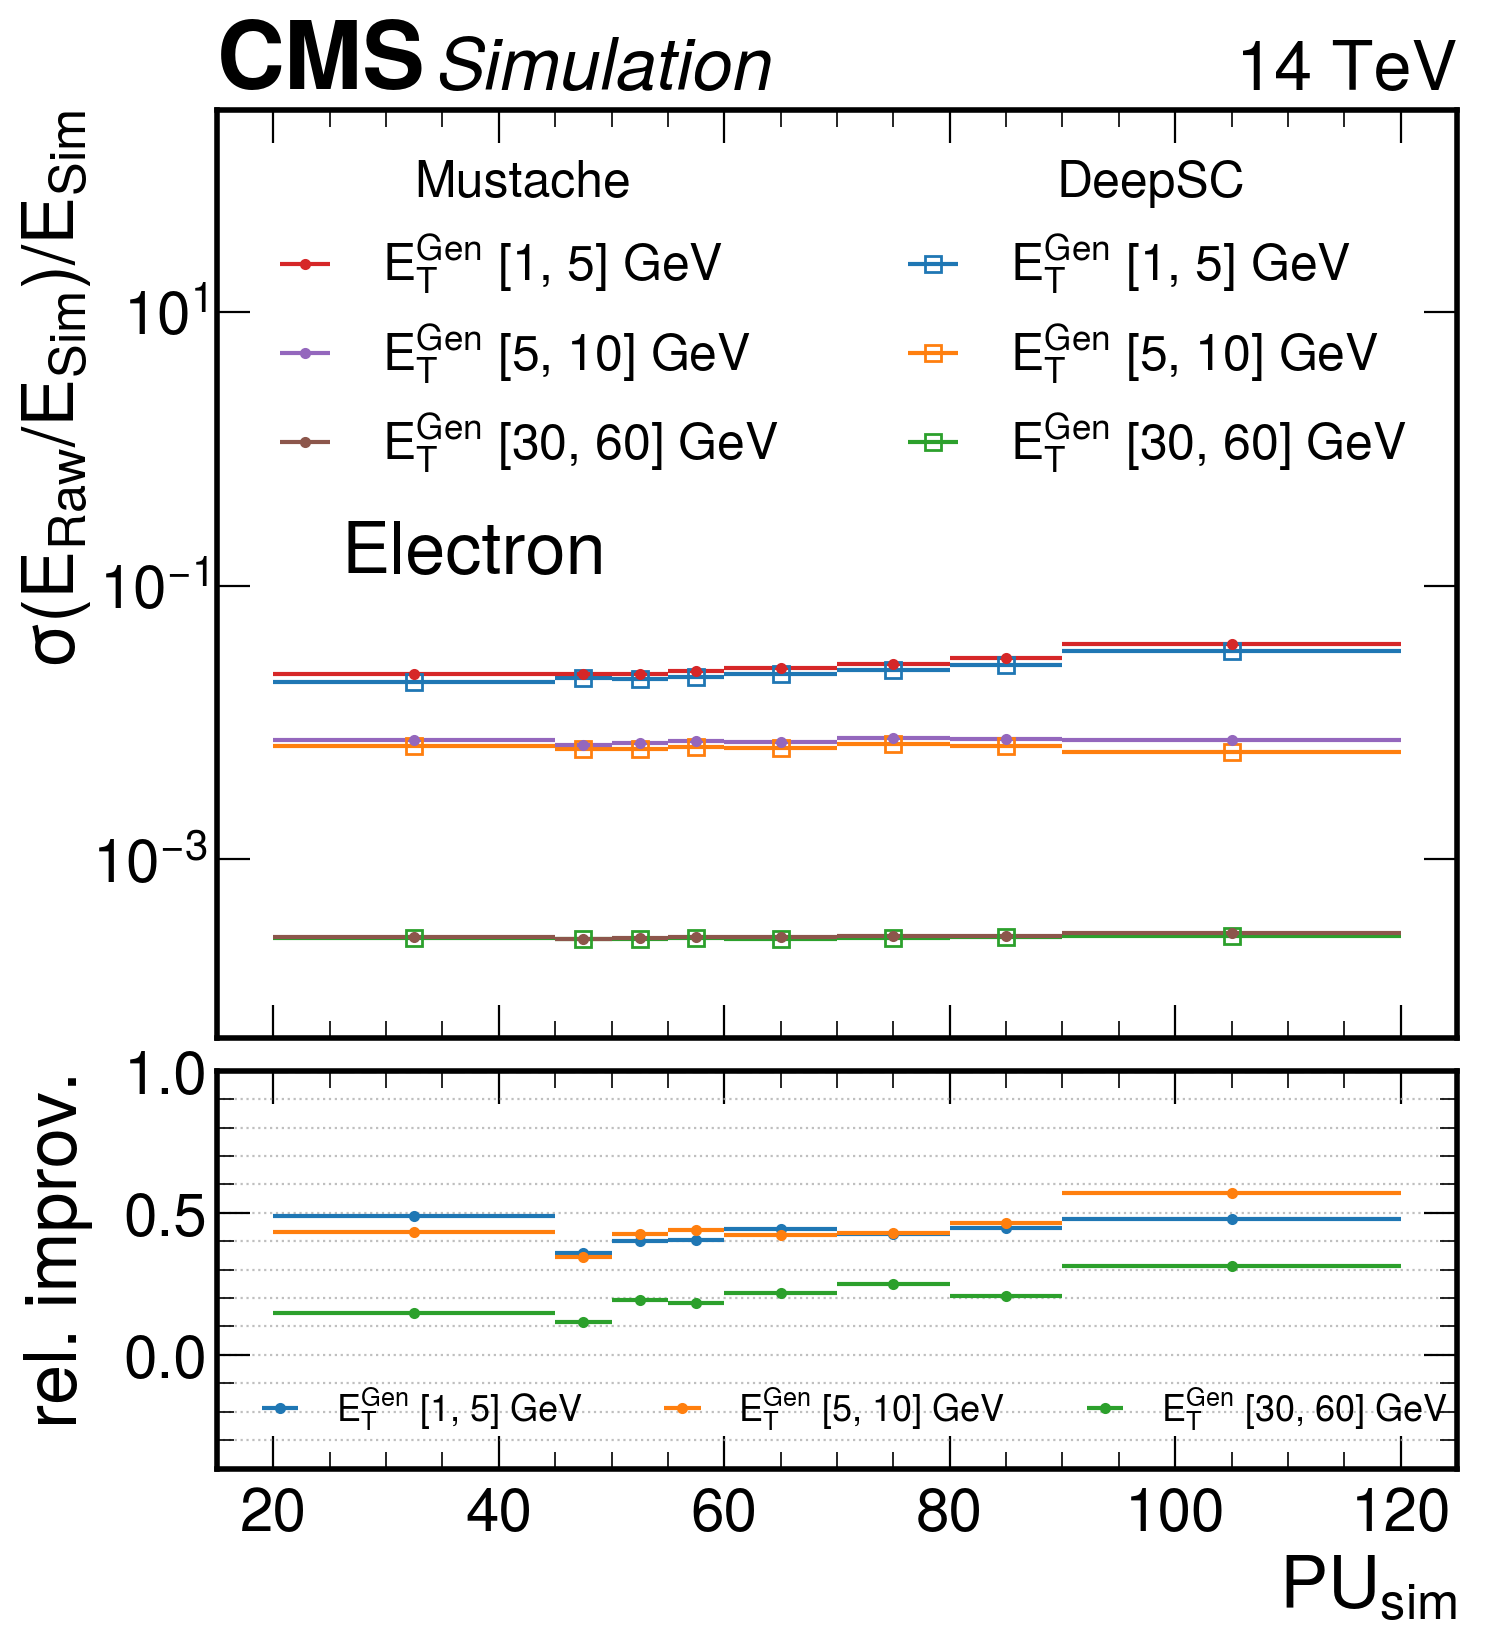

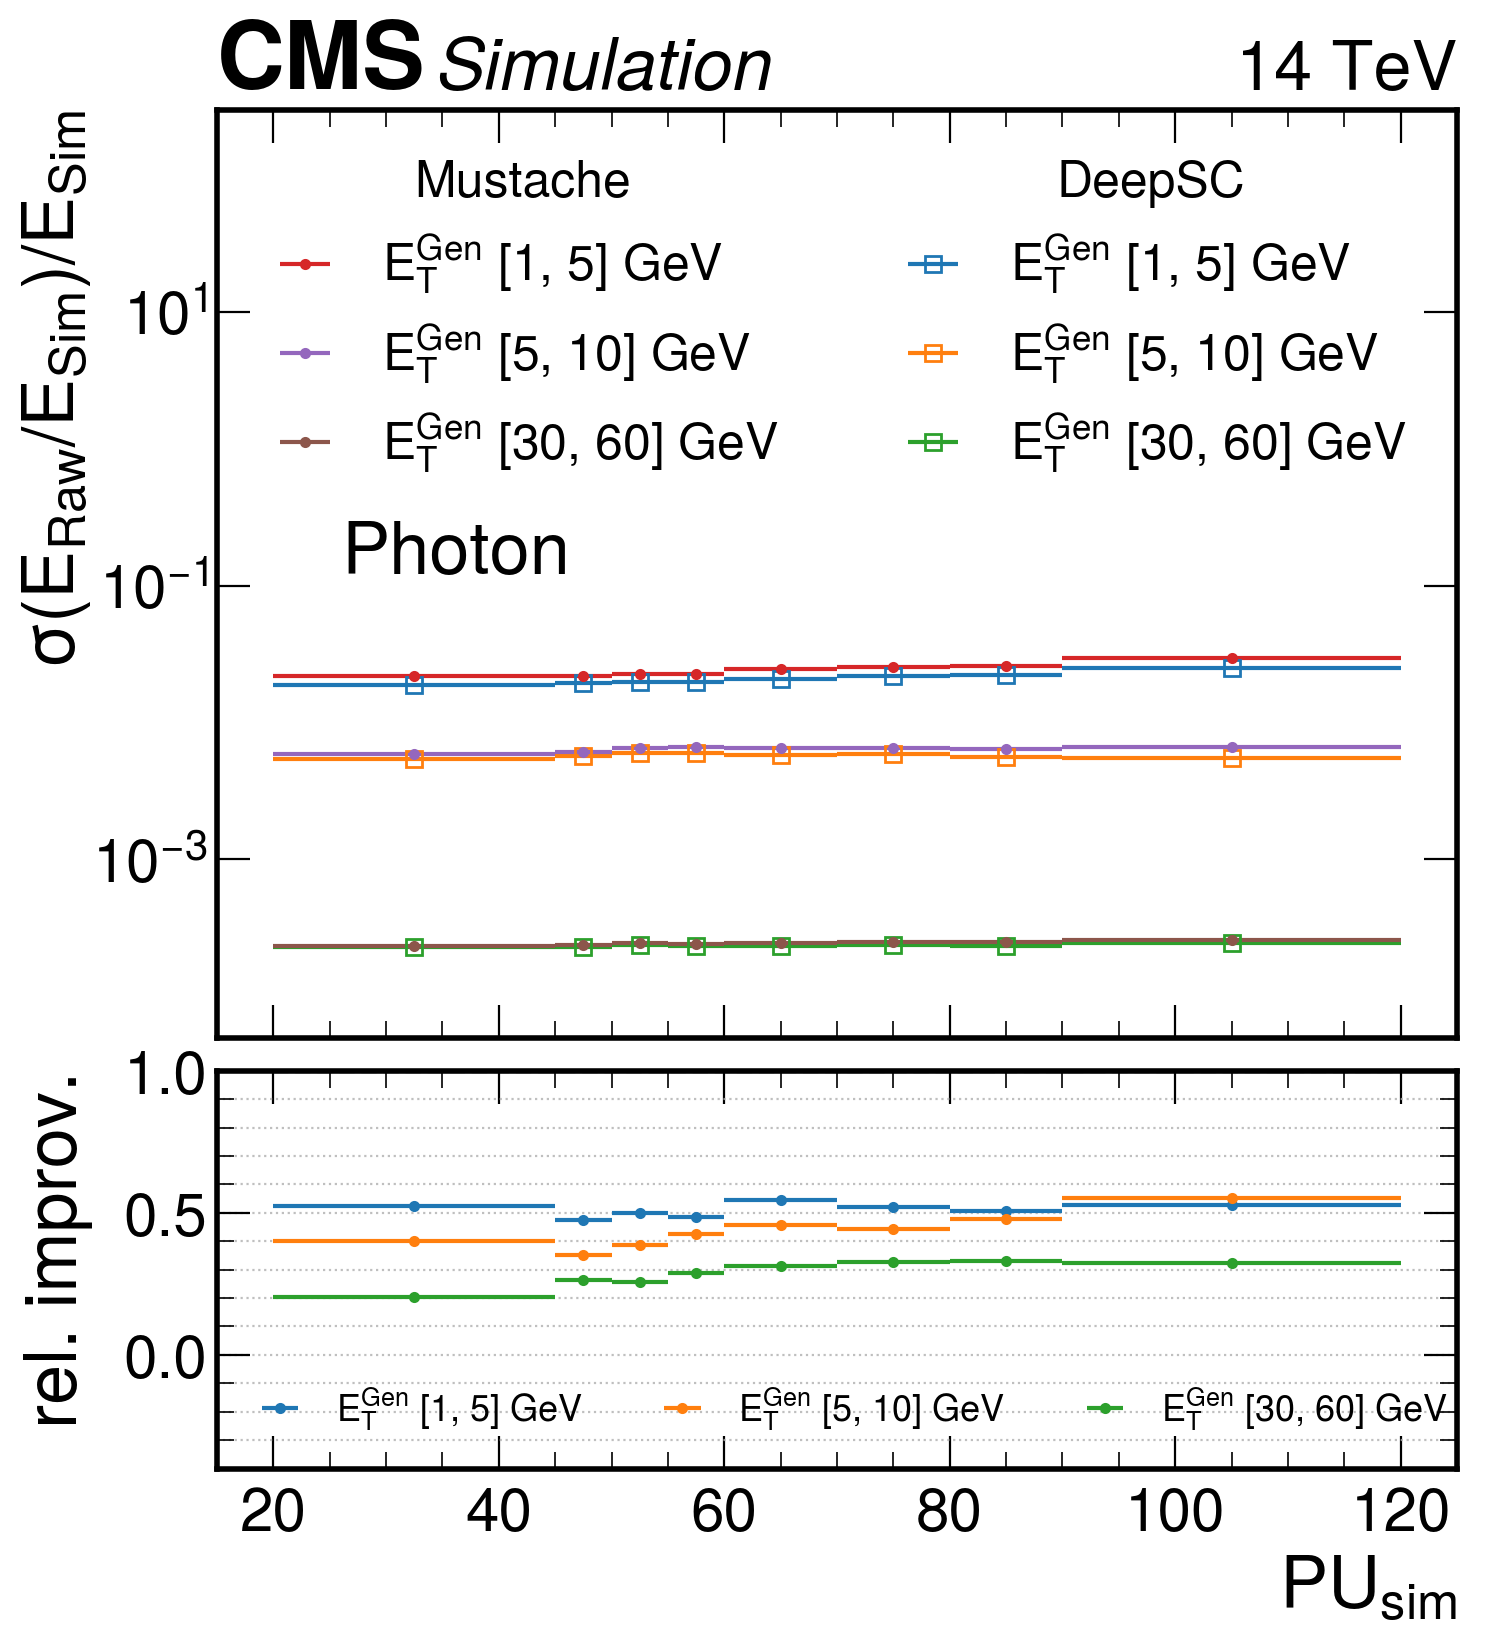

In [18]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
    nvtx = [20,45,50,55,60,70,80,90,120]
    ets = [1,5,10,30,60]
    iplot =[0,1,3]
    df["nvtx_bin"] = pd.cut(df.obsPU, nvtx, labels=list(range(len(nvtx)-1)))
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))

    res = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
    avgenraw = df.groupby(["nvtx_bin","et_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    avgenraw.reset_index(level=0, inplace=True)
    avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.7,0.3])
    ax, ar = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(nvtx)-1):
        errx.append((nvtx[i+1]- nvtx[i])/2)
        x.append((nvtx[i+1]+ nvtx[i])/2)
        
    mustl = []
    deepl = []

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res[res.et_bin == iet].w68 /avgenraw[avgenraw.et_bin ==iet].en_true_sim_good, xerr=errx,
                    label="$E_T^{Gen}$" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]), marker="s", markerfacecolor='none', linestyle='none')
        deepl.append(l)
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res_must[res_must.et_bin == iet].w68/ avgenraw[avgenraw.et_bin ==iet].en_true_sim_good ,
                        xerr=errx, label="$E_T^{Gen}$" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)
    
    ax.set_ylim(5e-5, 3e2)
    ax.set_ylabel("$\sigma (E_{Raw}/E_{Sim})/E_{Sim}$")
    
    
#     ax.legend(ncol=2, fontsize='x-small', loc="upper left", title="Seed $E_T$", title_fontsize="small")
    l1= ax.legend(handles=mustl, title="Mustache", title_fontsize=18, loc="upper left", fontsize=18)
    ax.legend(handles=deepl, title="DeepSC", title_fontsize=18, loc="upper right", fontsize=18)
    ax.add_artist(l1)

    ax.text(0.1, 0.5, flavour, transform=ax.transAxes)
    hep.cms.label( loc=0, ax=ax, rlabel="14 TeV")

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        ar.errorbar(x, var, xerr=errx, fmt=".", label="$E_T^{Gen}$" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]))
        
    ar.set_ylim(-0.4, 1)
    ar.set_ylabel("rel. improv.")
    ax.get_yaxis().set_label_coords(-0.1,1)
    ar.get_yaxis().set_label_coords(-0.1,1)
    
    ar.legend(ncol=3,prop={'size': 13}, loc="lower left" )
    
    ar.set_xlabel("$PU_{sim}$")
    ax.set_yscale("log")
    ar.grid(axis="y", which="both")
    ar.plot([min(nvtx), max(nvtx)],[1,1], linestyle="dashed", color="black")



# Resolution by $PU_{SIM}$

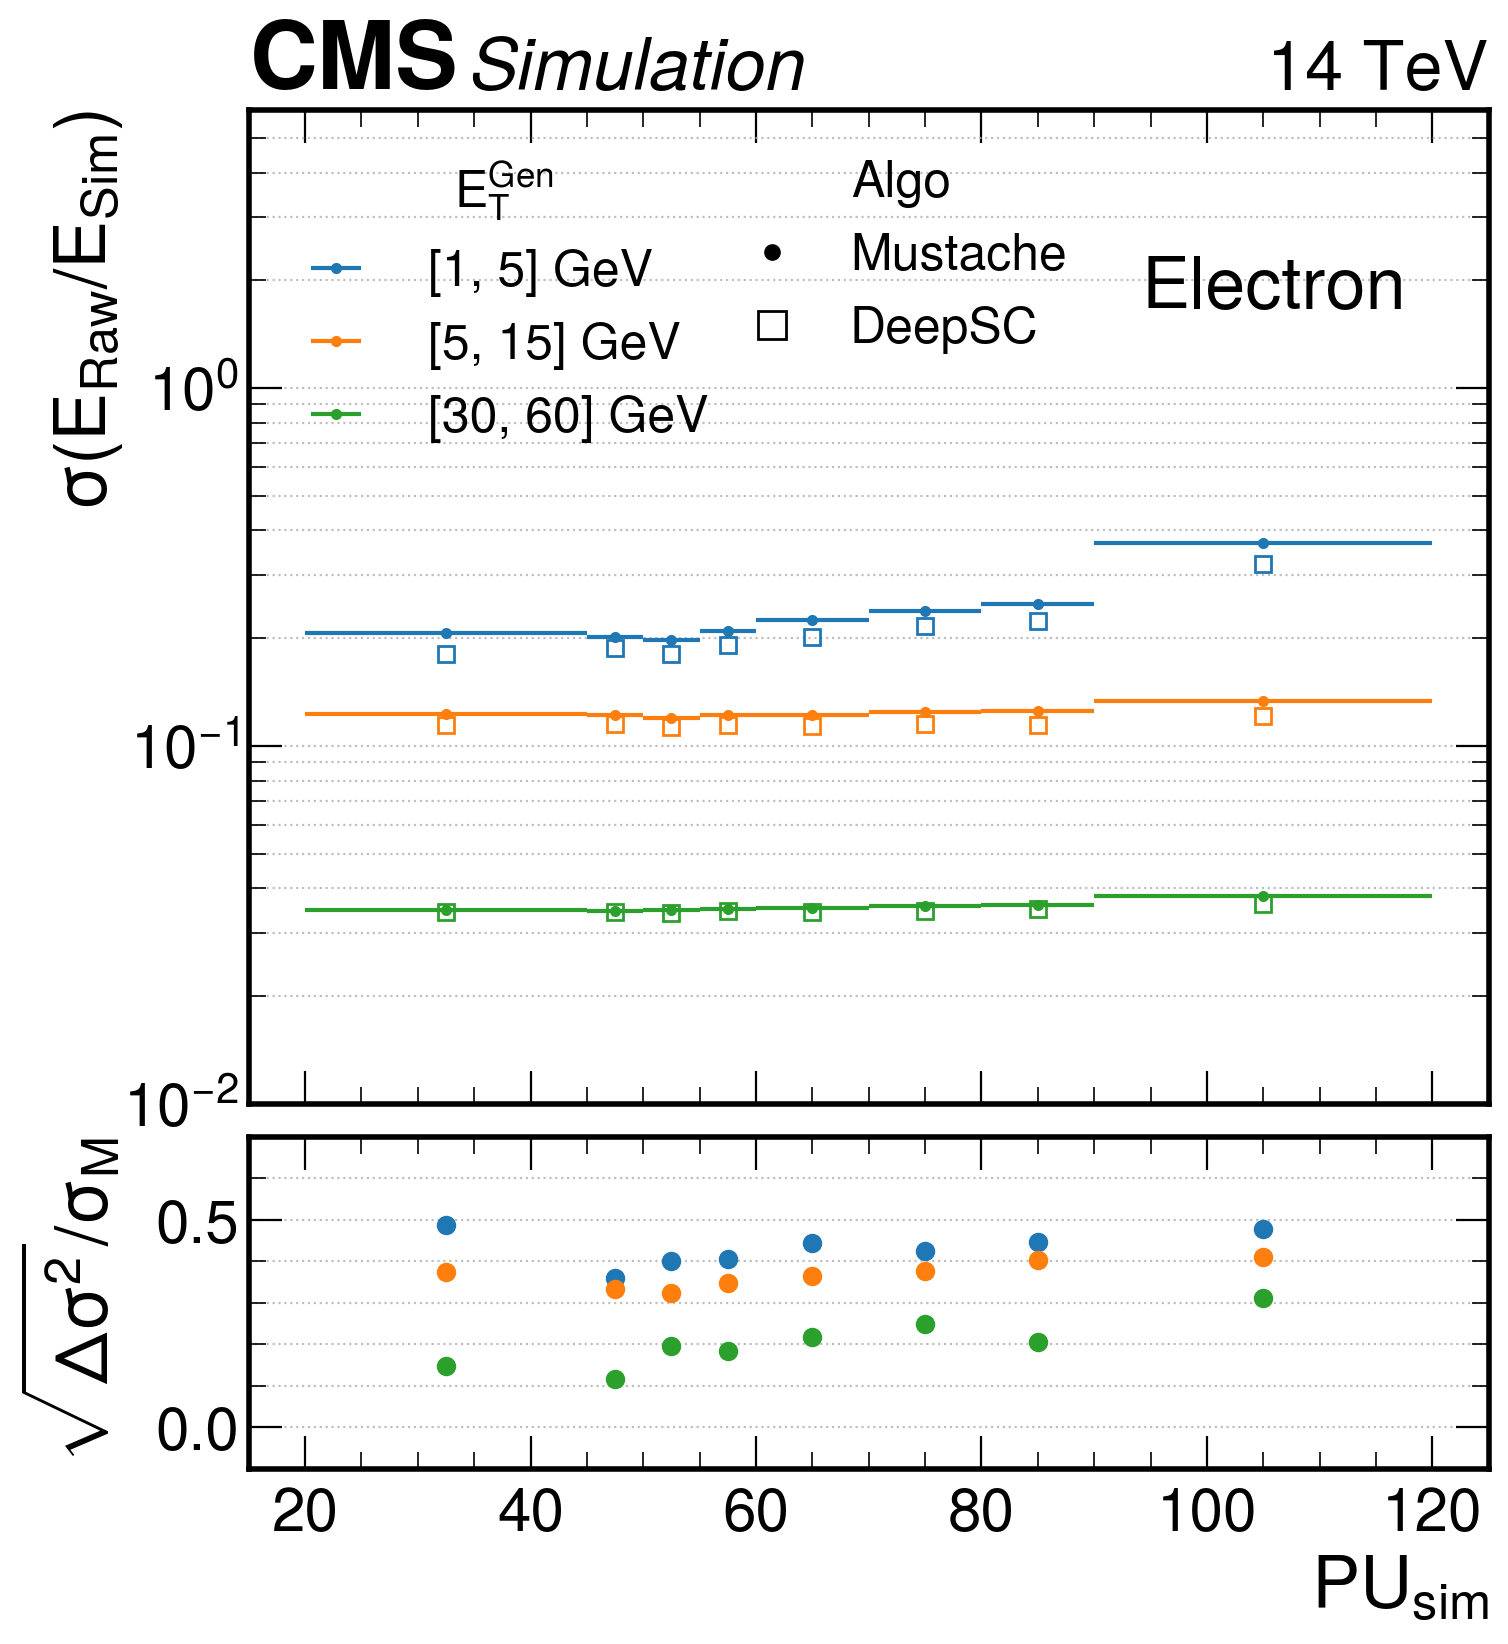

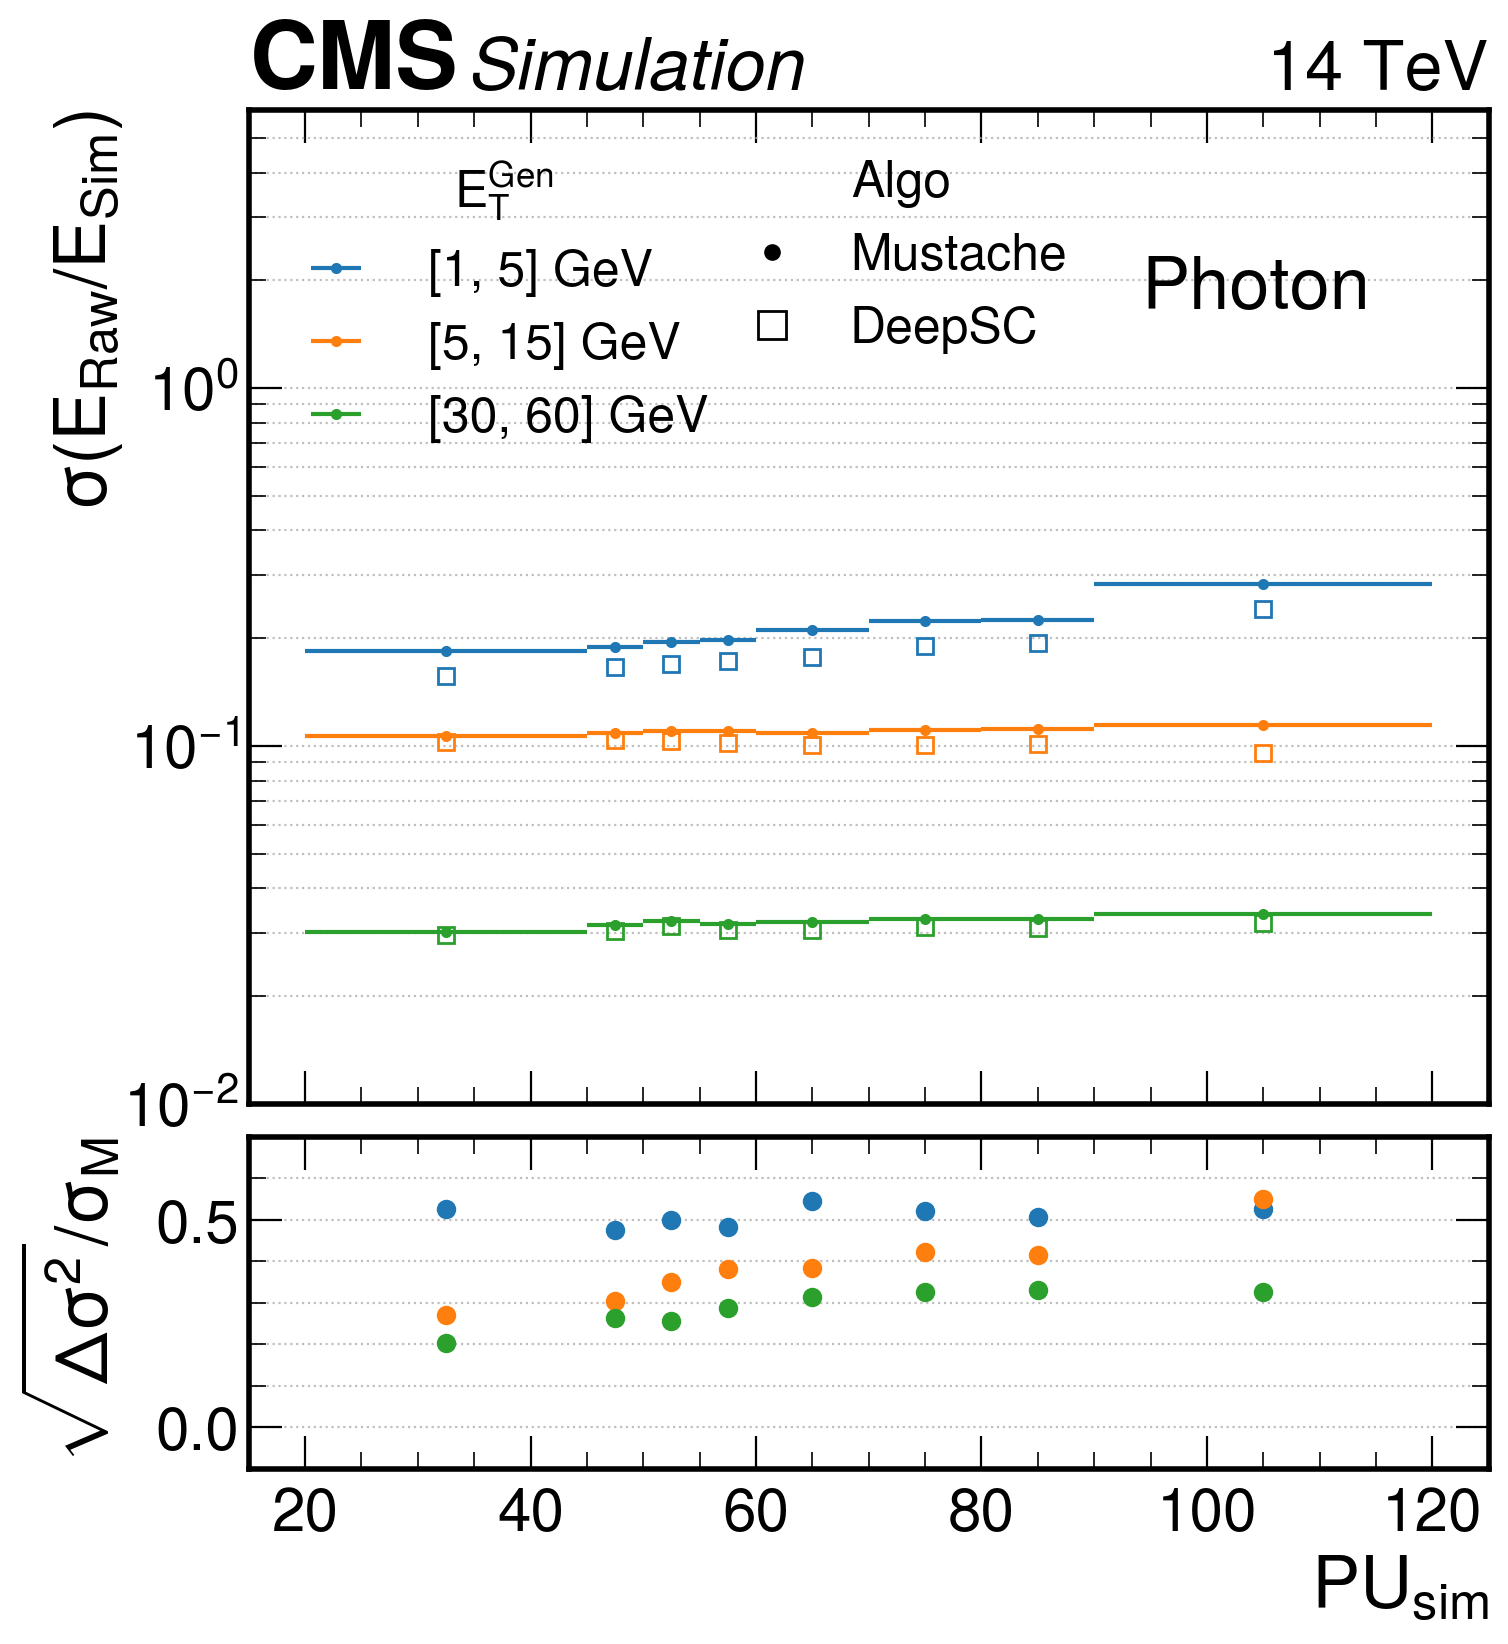

In [14]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
    nvtx = [20,45,50,55,60,70,80,90,120]
    ets = [1,5,15,30,60]
    iplot =[0,1,3]
    df["nvtx_bin"] = pd.cut(df.obsPU, nvtx, labels=list(range(len(nvtx)-1)))
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))

    res = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["nvtx_bin","et_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    ax, ar = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(nvtx)-1):
        errx.append((nvtx[i+1]- nvtx[i])/2)
        x.append((nvtx[i+1]+ nvtx[i])/2)
        
    mustl = []
    deepl = []
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label=" [{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)
        
    i =0
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res[res.et_bin == iet].w68 , xerr=errx,
                    label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), marker="s", markerfacecolor='none', 
                    c=mustl[i].lines[0].get_color(), linestyle='none', elinewidth=0)
        i+=1
        deepl.append(l)
    
    ax.set_ylim(1e-2, 6)
    ax.set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")
    ax.grid(axis="y", which="both")
    ax.get_yaxis().set_label_coords(-0.1,1)
    ax.set_yscale("log")
    
#     ax.legend(ncol=2, fontsize='x-small', loc="upper left", title="Seed $E_T$", title_fontsize="small")
    l1= ax.legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    ax.legend(handles=[ml,dl], title="Algo", title_fontsize=18, loc="upper right",bbox_to_anchor=(0.7, 1), fontsize=18)
    ax.add_artist(l1)

    ax.text(0.72, 0.8, flavour, transform=ax.transAxes)
    hep.cms.label( loc=0, ax=ax, rlabel="14 TeV")

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        ar.errorbar(x, var, xerr=errx, label="$E_T^{Gen}$" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),fmt="o", linestyle='none', elinewidth=0 )
        
    ar.set_ylim(-0.1, 0.7)
    ar.set_ylabel("$\sqrt{\Delta\sigma^2}/\sigma_M$")
    
    ar.get_yaxis().set_label_coords(-0.1,1)
    
#     ar.legend(ncol=3,prop={'size': 13}, loc="lower left" )
    
    ar.set_xlabel("$PU_{sim}$")
    ar.grid(axis="y", which="both")

    fig.savefig(output_folder + "/resolution_byPU_{}.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byPU_{}.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byPU_{}.svg".format(flavour))


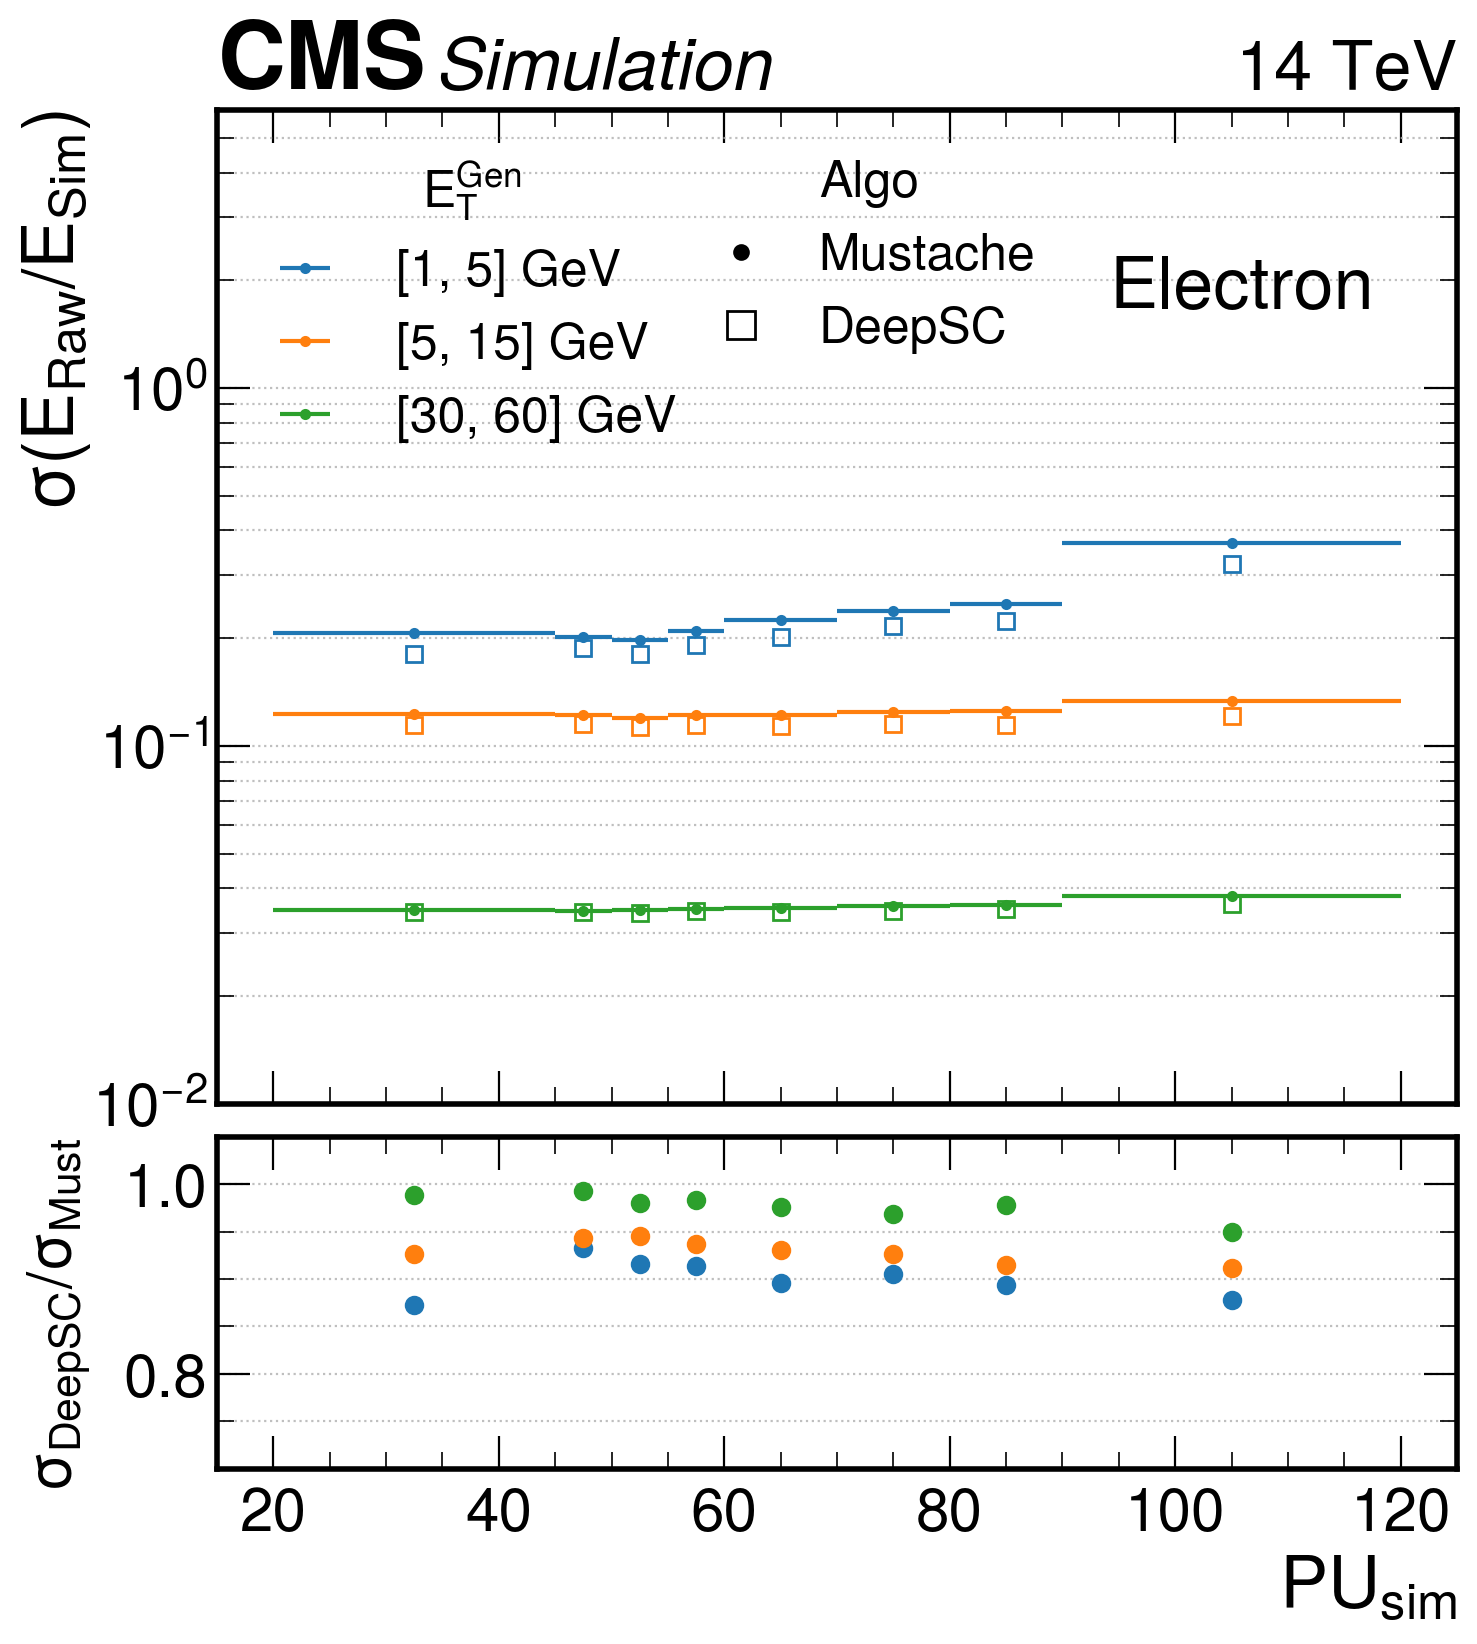

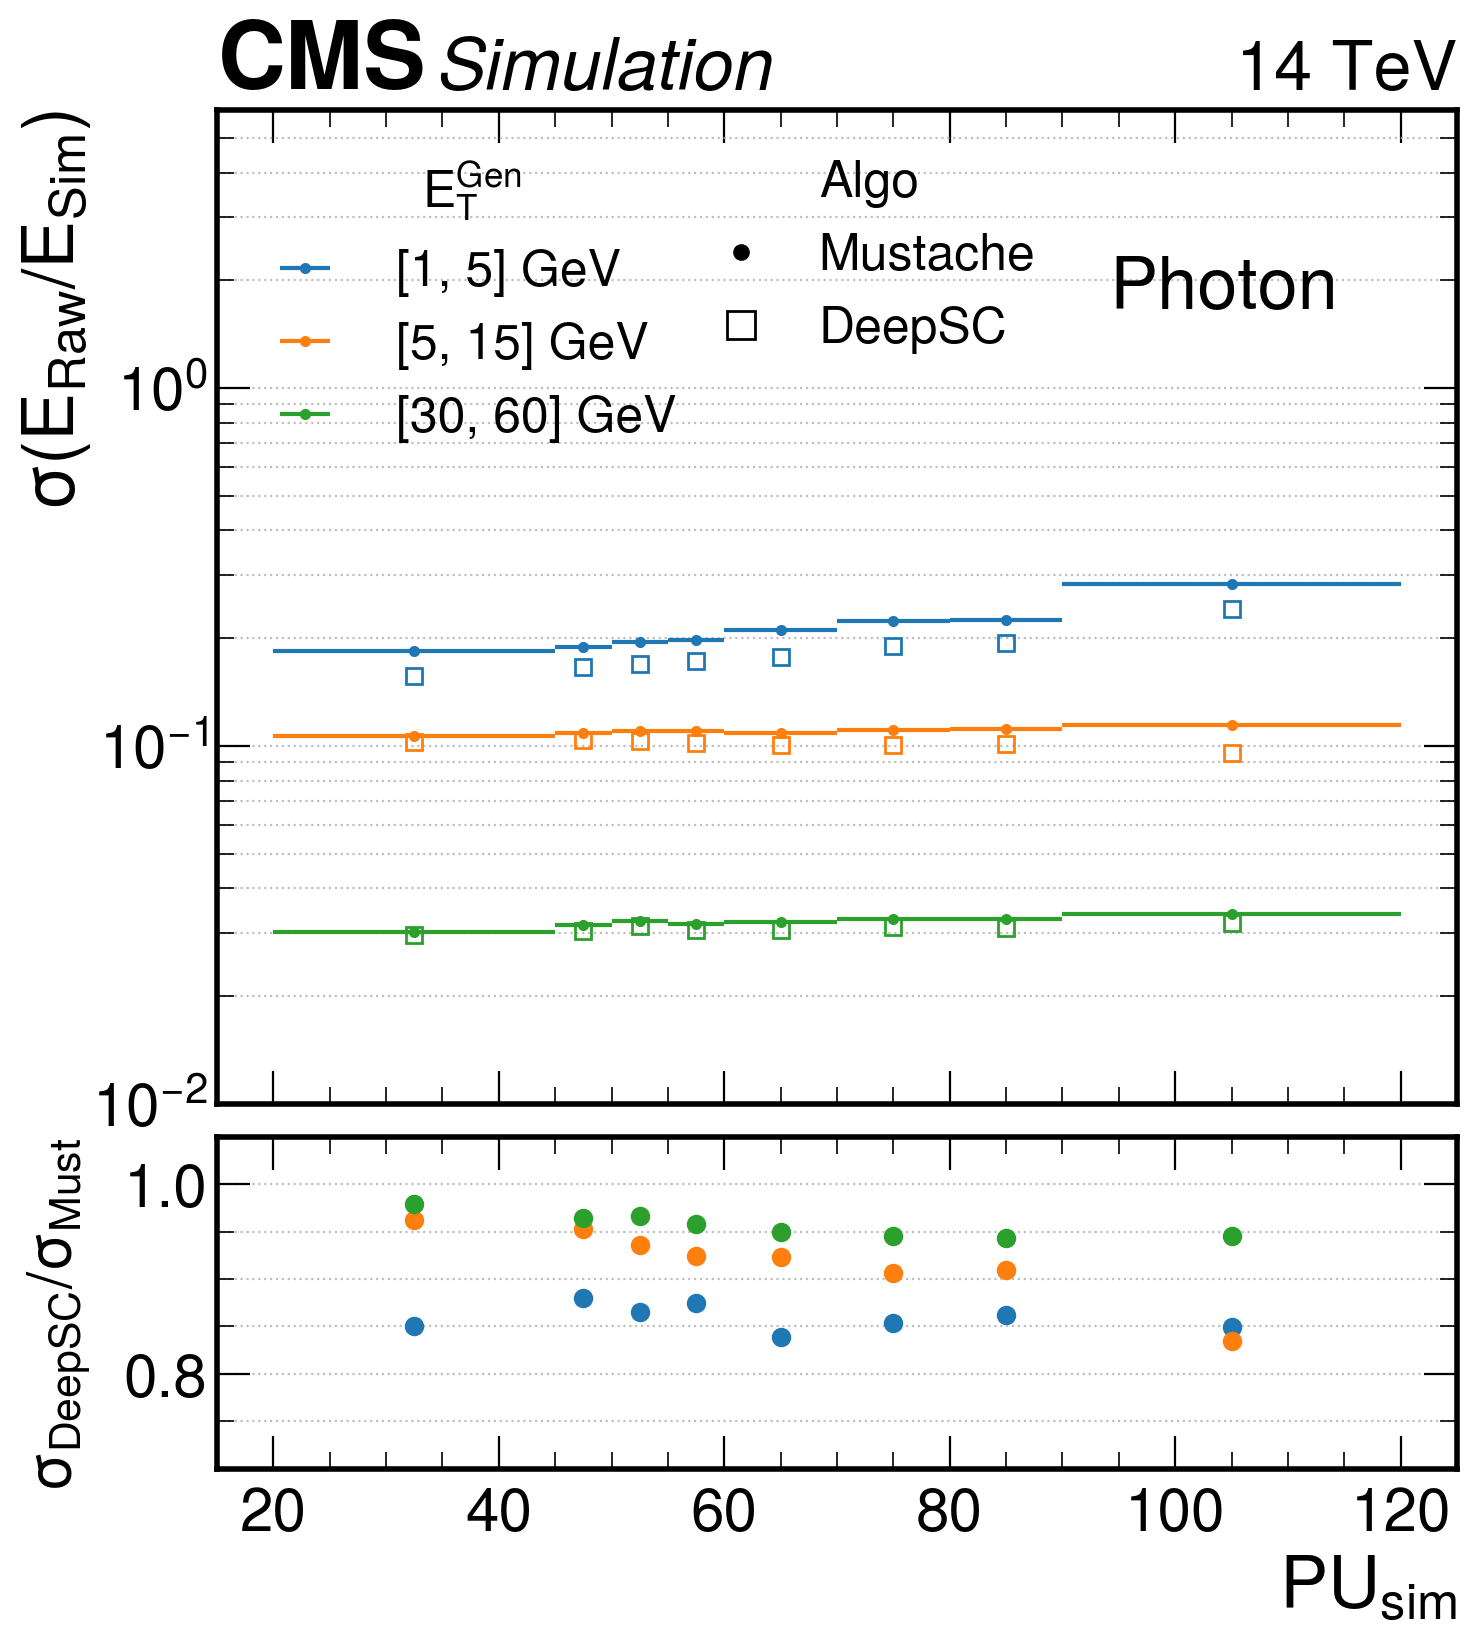

In [17]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
    nvtx = [20,45,50,55,60,70,80,90,120]
    ets = [1,5,15,30,60]
    iplot =[0,1,3]
    df["nvtx_bin"] = pd.cut(df.obsPU, nvtx, labels=list(range(len(nvtx)-1)))
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))

    res = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["nvtx_bin","et_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    ax, ar = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(nvtx)-1):
        errx.append((nvtx[i+1]- nvtx[i])/2)
        x.append((nvtx[i+1]+ nvtx[i])/2)
        
    mustl = []
    deepl = []
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label=" [{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)
        
    i =0
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res[res.et_bin == iet].w68 , xerr=errx,
                    label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), marker="s", markerfacecolor='none', 
                    c=mustl[i].lines[0].get_color(), linestyle='none', elinewidth=0)
        i+=1
        deepl.append(l)
    
    ax.set_ylim(1e-2, 6)
    ax.set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")
    ax.grid(axis="y", which="both")
    ax.get_yaxis().set_label_coords(-0.1,1)
    ax.set_yscale("log")
    
#     ax.legend(ncol=2, fontsize='x-small', loc="upper left", title="Seed $E_T$", title_fontsize="small")
    l1= ax.legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    ax.legend(handles=[ml,dl], title="Algo", title_fontsize=18, loc="upper right",bbox_to_anchor=(0.7, 1), fontsize=18)
    ax.add_artist(l1)

    ax.text(0.72, 0.8, flavour, transform=ax.transAxes)
    hep.cms.label( loc=0, ax=ax, rlabel="14 TeV")

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        #v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        #var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        var = res[res.et_bin == iet].w68 / res_must[res_must.et_bin==iet].w68
        ar.errorbar(x, var, xerr=errx, label="$E_T^{Gen}$" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),fmt="o", linestyle='none', elinewidth=0 )
        
    ar.set_ylim(0.7, 1.05)
    ar.set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    
    ar.get_yaxis().set_label_coords(-0.1,1)
    
#     ar.legend(ncol=3,prop={'size': 13}, loc="lower left" )
    
    ar.set_xlabel("$PU_{sim}$")
    ar.grid(axis="y", which="both")

    fig.savefig(output_folder + "/resolution_byPU_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byPU_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byPU_{}_ratio.svg".format(flavour))


# Ideal improvement by Gen Energy


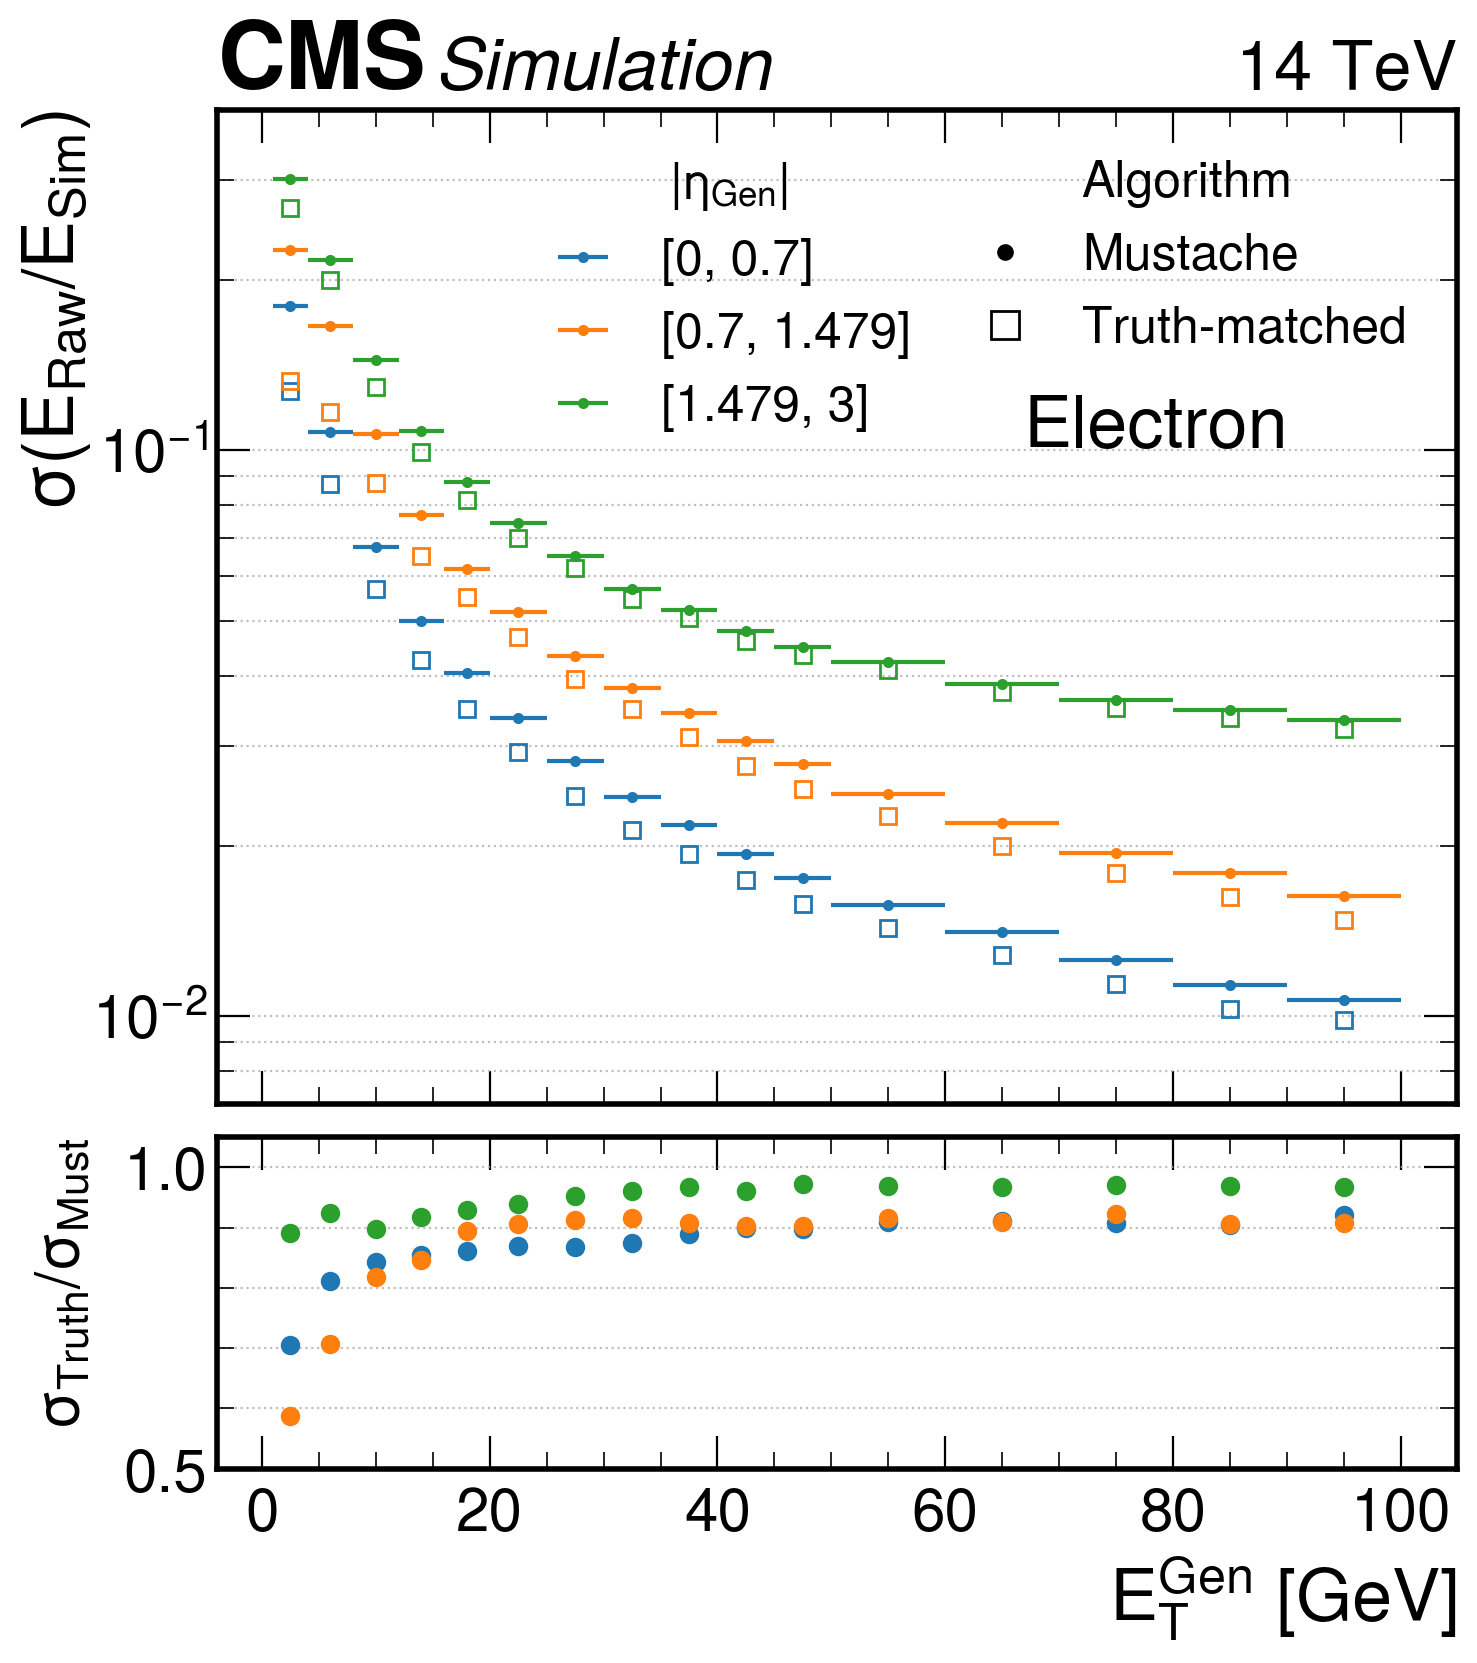

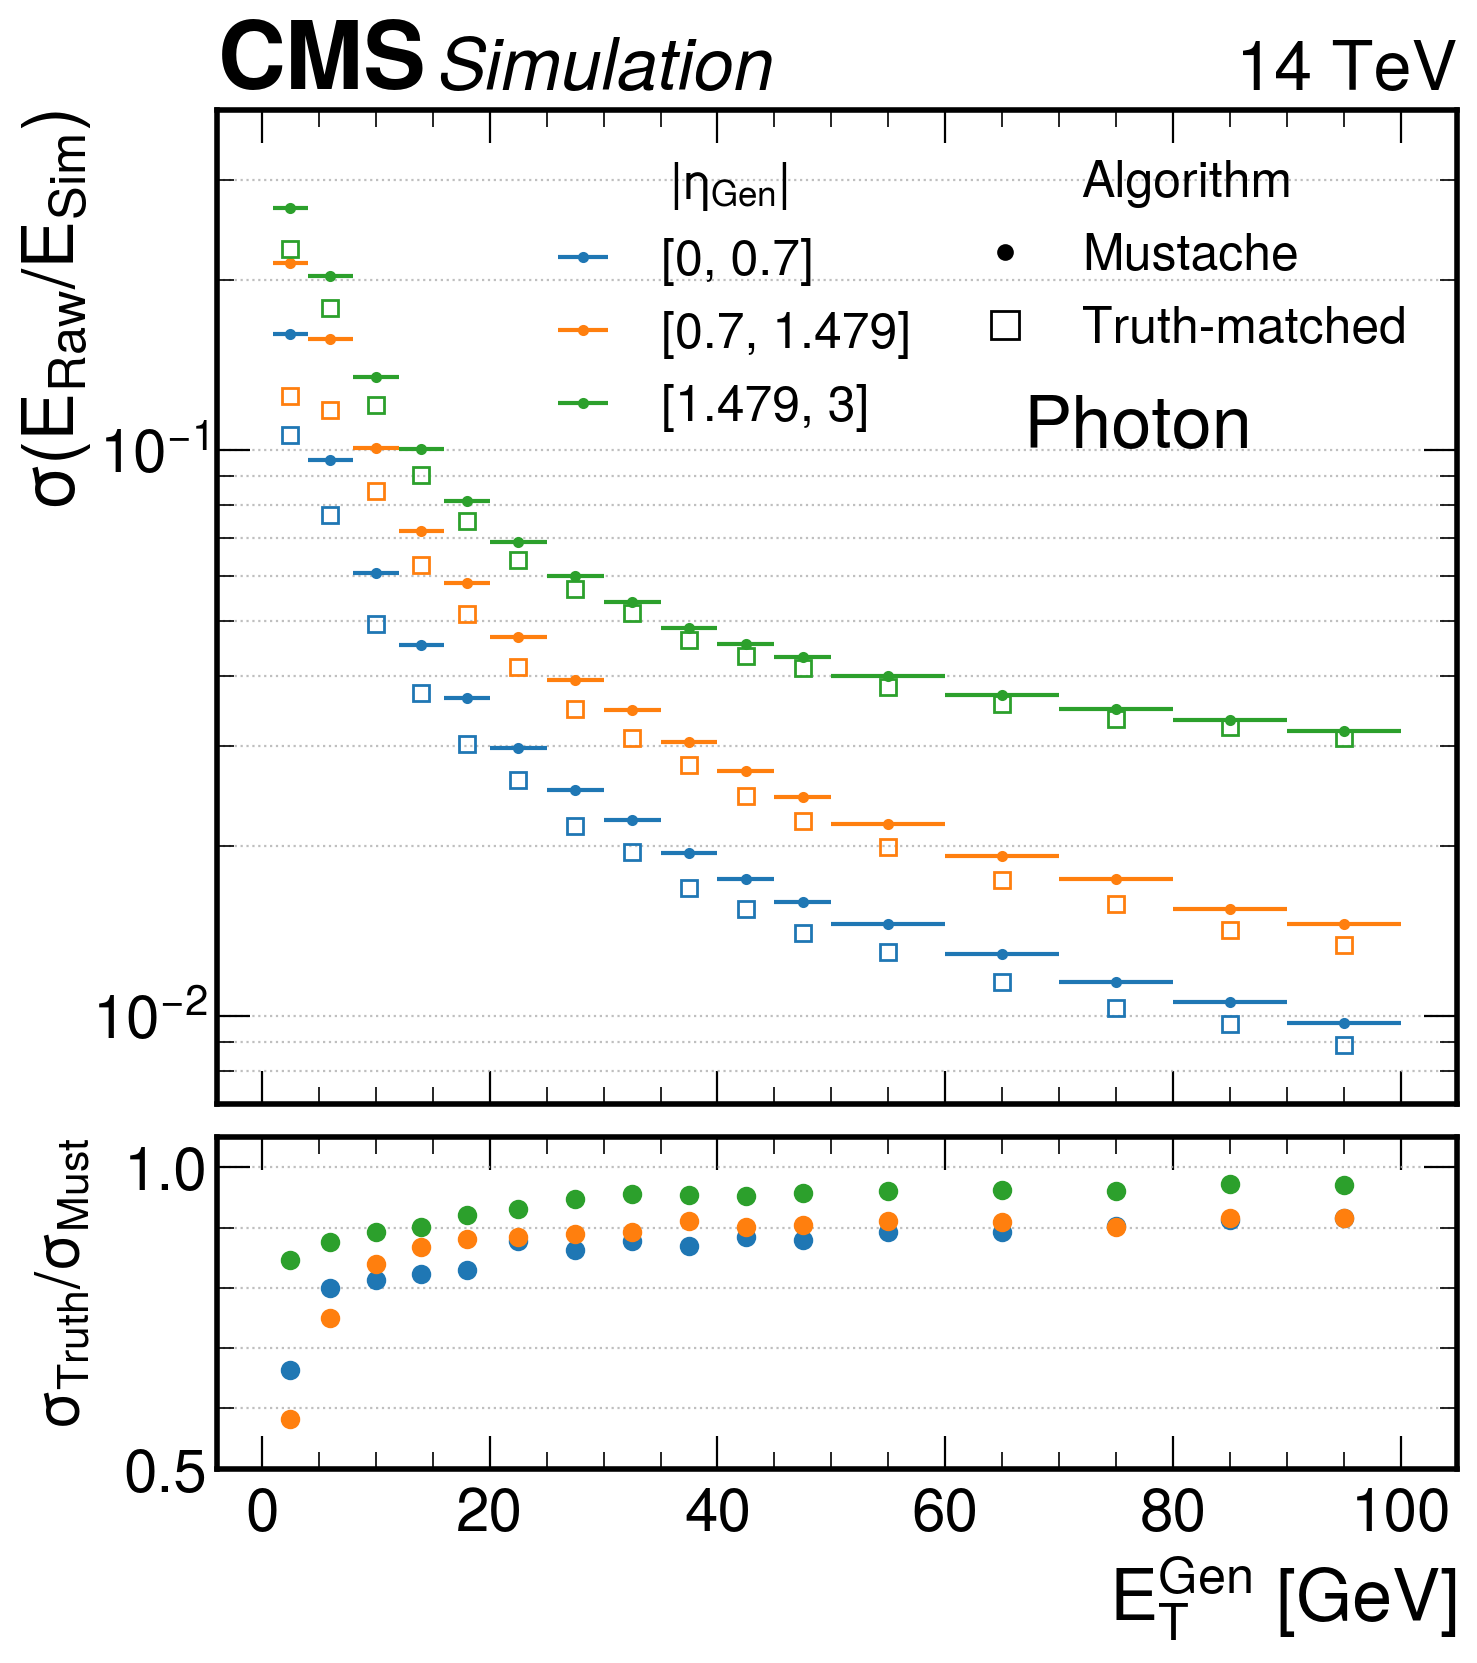

In [14]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [1.00, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    etas = [0, 0.7, 1.479, 3]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.sim_true_eta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("EnTrue_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []


        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)
        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="[{}, {}]".format(etas[ieta], etas[ieta+1]), 
                                marker="s", markerfacecolor='none', c=mustl[ieta].lines[0].get_color(), linestyle='none', elinewidth=0)
        deepl.append(l)
    

    for ieta, eta in enumerate(etas[:-1]):
#         v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
#         var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
        var = res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68
        axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt="o", linestyle='none', elinewidth=0 )

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(7e-3, 0.4)
    axs[1].set_ylim(0.5, 1.05)
    axs[1].set_ylabel("$\sigma_{Truth}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.65, 0.66, flavour, transform=axs[0].transAxes)
    axs[0].set_yscale("log")

    l1= axs[0].legend(handles=mustl, title="$|\eta_{Gen}|$", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='Truth-matched')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")
    axs[0].grid(axis="y", which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_truth_byEnergy_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_truth_byEnergy_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_truth_byEnergy_{}_ratio.svg".format(flavour))

# Resolution by Gen ET and number of clusters

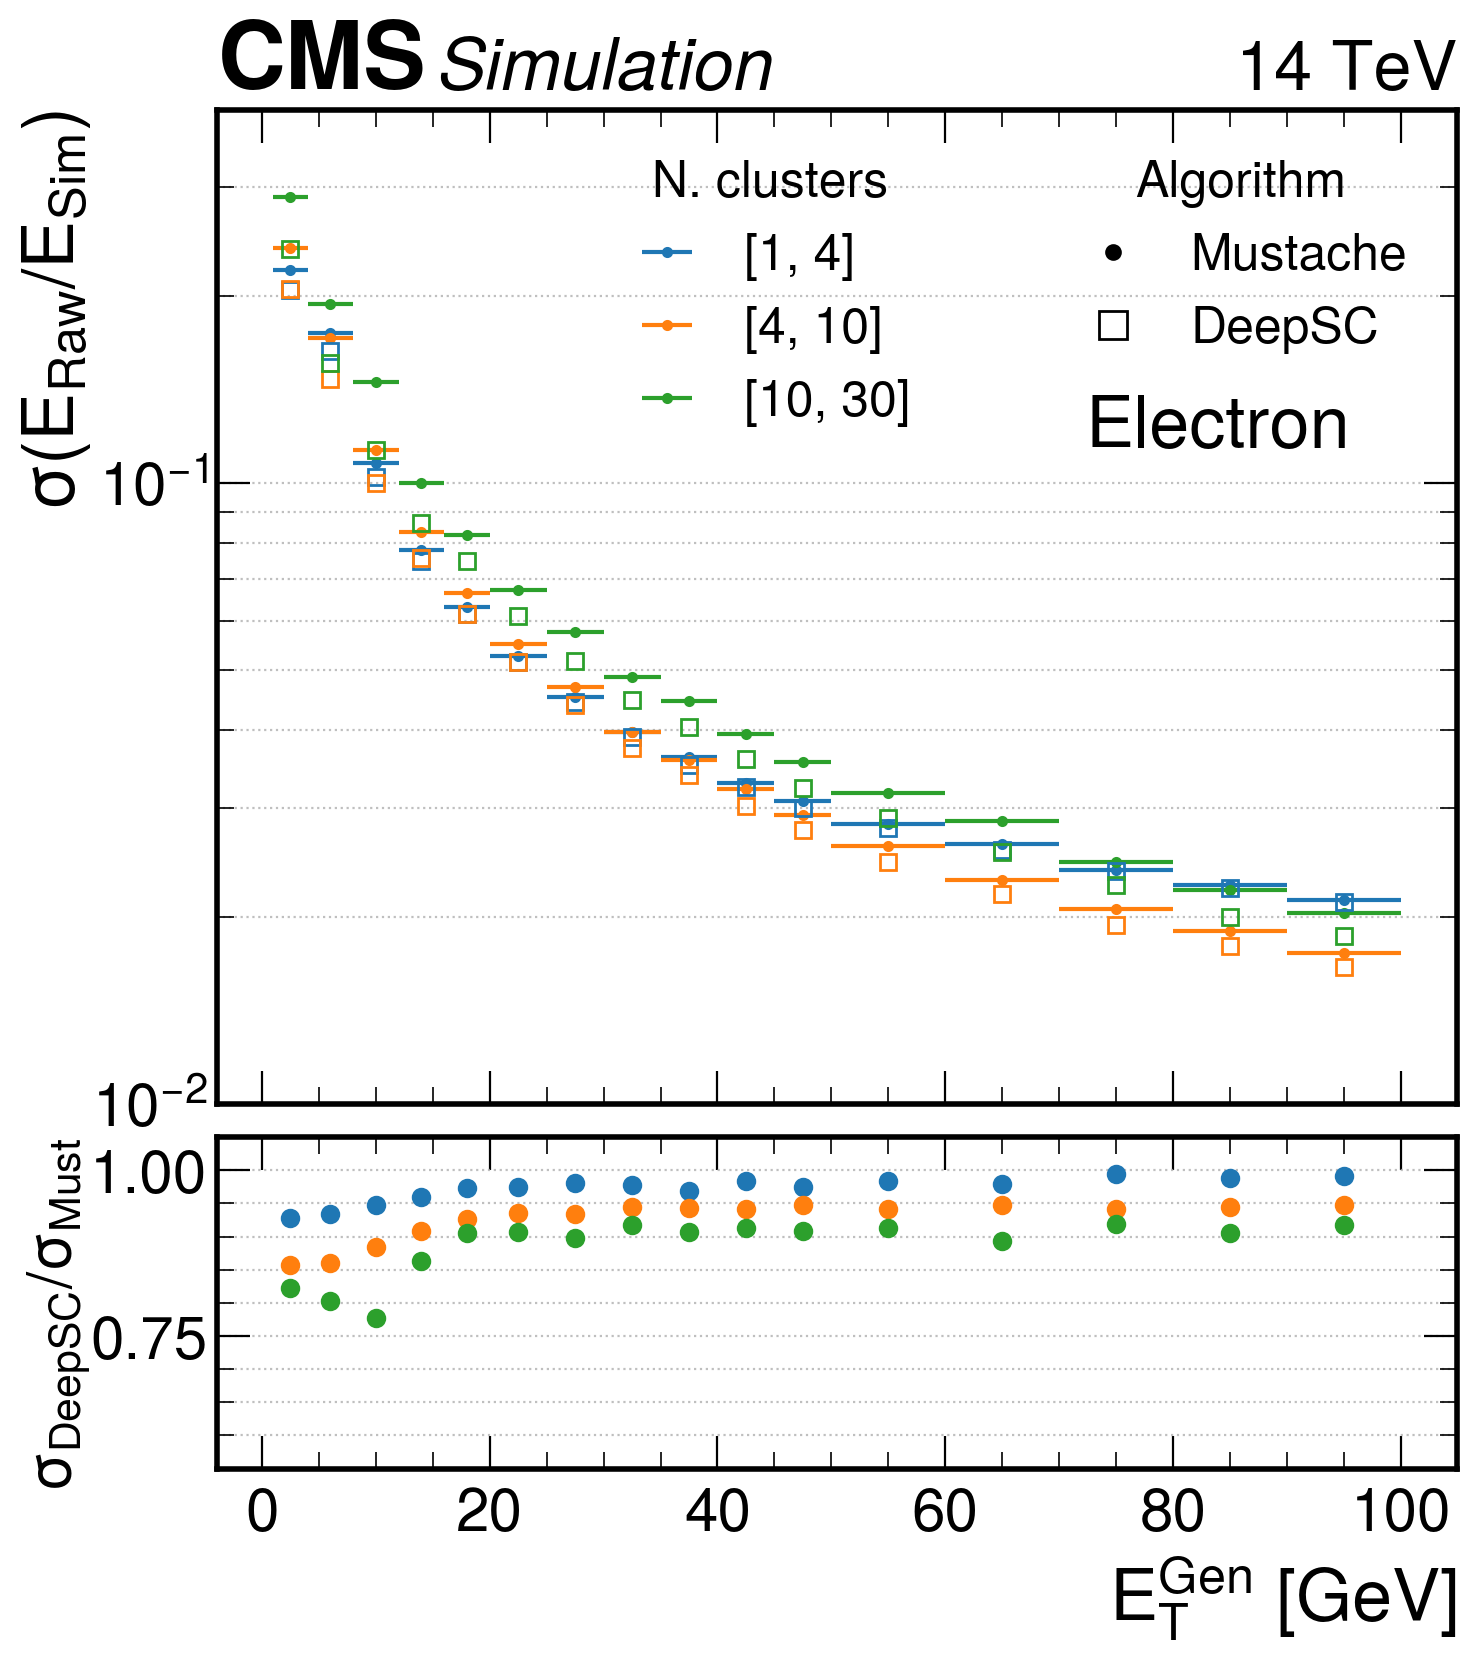

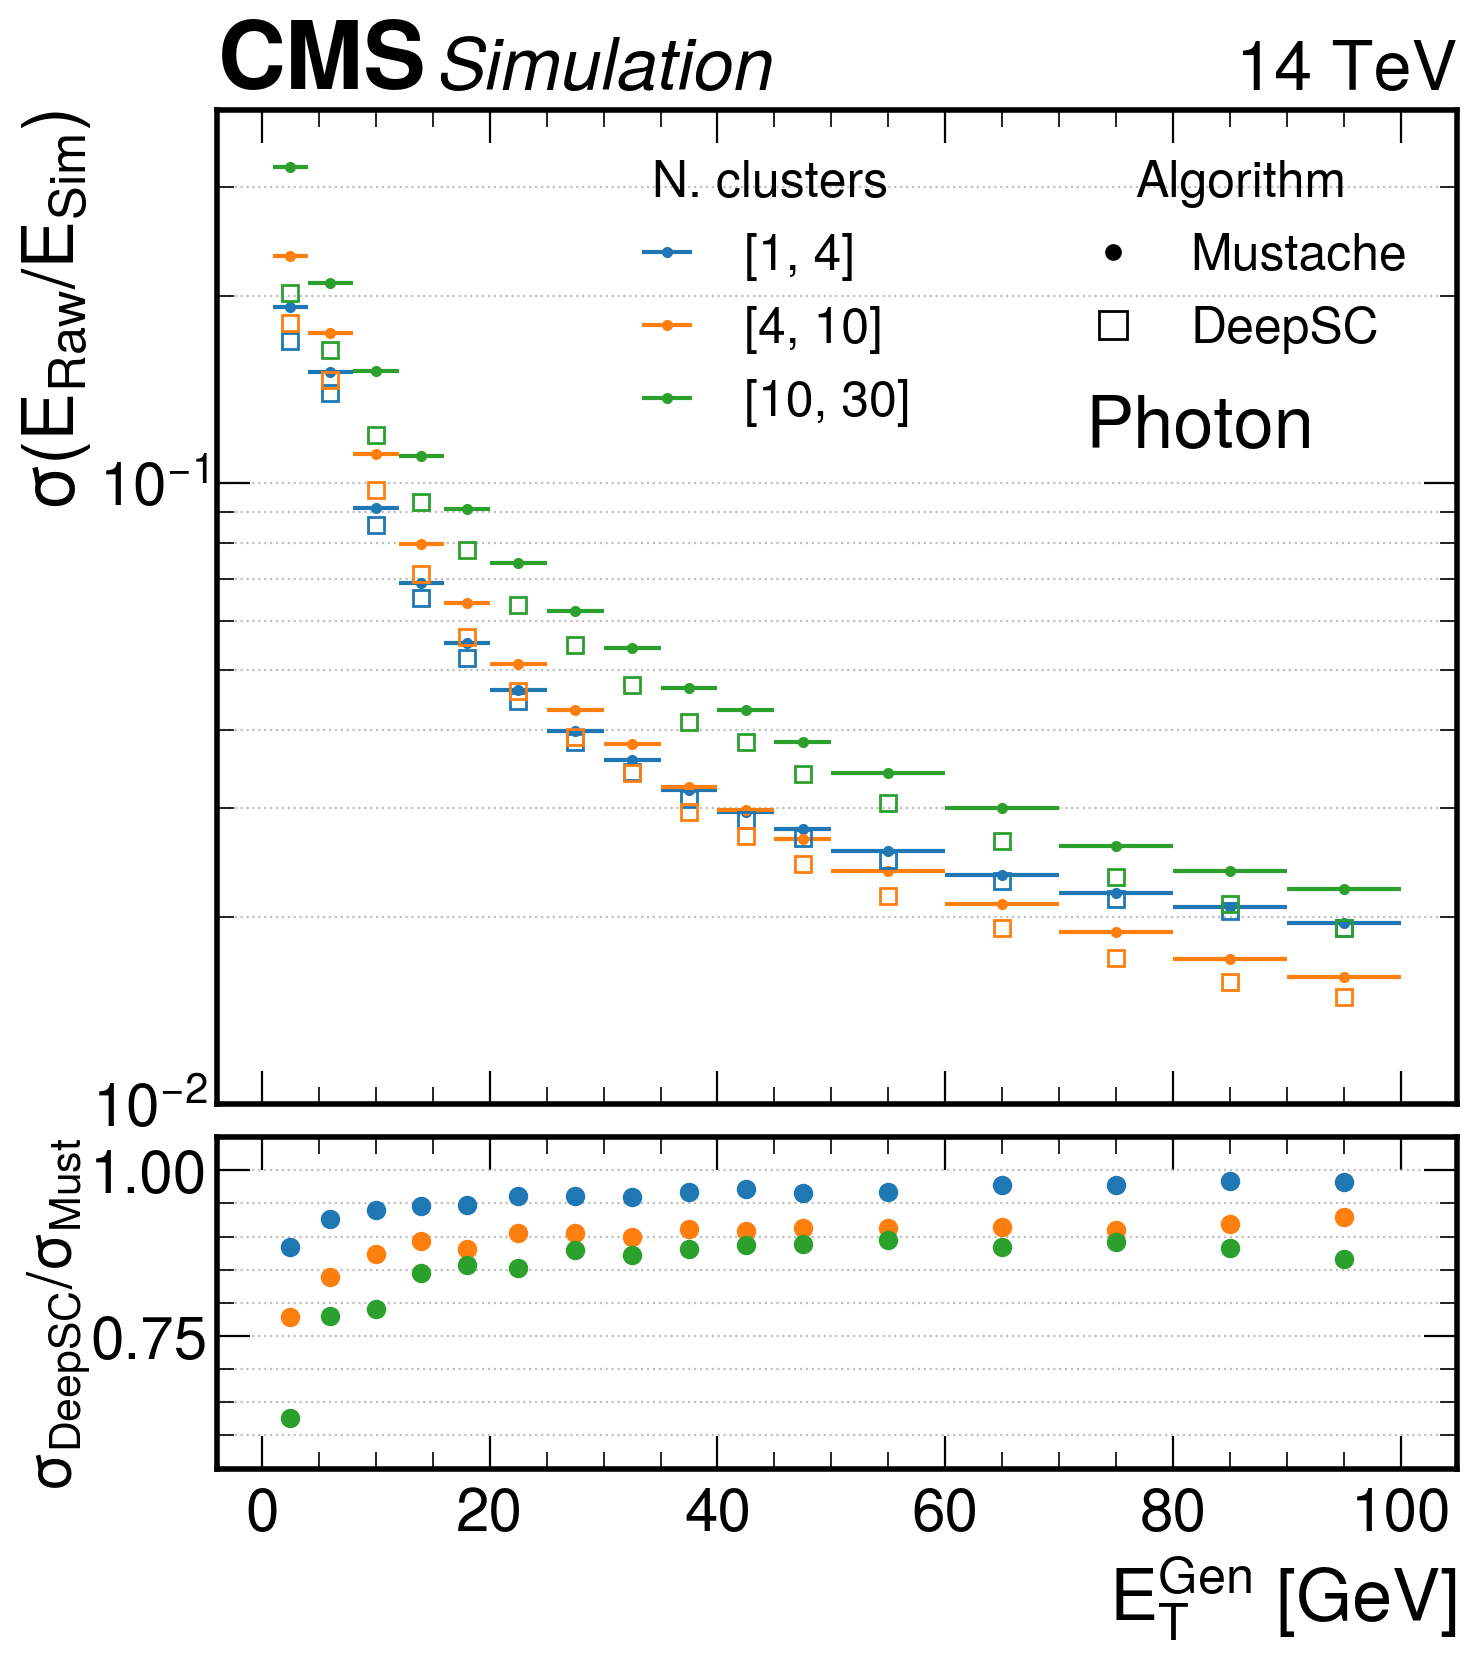

In [19]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [1.00, 4, 8, 12, 16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    ncls = [1,4,10,30]
    df["et_bin"] = pd.cut(df.et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["ncls_bin"] = pd.cut(df.ncls, ncls, labels=list(range(len(ncls)-1)))


    res = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good"))
    res_must = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_sim_good_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []


        
    for icl, cl in enumerate(ncls[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.ncls_bin == icl].w68, xerr=errx, label="[{}, {}]".format(ncls[icl], ncls[icl+1]), fmt = ".")
        mustl.append(l)
        
    for icl, cl in enumerate(ncls[:-1]):
        l = axs[0].errorbar(x, res[res.ncls_bin == icl].w68, xerr=errx,label="[{}, {}]".format(ncls[icl], ncls[icl+1]), 
                                marker="s", markerfacecolor='none', c=mustl[icl].lines[0].get_color(), linestyle='none', elinewidth=0)
        deepl.append(l)
    

    for icl, cl in enumerate(ncls[:-1]):
#         v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
#         var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
        var = res[res.ncls_bin == icl].w68 / res_must[res_must.ncls_bin == icl].w68
        axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(ncls[icl], ncls[icl+1]), fmt="o", linestyle='none', elinewidth=0 )

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(1e-2, 0.4)
    axs[1].set_ylim(0.55, 1.05)
    axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.7, 0.66, flavour, transform=axs[0].transAxes)
    axs[0].set_yscale("log")

    l1= axs[0].legend(handles=mustl, title="N. clusters", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")
    axs[0].grid(axis="y", which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_byEnergy_Ncls_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_Ncls_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_Ncls_{}_ratio.svg".format(flavour))